# Loan Risk Prediction Model

### Introduction

#### This report provides a comprehensive explanation of the Loan Risk Prediction Model developed using the LightGBM algorithm. The report outlines the entire process, from data loading and preprocessing to model training and evaluation. Each section explains the purpose of the code written in the Jupyter Notebook and the rationale behind the choices made.

### Objective

#### The primary objective of this project is to develop a machine learning model to predict the risk associated with loan applications. This is achieved using a combination of feature engineering, data preprocessing, and a LightGBM model.

# =====================================
# Part 1: Setup & Imports
# =====================================


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)  # Show all rows

# =====================================
# Part 2: Load Data
### Data Loading and Exploration

* #### The dataset is loaded using Pandas, and the initial data exploration includes displaying the first few rows and checking for missing values using info() and describe().

* #### This helps in understanding the structure of the data, the presence of null values, and the basic statistics of each feature.

### Why This Step is Important

* #### Understanding the data is crucial for effective feature engineering and preprocessing.

* #### Identifying null values helps in planning data cleaning strategies.
# =====================================

In [2]:
df_loan = pd.read_csv("../givenData/loan.csv")
df_payment = pd.read_csv("../givenData/payment.csv")
df_cuv = pd.read_csv("../givenData/clarity_underwriting_variables.csv")


# =====================================
# Part 3: Data Understanding
# =====================================

In [3]:
# Loan Data
print("Loan Dataset")
display(df_loan.head())
print(df_loan.info())
print(df_loan.describe())


Loan Dataset


loanId                          anon_ssn payFrequency    apr  \
0  LL-I-07399092  beff4989be82aab4a5b47679216942fd            B  360.0   
1  LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
2  LL-I-10707532  3c174ae9e2505a5f9ddbff9843281845            B  590.0   
3  LL-I-02272596  9be6f443bb97db7e95fa0c281d34da91            B  360.0   
4  LL-I-09542882  63b5494f60b5c19c827c7b068443752c            B  590.0   

              applicationDate  originated              originatedDate  \
0  2016-02-23T17:29:01.940000       False                         NaN   
1  2016-01-19T22:07:36.778000        True  2016-01-20T15:49:18.846000   
2  2016-08-01T13:51:14.709000       False                         NaN   
3  2015-08-06T23:58:08.880000       False                         NaN   
4  2016-06-05T22:31:34.304000       False                         NaN   

   nPaidOff  approved  isFunded             loanStatus  loanAmount  \
0       0.0     False         0  Withdrawn Application       500.0   
1       0.0      True         1          Paid Off Loan      3000.0   
2       0.0     False         0  Withdrawn Application       400.0   
3       0.0     False         0  Withdrawn Application       500.0   
4       0.0     False         0               Rejected       350.0   

   originallyScheduledPaymentAmount state     leadType  leadCost fpStatus  \
0                            978.27    IL  bvMandatory         6      NaN   
1                           6395.19    CA    prescreen         0  Checked   
2                           1199.45    MO  bvMandatory         3      NaN   
3                           1074.05    IL  bvMandatory         3      NaN   
4                            814.37    NV  bvMandatory         3      NaN   

             clarityFraudId  hasCF  
0  5669ef78e4b0c9d3936440e6      1  
1  569eb3a3e4b096699f685d64      1  
2  579eab11e4b0d0502870ef2f      1  
3  555b1e95e4b0f6f11b267c18      1  
4  5754a91be4b0c6a2bf424772      1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577682 entries, 0 to 577681
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   loanId                            577426 non-null  object 
 1   anon_ssn                          577682 non-null  object 
 2   payFrequency                      576409 non-null  object 
 3   apr                               573760 non-null  float64
 4   applicationDate                   577682 non-null  object 
 5   originated                        577682 non-null  bool   
 6   originatedDate                    46044 non-null   object 
 7   nPaidOff                          577658 non-null  float64
 8   approved                          577682 non-null  bool   
 9   isFunded                          577682 non-null  int64  
 10  loanStatus                        577291 non-null  object 
 11  loanAmount                        575432 non-null  f

In [4]:
# Payment Data
print("Payment Dataset")
display(df_payment.head())
print(df_payment.info())
print(df_payment.describe())


Payment Dataset


loanId  installmentIndex  isCollection          paymentDate  \
0  LL-I-00000021                 1         False  2014-12-19T05:00:00   
1  LL-I-00000021                 2         False  2015-01-02T05:00:00   
2  LL-I-00000021                 3         False  2015-01-16T05:00:00   
3  LL-I-00000021                 4         False  2015-01-30T05:00:00   
4  LL-I-00000021                 5         False  2015-02-13T05:00:00   

   principal    fees  paymentAmount paymentStatus paymentReturnCode  
0      22.33  147.28         169.61       Checked               NaN  
1      26.44  143.17         169.61       Checked               NaN  
2      31.30  138.31         169.61       Checked               NaN  
3      37.07  132.54         169.61       Checked               NaN  
4      43.89  125.72         169.61       Checked               NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689364 entries, 0 to 689363
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loanId             689364 non-null  object 
 1   installmentIndex   689364 non-null  int64  
 2   isCollection       689364 non-null  bool   
 3   paymentDate        689364 non-null  object 
 4   principal          689364 non-null  float64
 5   fees               689364 non-null  float64
 6   paymentAmount      689364 non-null  float64
 7   paymentStatus      525307 non-null  object 
 8   paymentReturnCode  31533 non-null   object 
dtypes: bool(1), float64(3), int64(1), object(4)
memory usage: 42.7+ MB
None
       installmentIndex      principal           fees  paymentAmount
count     689364.000000  689364.000000  689364.000000  689364.000000
mean          10.553222      45.557543      67.003994     112.680232
std            8.049530      81.724683      59.789510     105.78371

In [5]:
# Clarity Underwriting Data
print("Clarity Underwriting Dataset")
display(df_cuv.head())
print(df_cuv.info())
print(df_cuv.describe())

Clarity Underwriting Dataset


.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago  \
0                                                8.0                     
1                                                5.0                     
2                                                9.0                     
3                                                3.0                     
4                                                5.0                     

   .underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago  \
0                                                2.0                          
1                                                2.0                          
2                                                4.0                          
3                                                2.0                          
4                                                5.0                          

   .underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago  \
0                                                2.0                    
1                                                2.0                    
2                                                2.0                    
3                                                2.0                    
4                                                2.0                    

   .underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago  \
0                                                2.0                  
1                                                2.0                  
2                                                3.0                  
3                                                2.0                  
4                                                2.0                  

   .underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago  \
0                                                8.0                     
1                                               11.0                     
2                                               10.0                     
3                                                9.0                     
4                                                6.0                     

   .underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago  \
0                                                2.0                    
1                                                2.0                    
2                                                8.0                    
3                                                2.0                    
4                                                5.0                    

   .underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago  \
0                                                2.0                     
1                                                2.0                     
2                                                2.0                     
3                                                2.0                     
4                                                2.0                     

   .underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago  \
0                                                5.0                      
1                                                4.0                      
2                                                9.0                      
3                                                2.0                      
4                                                5.0                      

   .underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago  \
0                                               10.0                             
1                                               21.0                             
2                                               25.0                             
3                                                9.0                             
4                          

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49752 entries, 0 to 49751
Data columns (total 54 columns):
 #   Column                                                                                               Non-Null Count  Dtype  
---  ------                                                                                               --------------  -----  
 0   .underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago                                  49750 non-null  float64
 1   .underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago                             49750 non-null  float64
 2   .underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago                                   49750 non-null  float64
 3   .underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago                                     49750 non-null  float64
 4   .underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago                                  49750

In [6]:
def missing_report(df, name):
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    print(f"\n{name} missing values:\n{missing}")

missing_report(df_loan, "Loan")
missing_report(df_payment, "Payment")
missing_report(df_cuv, "Clarity")



Loan missing values:
originatedDate    531638
fpStatus          525959
clarityFraudId    219989
apr                 3922
loanAmount          2250
payFrequency        1273
loanStatus           391
loanId               256
state                132
nPaidOff              24
dtype: int64

Payment missing values:
paymentReturnCode    657831
paymentStatus        164057
dtype: int64

Clarity missing values:
.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype                           48237
.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncodedescription        47083
.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode                   47083
.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncodedescription    44125
.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode               44125
.underwritingdataclarity.clearfraud.clearfraudident

# =====================================
# Part 4: Data Pre-processing
* ### Missing values are handled using appropriate techniques such as imputation or removal based on the nature of the data.

* ### Data types are converted where necessary to ensure compatibility with the machine learning model.

### Why This Step is Important

* ### Proper data preprocessing improves model performance and prevents errors during model training.

* ### Cleaning the data ensures that the model can effectively learn from the available information.
# =====================================

In [7]:
# Check if all values in 'loanId' column are unique (no duplicates)
df_loan['loanId'].is_unique


False

In [8]:
# Get count of unique values and count of null values in 'clarityFraudId' column
df_loan['clarityFraudId'].nunique(),df_loan['clarityFraudId'].isnull().sum()

(314915, np.int64(219989))

In [9]:
# Count how many null values exist in 'loanId' column
df_loan['loanId'].isna().sum()

np.int64(256)

In [10]:
# Filter dataframe to keep only rows where 'loanId' is not null
df_loan = df_loan[df_loan['loanId'].notna()]

In [11]:
# Check again if 'loanId' values are unique after removing nulls
df_loan['loanId'].is_unique

True

In [12]:
# Target variable candidates
print("\nLoan Status Value Counts:")
print(df_loan['loanStatus'].value_counts())


Loan Status Value Counts:
loanStatus
Withdrawn Application          450984
Rejected                        85070
Paid Off Loan                   11427
External Collection             11334
New Loan                         8112
Internal Collection              5567
Returned Item                    1182
CSR Voided New Loan              1026
Settlement Paid Off               708
Credit Return Void                704
Customer Voided New Loan          504
Settled Bankruptcy                326
Pending Paid Off                  169
Charged Off Paid Off              160
Pending Application Fee             5
Pending Application                 4
Pending Rescind                     4
Voided New Loan                     2
Charged Off                         1
Customver Voided New Loan           1
Settlement Pending Paid Off         1
Name: count, dtype: int64


In [13]:
print("\nFirst Payment Status Value Counts:")
print(df_loan['fpStatus'].value_counts())


First Payment Status Value Counts:
fpStatus
Checked        32978
No Payments    11331
Rejected        5522
No Schedule     1163
Cancelled        249
Skipped          218
Pending            5
Returned           1
Name: count, dtype: int64


In [14]:
# Get count of unique values and count how many loanIds are duplicated
df_payment['loanId'].nunique(), df_payment['loanId'].duplicated().sum()

(39952, np.int64(649412))

In [15]:
# Check for multiple loans with the same loanId
loan_count_per_id = df_payment.groupby('loanId')['loanId'].count()

# Filter out loanIds that have more than one entry
multiple_loans = loan_count_per_id[loan_count_per_id > 1]

# Check how many loanIds have more than one entry
print(multiple_loans)


loanId
LL-I-00000021     13
LL-I-00000231     20
LL-I-00000238     16
LL-I-00000308     22
LL-I-00000355     23
LL-I-00000419     21
LL-I-00000614     23
LL-I-00001902     12
LL-I-00002130     19
LL-I-00002148     22
LL-I-00002583     37
LL-I-00002680     20
LL-I-00002714     22
LL-I-00002861     15
LL-I-00002917     21
LL-I-00003372     12
LL-I-00003378     13
LL-I-00003578     14
LL-I-00003606     12
LL-I-00003721     14
LL-I-00003728     23
LL-I-00003732     12
LL-I-00003773     12
LL-I-00003838     22
LL-I-00004217     21
LL-I-00004311     23
LL-I-00004684     19
LL-I-00004745     12
LL-I-00004803     21
LL-I-00004937     12
LL-I-00005146     13
LL-I-00005242     23
LL-I-00005261     12
LL-I-00005466     13
LL-I-00005667     16
LL-I-00005694     18
LL-I-00005757     12
LL-I-00005982     23
LL-I-00006127     12
LL-I-00006249     17
LL-I-00006294     21
LL-I-00006708     24
LL-I-00007334     20
LL-I-00007838     22
LL-I-00007890     23
LL-I-00008746     18
LL-I-00009027     20
LL-I-0

In [16]:
# Check if all values in 'underwritingid' column are unique (no duplicates)
df_cuv['underwritingid'].is_unique

True

In [17]:
# Identify all columns under 'clearfraudinquiry'
inquiry_cols = [col for col in df_cuv.columns if 'clearfraudinquiry' in col]

# Drop rows with NaN in any clearfraudinquiry column
df_cuv_preclean = df_cuv.dropna(subset=inquiry_cols)

# Check shape after drop
print("Before:", df_cuv.shape)
print("After dropping clearfraudinquiry NaNs:", df_cuv_preclean.shape)


Before: (49752, 54)
After dropping clearfraudinquiry NaNs: (49750, 54)


In [18]:
# Step 1: Identify all clearfraudindicator columns
indicator_cols = [col for col in df_cuv_preclean.columns if 'clearfraudindicator' in col]

# Step 2: Create a summary to find columns with only False + NaN
summary = []
for col in indicator_cols:
    num_false = (df_cuv_preclean[col] == False).sum()
    num_true = (df_cuv_preclean[col] == True).sum()
    num_nan = df_cuv_preclean[col].isna().sum()
    
    if num_true == 0 and num_nan > 0:
        summary.append(col)

# Step 3: Drop rows that have NaN in these specific 4 columns
df_cuv_cleaned = df_cuv_preclean.dropna(subset=summary)

# Step 4: Print shape to confirm
print("Original shape:", df_cuv_preclean.shape)
print("Cleaned shape:", df_cuv_cleaned.shape)

Original shape: (49750, 54)
Cleaned shape: (49712, 54)


In [19]:
loan_with_clarity = df_loan.merge(df_cuv_cleaned, how='left', left_on='clarityFraudId', right_on='underwritingid')
loan_with_clarity['underwritingid'].isnull().mean()  # % of unmatched clarity rows


np.float64(0.9371590472199035)

## Merge Data

In [20]:
# Merge payments
loan_payment = df_loan.merge(df_payment, on='loanId', how='left')

# Merge clarity data
loan_full = loan_payment.merge(df_cuv_cleaned, how='left', left_on='clarityFraudId', right_on='underwritingid')

# Drop underwritingid after the merge
loan_full.drop('underwritingid', axis=1, inplace=True)


In [21]:
# Show columns with null values
null_columns = loan_full.isnull().sum()

# Filter columns that have missing values
null_columns = null_columns[null_columns > 0]

# Display the columns and their missing values count
print(null_columns)


payFrequency                                                                                              1270
apr                                                                                                       3666
originatedDate                                                                                          531629
nPaidOff                                                                                                   386
loanStatus                                                                                                 135
loanAmount                                                                                                1994
state                                                                                                      132
fpStatus                                                                                                542583
clarityFraudId                                                                                          328692
i

## Data Preparation

In [22]:
# Define risk tiers based on explicit score boundaries
conditions = [
    (loan_full['clearfraudscore'] > 716.50),  # Paid Off and best New Loans
    (loan_full['clearfraudscore'].between(691.50, 716.50)),  # New Loan to Collection range
    (loan_full['clearfraudscore'] < 691.50)  # Rejected through Withdrawn
]

values = ['Low Risk', 'Moderate Risk', 'High Risk']

# Create the new feature (will raise error if nulls exist)
loan_full['loanRisk'] = np.select(conditions, values, default=None)

# Enforce no nulls - alternative handling options:
# Option 1: Drop nulls (if minimal)
# loan_full = loan_full.dropna(subset=['clearfraudscore'])

# Option 2: Fill with moderate risk (if business-approved)
# loan_full['loanRisk'] = loan_full['loanRisk'].fillna('Moderate Risk')

# Verify output
risk_distribution = loan_full['loanRisk'].value_counts()
print("Final Risk Distribution:\n", risk_distribution[values])  # Force ordered output

Final Risk Distribution:
 loanRisk
Low Risk         249396
Moderate Risk     34418
High Risk        276912
Name: count, dtype: int64


## Data Cleaning

In [23]:
# Check for unique values
loan_full['payFrequency'].unique()

array(['B', 'M', 'S', 'I', 'W', nan], dtype=object)

In [24]:
# Check total null values
loan_full['payFrequency'].isna().sum()

np.int64(1270)

In [25]:
# Drop null values of payFrequency as could not justify which category
loan_full = loan_full.dropna(subset=['payFrequency'])

In [26]:
# Check total null values
loan_full['payFrequency'].isna().sum()

np.int64(0)

In [27]:
# Check total null values
loan_full['apr'].isna().sum()

np.int64(3615)

In [28]:
# Get one null payFrequency row
null_row = loan_full[loan_full['apr'].isna()].head(1)

# Get 4 random non-null rows
non_null_rows = loan_full[loan_full['apr'].notna()].sample(4, random_state=42)

# Combine and display
combined = pd.concat([null_row, non_null_rows])
display(combined[['apr'] + [col for col in loan_full.columns if col != 'apr']])

apr         loanId                          anon_ssn payFrequency  \
283        NaN  LL-I-09584243  ffecddf04ba321d5cc545f252c3be2e1            B   
916835   490.0  LL-I-09075785  b455504431b92249a343f3511a2cb227            W   
1029244  590.0  LL-I-11451006  d99c1f14d4fd0c4b20d49e552921ccb5            B   
943965   645.0  LL-I-12420699  b837cb7a833a7d2e35cf302c5cbc7bf4            W   
3455     645.0  LL-I-14287486  9b25265f82a3eeacc88068afe2e7304c            W   

                    applicationDate  originated              originatedDate  \
283      2016-06-07T13:56:27.616000       False                         NaN   
916835   2016-05-16T21:30:44.103000        True  2016-05-17T17:50:22.355000   
1029244  2016-08-25T16:01:07.472000        True  2016-08-25T18:57:38.828000   
943965   2016-12-02T21:27:55.261000        True  2016-12-09T22:15:35.446000   
3455     2017-01-03T00:10:18.882000       False                         NaN   

         nPaidOff  approved  isFunded  ...  \
283           0.0     False         0  ...   
916835        0.0      True         1  ...   
1029244       0.0      True         1  ...   
943965        0.0      True         1  ...   
3455          0.0     False         0  ...   

        .underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription  \
283                                                    NaN                                             
916835                                        (U) Unlisted                                             
1029244                                   (M) Mobile Phone                                             
943965                                    (M) Mobile Phone                                             
3455                                                   NaN                                             

         .underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult  \
283                                                    NaN                                       
916835                                             partial                                       
1029244                                              match                                       
943965                                               match                                       
3455                                                   NaN                                       

         .underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype  \
283                                                    NaN                              
916835                                                 NaN                              
1029244                                                NaN                              
943965                                                 NaN                              
3455                                                   NaN                              

        .underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode  \
283                                                    NaN                                    
916835                                                 D07                                    
1029244                                                NaN                                    
943965                                                 NaN                                    
3455                                                   NaN                                    

        .underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode  \
283                                                    NaN                                     
916835                                                 NaN                                     
1029244                                                NaN                                     
943965                                                 NaN                

In [29]:
# Check mean and median of loan apr to decide which to use to fill null values
print("Mean APR:", loan_full['apr'].mean())
print("Median APR:", loan_full['apr'].median())

Mean APR: 536.5003703706278
Median APR: 590.0


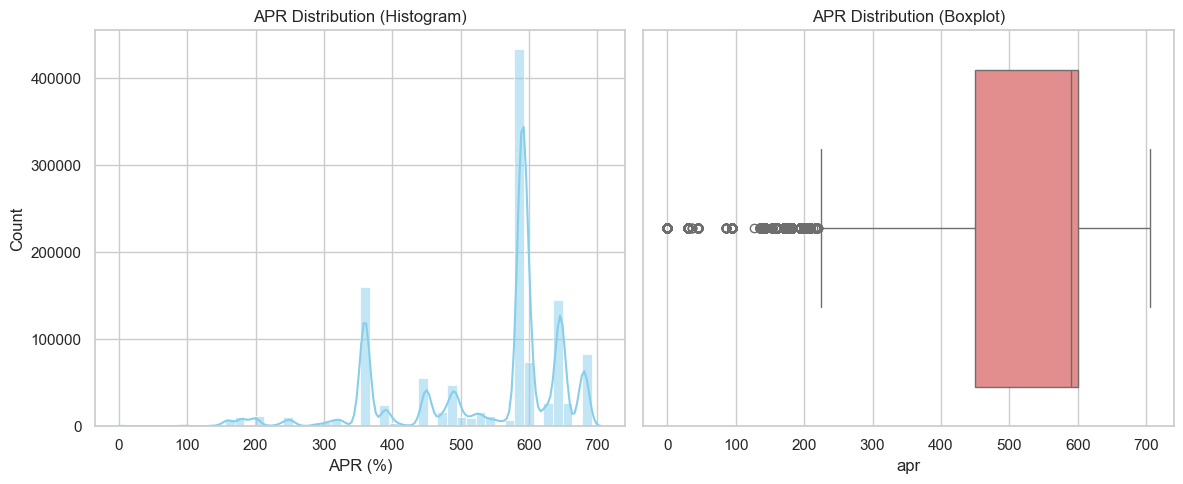

In [30]:
# Check if data is skewed or not.
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set(style="whitegrid")

# Create subplots
plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(loan_full['apr'], bins=50, kde=True, color='skyblue')
plt.title('APR Distribution (Histogram)')
plt.xlabel('APR (%)')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=loan_full['apr'], color='lightcoral')
plt.title('APR Distribution (Boxplot)')

plt.tight_layout()
plt.show()


In [31]:
loan_full['apr'].fillna(loan_full['apr'].median(), inplace=True)


In [32]:
loan_full['apr'].isna().sum()

np.int64(0)

In [33]:
# Get one null originatedDate row
null_row = loan_full[loan_full['originatedDate'].isna()].head(1)

# Get 4 random non-null rows
non_null_rows = loan_full[loan_full['originatedDate'].notna()].sample(4, random_state=42)

# Combine and display
combined = pd.concat([null_row, non_null_rows])
display(combined[['originatedDate'] + [col for col in loan_full.columns if col != 'originatedDate']])

originatedDate         loanId  \
0                               NaN  LL-I-07399092   
1157574  2016-12-12T23:30:10.094000  LL-I-12984403   
436140   2017-03-14T00:30:10.402000  LL-I-18363288   
400051   2016-12-08T17:27:53.103000  LL-I-12658817   
171870   2016-09-13T14:15:49.688000  LL-I-11960189   

                                 anon_ssn payFrequency    apr  \
0        beff4989be82aab4a5b47679216942fd            B  360.0   
1157574  997e6391edac6fc2625f8ab02ed98c63            W  645.0   
436140   6ba526eeb21e32290b2a22f69a4a0103            W  590.0   
400051   40d6cb256cabb8c882160323f2c491c7            W  645.0   
171870   79f6de42d15750ebba7a25ad9a5b7d40            B  360.0   

                    applicationDate  originated  nPaidOff  approved  isFunded  \
0        2016-02-23T17:29:01.940000       False       0.0     False         0   
1157574  2016-12-12T23:01:31.924000        True       0.0      True         1   
436140   2017-03-14T00:16:47.762000        True       0.0      True         1   
400051   2016-12-07T23:35:30.491000        True       0.0      True         1   
171870   2016-09-12T23:29:00.601000        True       0.0      True         1   

         ...  \
0        ...   
1157574  ...   
436140   ...   
400051   ...   
171870   ...   

        .underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription  \
0                                                      NaN                                             
1157574                                   (M) Mobile Phone                                             
436140                                    (M) Mobile Phone                                             
400051                                    (M) Mobile Phone                                             
171870                                    (M) Mobile Phone                                             

         .underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult  \
0                                                      NaN                                       
1157574                                            partial                                       
436140                                               match                                       
400051                                             partial                                       
171870                                               match                                       

         .underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype  \
0                                                      NaN                              
1157574                                                NaN                              
436140                                                 NaN                              
400051                                                 NaN                              
171870                                                 NaN                              

        .underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode  \
0                                                      NaN                                    
1157574                                                D07                                    
436140                                                 NaN                                    
400051                                                 NaN                                    
171870                                                 NaN                                    

        .underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode  \
0                                                      NaN                                     
1157574                                                NaN                                     
436140                                                 NaN                                     
400051           

In [34]:
# Check distribution of 'originated' flag among records with null originatedDate
# This helps understand if null dates are associated with non-originated loans
loan_full[loan_full['originatedDate'].isnull()]['originated'].value_counts()


originated
False    530359
Name: count, dtype: int64

In [35]:
# Check for duplication rows in dataset
loan_full.duplicated().sum()


np.int64(0)

In [36]:
# Drop dates as it is not time series, drop meaningless categories
loan_full = loan_full.drop(['originatedDate','applicationDate', 'paymentDate', 'hasCF'], axis=1)

In [37]:
# Check if dropped columns still exist
display("loan info:", loan_full.head())

'loan info:'

loanId                          anon_ssn payFrequency    apr  \
0  LL-I-07399092  beff4989be82aab4a5b47679216942fd            B  360.0   
1  LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
2  LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
3  LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
4  LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   

   originated  nPaidOff  approved  isFunded             loanStatus  \
0       False       0.0     False         0  Withdrawn Application   
1        True       0.0      True         1          Paid Off Loan   
2        True       0.0      True         1          Paid Off Loan   
3        True       0.0      True         1          Paid Off Loan   
4        True       0.0      True         1          Paid Off Loan   

   loanAmount  ...  \
0       500.0  ...   
1      3000.0  ...   
2      3000.0  ...   
3      3000.0  ...   
4      3000.0  ...   

   .underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription  \
0                                                NaN                                              
1                                                NaN                                              
2                                                NaN                                              
3                                                NaN                                              
4                                                NaN                                              

  .underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult  \
0                                                NaN                                      
1                                            partial                                      
2                                            partial                                      
3                                            partial                                      
4                                            partial                                      

  .underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype  \
0                                                NaN                             
1                                                NaN                             
2                                                NaN                             
3                                                NaN                             
4                                                NaN                             

   .underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode  \
0                                                NaN                                     
1                                                D04                                     
2                                                D04                                     
3                                                D04                                     
4                                                D04                                     

  .underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode  \
0                                                NaN                                     
1                                                NaN                                     
2                                                NaN                                     
3                                                NaN                                     
4                                                NaN                                     

  .underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode  \
0                                                NaN                                         
1                                                NaN                                         
2           

In [38]:
# Check unique values
loan_full['nPaidOff'].unique()

array([ 0.,  2.,  3.,  1.,  4.,  5.,  7.,  6., 18., 13., nan, 19., 10.,
        8., 11.,  9., 15., 12., 21., 17., 14., 16., 20.])

In [39]:
# Calculate and print the mean (average) and median (middle value) of nPaidOff
print("Mean nPaidOff:", loan_full['nPaidOff'].mean())
print("Median nPaidOff:", loan_full['nPaidOff'].median())


Mean nPaidOff: 0.19680749472323295
Median nPaidOff: 0.0


In [40]:
# Since this shows how many ML loans this client has paid off in the past, if null can assume '0'
loan_full['nPaidOff'] = loan_full['nPaidOff'].fillna(0)


In [41]:
# Check unique values
loan_full['loanStatus'].unique()

array(['Withdrawn Application', 'Paid Off Loan', 'Rejected', 'New Loan',
       'Internal Collection', 'CSR Voided New Loan',
       'External Collection', 'Returned Item', 'Customer Voided New Loan',
       'Credit Return Void', 'Pending Paid Off', 'Charged Off Paid Off',
       'Settled Bankruptcy', nan, 'Settlement Paid Off', 'Charged Off',
       'Pending Rescind', 'Customver Voided New Loan',
       'Pending Application', 'Voided New Loan',
       'Pending Application Fee', 'Settlement Pending Paid Off'],
      dtype=object)

In [42]:
# Get one null loanStatus row
null_row = loan_full[loan_full['loanStatus'].isna()].head(1)

# Get 4 random non-null rows
non_null_rows = loan_full[loan_full['loanStatus'].notna()].sample(4, random_state=42)

# Combine and display
combined = pd.concat([null_row, non_null_rows])
display(combined[['loanStatus'] + [col for col in loan_full.columns if col != 'loanStatus']])

loanStatus         loanId  \
5166                       NaN  LL-I-12186108   
549293   Withdrawn Application  LL-I-09787398   
1219945          Paid Off Loan  LL-I-07561266   
1047254  Withdrawn Application  LL-I-17823108   
169658   Withdrawn Application  LL-I-09796094   

                                 anon_ssn payFrequency    apr  originated  \
5166     7170f216f7f6397253afd3d835e7290e            W  590.0       False   
549293   c204994fc525f32cfcd65ddab57a7589            S  590.0       False   
1219945  a6f836243dc66fb8d122b193fec86626            B  590.0        True   
1047254  15de9374e7dd4536ce5af9e151b6eb0c            M  645.0       False   
169658   8c6e68671c53851219cd682d708f2fab            W  650.0       False   

         nPaidOff  approved  isFunded  loanAmount  ...  \
5166          0.0     False         0       500.0  ...   
549293        0.0     False         0       500.0  ...   
1219945       0.0      True         1      1000.0  ...   
1047254       0.0     False         0      1000.0  ...   
169658        0.0     False         0       350.0  ...   

         .underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription  \
5166                                                   NaN                                              
549293                                                 NaN                                              
1219945                                   (M) Mobile Phone                                              
1047254                                                NaN                                              
169658                                                 NaN                                              

        .underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult  \
5166                                                   NaN                                      
549293                                                 NaN                                      
1219945                                              match                                      
1047254                                                NaN                                      
169658                                                 NaN                                      

        .underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype  \
5166                                                   NaN                             
549293                                                 NaN                             
1219945                                                NaN                             
1047254                                                NaN                             
169658                                                 NaN                             

         .underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode  \
5166                                                   NaN                                     
549293                                                 NaN                                     
1219945                                                NaN                                     
1047254                                                NaN                                     
169658                                                 NaN                                     

        .underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode  \
5166                                                   NaN                                     
549293                                                 NaN                                     
1219945                                                NaN                                     
1047254                                                NaN                                     
169658                                                 NaN                                     

        .underwr

In [43]:
# Standardizes raw loan status values into consistent categories.
def standardize_loan_status(status):
    
    # Handle missing values first
    if pd.isna(status):
        return 'Unknown'
    
    # Normalize text: remove whitespace and convert to lowercase
    status = status.strip().lower()

    # Classification logic - ordered by priority
    if 'void' in status:
        return 'Voided'  # Dictionary: loan approved but cancelled
    elif status == 'returned item':
        return 'Returned Item'  # Missed one payment due to insufficient funds
    elif status == 'rejected':
        return 'Rejected'  # Rejected by automated rules
    elif status == 'withdrawn application':
        return 'Withdrawn'  # Application abandoned or withdrawn
    elif 'paid off' in status or 'settlement' in status:
        return 'Paid Off'  # Includes settlement paid off
    elif 'charged off' in status:
        return 'Charged Off'  # Debt unlikely to be collected
    elif 'collection' in status:
        return 'Collection'  # Sent to collections agency
    elif 'pending' in status:
        return 'Pending'  # Awaiting decision
    elif 'new loan' in status:
        return 'New Loan'  # Recently originated loan
    else:
        return 'Other'  # Catch-all for unclassified statuses

# Apply the cleaning function to create new standardized column
loan_full['loanStatus_cleaned'] = loan_full['loanStatus'].apply(standardize_loan_status)

In [44]:
# Check the new loanStatus
loan_full['loanStatus_cleaned'].value_counts()


loanStatus_cleaned
Withdrawn        449923
Collection       311343
Paid Off         208210
New Loan         129192
Rejected          84942
Voided            18590
Returned Item     17589
Other              5539
Unknown             135
Pending              92
Charged Off          13
Name: count, dtype: int64

In [45]:
# Drop loanStatus as it has new column it
loan_full = loan_full.drop('loanStatus', axis=1)

In [46]:
# Check for null values
loan_full['loanAmount'].isnull().sum()

np.int64(1944)

In [47]:
# Look for pattern and relation with loanStatus
# Get 5 random rows with null loanAmount, showing only loanAmount and loanStatus
random_null_loans = loan_full.loc[loan_full['loanAmount'].isna(), ['loanAmount', 'loanStatus_cleaned', 'loanRisk']].sample(30, random_state=42)

# Display the results
display(random_null_loans)

loanAmount loanStatus_cleaned   loanRisk
1004677         NaN          Withdrawn       None
869634          NaN          Withdrawn       None
1082054         NaN          Withdrawn       None
656896          NaN          Withdrawn       None
204802          NaN          Withdrawn       None
287035          NaN          Withdrawn       None
910301          NaN          Withdrawn       None
386661          NaN          Withdrawn       None
1136035         NaN          Withdrawn       None
204362          NaN          Withdrawn       None
246270          NaN          Withdrawn       None
1003491         NaN          Withdrawn       None
938254          NaN          Withdrawn       None
1107193         NaN          Withdrawn       None
679301          NaN          Withdrawn       None
1090166         NaN          Withdrawn       None
41266           NaN          Withdrawn       None
1001840         NaN          Withdrawn       None
291852          NaN          Withdrawn       None
87821           NaN          Withdrawn       None
358825          NaN          Withdrawn       None
57844           NaN          Withdrawn       None
655016          NaN          Withdrawn       None
879010          NaN           Rejected       None
462047          NaN          Withdrawn  High Risk
903374          NaN          Withdrawn       None
171834          NaN          Withdrawn       None
233481          NaN          Withdrawn       None
809974          NaN          Withdrawn       None
31091           NaN          Withdrawn       None

In [48]:
# For non-funded loans (e.g., loan status = 'Withdrawn Application' or 'Rejected'), fill missing loanAmount with 0
loan_full.loc[loan_full['loanAmount'].isna() & loan_full['loanStatus_cleaned'].isin(['Withdrawn', 'Rejected']), 'loanAmount'] = 0


In [49]:
# Check for null values
loan_full['loanAmount'].isna().sum()

np.int64(0)

In [50]:
# Check uniqueness of the category column
loan_full['state'].unique()

array(['IL', 'CA', 'MO', 'NV', 'IN', 'TX', 'UT', 'FL', 'TN', 'MI', 'RI',
       'OH', 'OK', 'NJ', 'VA', 'LA', 'PA', 'SC', 'NC', 'WI', 'NE', 'ID',
       'CT', 'CO', 'WA', 'AL', 'WY', 'DE', 'NM', 'MS', 'KY', 'GA', 'IA',
       'AZ', 'MN', 'SD', 'HI', 'KS', 'ND', 'AK', nan, 'NY', 'MD',
       'OH-TEST', 'TX-TEST'], dtype=object)

In [51]:
# Find loanIds with inconsistent state values
state_inconsistencies = loan_full.groupby('loanId')['state'].nunique() > 1

# Get the problematic loanIds
problem_loans = state_inconsistencies[state_inconsistencies].index.tolist()

if len(problem_loans) > 0:
    print(f"Found {len(problem_loans)} loanIds with inconsistent state values:")
    
    # Show all records for these problematic loans
    display(loan_full[loan_full['loanId'].isin(problem_loans)].sort_values('loanId'))
else:
    print("No loanIds found with multiple state values")

No loanIds found with multiple state values


In [52]:
# Show test cases to see if its useful or not
display(loan_full[loan_full['state'].isin(['OH-TEST', 'TX-TEST'])])


loanId                          anon_ssn payFrequency    apr  \
724188   LL-I-OHTEST000  b0f45952f9483af558044ca6351d3a4d            M  390.0   
1045516  LL-I-TXTEST000  acb8cfd405bded6d30c735dbd9a9f440            M  390.0   

         originated  nPaidOff  approved  isFunded  loanAmount  \
724188        False       0.0     False         0       500.0   
1045516       False       1.0     False         0       500.0   

         originallyScheduledPaymentAmount  ...  \
724188                            1018.21  ...   
1045516                           1023.43  ...   

        .underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult  \
724188                                                 NaN                                      
1045516                                            partial                                      

        .underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype  \
724188                                                 NaN                             
1045516                                                NaN                             

         .underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode  \
724188                                                 NaN                                     
1045516                                                D04                                     

        .underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode  \
724188                                                 NaN                                     
1045516                                                NaN                                     

        .underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode  \
724188                                                 NaN                                         
1045516                                                NaN                                         

         .underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch  \
724188                                                 NaN                                
1045516                                            invalid                                

        .underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode  \
724188                                                 NaN                                          
1045516                                               15.0                                          

         clearfraudscore   loanRisk  loanStatus_cleaned  
724188               NaN       None           Withdrawn  
1045516            584.0  High Risk           Withdrawn  

[2 rows x 77 columns]

In [53]:
#drop dummy data
loan_full = loan_full[~loan_full['state'].isin(['OH-TEST', 'TX-TEST'])]


In [54]:
#fill missing values with 'Others' state
loan_full['state'] = loan_full['state'].fillna('Others')

In [55]:
# check null values
loan_full['state'].isna().sum()

np.int64(0)

In [56]:
loan_full['installmentIndex'].unique()

array([ nan,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105.])

In [57]:
# Check pattern for installmentIndex
null_row = loan_full[loan_full['installmentIndex'].isna()].head(1)

# Get 4 random non-null rows
non_null_rows = loan_full[loan_full['installmentIndex'].notna()].sample(4, random_state=41)

# Combine and display
combined = pd.concat([null_row, non_null_rows])
display(combined[['installmentIndex'] + [col for col in loan_full.columns if col != 'installmentIndex']])

installmentIndex         loanId                          anon_ssn  \
0                     NaN  LL-I-07399092  beff4989be82aab4a5b47679216942fd   
1014821               3.0  LL-I-08264456  3a92505b11a3bc957f468adb77f543ac   
632669                2.0  LL-I-12080840  c8f804d53632634b402a87339a3699a7   
562198                5.0  LL-I-11847586  544e8a5e3338dbac66cb5a581dfb1b18   
1092680              21.0  LL-I-05642871  b30c8b335e3b3a741039576cbb09f9f0   

        payFrequency    apr  originated  nPaidOff  approved  isFunded  \
0                  B  360.0       False       0.0     False         0   
1014821            I  590.0        True       0.0      True         1   
632669             B  315.0        True       1.0      True         1   
562198             B  590.0        True       0.0      True         1   
1092680            W  601.0        True       0.0      True         1   

         loanAmount  ...  \
0             500.0  ...   
1014821       700.0  ...   
632669        900.0  ...   
562198        600.0  ...   
1092680       600.0  ...   

         .underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult  \
0                                                      NaN                                       
1014821                                            partial                                       
632669                                             partial                                       
562198                                             partial                                       
1092680                                            partial                                       

        .underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype  \
0                                                      NaN                             
1014821                                                NaN                             
632669                                                 NaN                             
562198                                                 NaN                             
1092680                                                NaN                             

        .underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode  \
0                                                      NaN                                    
1014821                                                NaN                                    
632669                                                 D04                                    
562198                                                 NaN                                    
1092680                                                NaN                                    

         .underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode  \
0                                                      NaN                                      
1014821                                                S03                                      
632669                                                 NaN                                      
562198                                                 NaN                                      
1092680                                                NaN                                      

        .underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode  \
0                                                      NaN                                         
1014821                                                NaN                                         
632669                                                 NaN                                         
562198                                                 NaN                                         
1092680                                                NaN                                         

        .underwritingdataclarity.clearfraud.clearfraudident

In [58]:
# Create binary flag for installmentIndex because not sure the feature importance
loan_full['installmentIndex_missing'] = loan_full['installmentIndex'].isna().astype(int)
# set to 0 to assume if not approve means installment have not start
loan_full['installmentIndex'] = loan_full['installmentIndex'].fillna(0)


In [59]:
# check null/missing values are mostly on which status
pd.crosstab(loan_full['loanStatus_cleaned'], loan_full['installmentIndex_missing'], normalize='index')


installmentIndex_missing         0         1
loanStatus_cleaned                          
Charged Off               1.000000  0.000000
Collection                0.999952  0.000048
New Loan                  0.999350  0.000650
Other                     1.000000  0.000000
Paid Off                  0.999981  0.000019
Pending                   0.902174  0.097826
Rejected                  0.000000  1.000000
Returned Item             0.999716  0.000284
Unknown                   0.000000  1.000000
Voided                    0.936955  0.063045
Withdrawn                 0.000189  0.999811

In [60]:
loan_full['installmentIndex'].isna().sum()

np.int64(0)

In [61]:
# Create meaningful categories, if its null, then first payment have not started
loan_full['fpStatus'] = loan_full['fpStatus'].fillna('NotFunded')

In [62]:
#Check for pattern for isCollection
null_row = loan_full[loan_full['isCollection'].isna()].head(2)

# Get 3 random non-null rows
non_null_rows = loan_full[loan_full['isCollection'].notna()].sample(3, random_state=41)

# Combine and display
combined = pd.concat([null_row, non_null_rows])
display(combined[['isCollection'] + [col for col in loan_full.columns if col != 'isCollection']])

isCollection         loanId                          anon_ssn  \
0                NaN  LL-I-07399092  beff4989be82aab4a5b47679216942fd   
26               NaN  LL-I-10707532  3c174ae9e2505a5f9ddbff9843281845   
1014821         True  LL-I-08264456  3a92505b11a3bc957f468adb77f543ac   
632669         False  LL-I-12080840  c8f804d53632634b402a87339a3699a7   
562198         False  LL-I-11847586  544e8a5e3338dbac66cb5a581dfb1b18   

        payFrequency    apr  originated  nPaidOff  approved  isFunded  \
0                  B  360.0       False       0.0     False         0   
26                 B  590.0       False       0.0     False         0   
1014821            I  590.0        True       0.0      True         1   
632669             B  315.0        True       1.0      True         1   
562198             B  590.0        True       0.0      True         1   

         loanAmount  ...  \
0             500.0  ...   
26            400.0  ...   
1014821       700.0  ...   
632669        900.0  ...   
562198        600.0  ...   

         .underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype  \
0                                                      NaN                              
26                                                     NaN                              
1014821                                                NaN                              
632669                                                 NaN                              
562198                                                 NaN                              

        .underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode  \
0                                                      NaN                                    
26                                                     NaN                                    
1014821                                                NaN                                    
632669                                                 D04                                    
562198                                                 NaN                                    

        .underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode  \
0                                                      NaN                                     
26                                                     NaN                                     
1014821                                                S03                                     
632669                                                 NaN                                     
562198                                                 NaN                                     

         .underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode  \
0                                                      NaN                                          
26                                                     NaN                                          
1014821                                                NaN                                          
632669                                                 NaN                                          
562198                                                 NaN                                          

        .underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch  \
0                                                      NaN                               
26                                                     NaN                               
1014821                                              match                               
632669                                             invalid                               
562198                                               match                               

        .underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode  \
0                            

In [63]:
# Create binary flag for isCollection because not sure the feature importance
loan_full['isCollection_missing'] = loan_full['isCollection'].isna().astype(int)
pd.crosstab(loan_full['loanStatus_cleaned'], loan_full['isCollection_missing'], normalize='index')


isCollection_missing         0         1
loanStatus_cleaned                      
Charged Off           1.000000  0.000000
Collection            0.999952  0.000048
New Loan              0.999350  0.000650
Other                 1.000000  0.000000
Paid Off              0.999981  0.000019
Pending               0.902174  0.097826
Rejected              0.000000  1.000000
Returned Item         0.999716  0.000284
Unknown               0.000000  1.000000
Voided                0.936955  0.063045
Withdrawn             0.000189  0.999811

In [64]:
# use mode to fill up the nulls
most_frequent = loan_full['isCollection'].mode()[0]
loan_full['isCollection'].fillna(most_frequent, inplace=True)


In [65]:
# Check pattern for principal, add binary flag
loan_full['principal_missing'] = loan_full['principal'].isna().astype(int)
pd.crosstab(loan_full['loanStatus_cleaned'], loan_full['principal_missing'], normalize='index')


principal_missing          0         1
loanStatus_cleaned                    
Charged Off         1.000000  0.000000
Collection          0.999952  0.000048
New Loan            0.999350  0.000650
Other               1.000000  0.000000
Paid Off            0.999981  0.000019
Pending             0.902174  0.097826
Rejected            0.000000  1.000000
Returned Item       0.999716  0.000284
Unknown             0.000000  1.000000
Voided              0.936955  0.063045
Withdrawn           0.000189  0.999811

In [66]:
# fill principal with 0, assuming loan did not even start
loan_full['principal'].fillna(0, inplace=True)

In [67]:
# Check pattern for fees, add binary flag
loan_full['fees_missing'] = loan_full['fees'].isna().astype(int)
pd.crosstab(loan_full['loanStatus_cleaned'], loan_full['fees_missing'], normalize='index')


fees_missing               0         1
loanStatus_cleaned                    
Charged Off         1.000000  0.000000
Collection          0.999952  0.000048
New Loan            0.999350  0.000650
Other               1.000000  0.000000
Paid Off            0.999981  0.000019
Pending             0.902174  0.097826
Rejected            0.000000  1.000000
Returned Item       0.999716  0.000284
Unknown             0.000000  1.000000
Voided              0.936955  0.063045
Withdrawn           0.000189  0.999811

In [68]:
# fill fees with 0, assuming loan did not even start
loan_full['fees'].fillna(0, inplace=True)

In [69]:
# Check pattern for fees, add binary flag
loan_full['paymentAmount_missing'] = loan_full['paymentAmount'].isna().astype(int)
pd.crosstab(loan_full['loanStatus_cleaned'], loan_full['paymentAmount_missing'], normalize='index')


paymentAmount_missing         0         1
loanStatus_cleaned                       
Charged Off            1.000000  0.000000
Collection             0.999952  0.000048
New Loan               0.999350  0.000650
Other                  1.000000  0.000000
Paid Off               0.999981  0.000019
Pending                0.902174  0.097826
Rejected               0.000000  1.000000
Returned Item          0.999716  0.000284
Unknown                0.000000  1.000000
Voided                 0.936955  0.063045
Withdrawn              0.000189  0.999811

In [70]:
# If both fees and principal are present, we can infer paymentAmount
mask = loan_full['paymentAmount'].isna() & loan_full['fees'].notna() & loan_full['principal'].notna()
loan_full.loc[mask, 'paymentAmount'] = loan_full.loc[mask, 'fees'] + loan_full.loc[mask, 'principal']


In [71]:
# fill paymentAmount with 0, assuming loan did not even start
loan_full['paymentAmount'].fillna(0, inplace=True)

In [72]:
# Check uniqueness on paymentStatus
loan_full['paymentStatus'].unique()

array([nan, 'Checked', 'Cancelled', 'Pending', 'Rejected', 'Skipped',
       'Rejected Awaiting Retry', 'Returned', 'Complete'], dtype=object)

In [73]:
# count records on each category
loan_full['paymentStatus'].value_counts(dropna=False)


paymentStatus
NaN                        700259
Cancelled                  270334
Checked                    209621
Rejected                    32330
Pending                      9241
Skipped                      3761
Rejected Awaiting Retry        18
Returned                        1
Complete                        1
Name: count, dtype: int64

In [74]:
#drop returned and complete as it has only 1 entry and will create noise.
loan_full = loan_full[~loan_full['paymentStatus'].isin(['Complete', 'Returned'])]


In [75]:
# Replace all null with 'None' 
loan_full['paymentStatus'] = loan_full['paymentStatus'].fillna('None')


In [76]:
# Converting to Categorical Data Type
loan_full['paymentStatus'] = loan_full['paymentStatus'].astype('category')


In [77]:
# Check uniqueness 
loan_full['paymentReturnCode'].unique()

array([nan, 'R01', 'R02', 'MISSED', 'R08', 'C01', 'R16', 'R10', 'RXS',
       'R03', 'R09', 'RAF', 'R07', 'C05', 'R20', 'R19', 'R99', 'RBW',
       'RWC', 'LPP01', 'R04', 'C03', 'R15', 'RUP', 'C02', 'R06', 'R29',
       'R13', 'C07', 'RFG', 'RXL', 'RIR'], dtype=object)

In [78]:
# List from MoneyLion's appendix
valid_return_codes = [
    'R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10',
    'R11', 'R12', 'R13', 'R14', 'R15', 'R16', 'R17', 'R20', 'R21', 'R22',
    'R23', 'R24', 'R29', 'R31', 'R33'
]

# Actual unique codes in your dataset
actual_codes = loan_full['paymentReturnCode'].dropna().unique()

# Identify undocumented or unknown codes
unknown_codes = [code for code in actual_codes if code not in valid_return_codes]


In [79]:
unknown_df = loan_full[loan_full['paymentReturnCode'].isin(unknown_codes)]

# Optional: put paymentReturnCode first
cols = unknown_df.columns.tolist()
cols.insert(0, cols.pop(cols.index('paymentReturnCode')))
unknown_df = unknown_df[cols]

# Show summary
print("Unknown Return Codes:", unknown_codes)
display(unknown_df)


Unknown Return Codes: ['MISSED', 'C01', 'RXS', 'RAF', 'C05', 'R19', 'R99', 'RBW', 'RWC', 'LPP01', 'C03', 'RUP', 'C02', 'C07', 'RFG', 'RXL', 'RIR']


paymentReturnCode         loanId                          anon_ssn  \
700                MISSED  LL-I-14164848  9f326adbd9adf93a96cac073734b09fc   
701                MISSED  LL-I-14164848  9f326adbd9adf93a96cac073734b09fc   
1572               MISSED  LL-I-17336468  8d522677c436ce65008db1dca13a6d77   
1830                  C01  LL-I-06770118  8b4584e121820c629bdee264f43cd0e8   
2037               MISSED  LL-I-11100723  c9110abfcf584dba2a3befbcd7d9272f   
3528                  RXS  LL-I-07962930  6fb9c0e715df0c9539e120fdd29f76d9   
7199               MISSED  LL-I-09928378  c3f286bdd200d146b944f795bb4730ec   
7200               MISSED  LL-I-09928378  c3f286bdd200d146b944f795bb4730ec   
8884                  RAF  LL-I-15999654  a2f92019d9cb14681cb1ce12e1293e9d   
8885                  C01  LL-I-15999654  a2f92019d9cb14681cb1ce12e1293e9d   
13356                 RXS  LL-I-07120635  755aeaa851ff4d7b3535813282095061   
14844                 C01  LL-I-09045341  99a9b6ff87bfd724e371694c3acb1214   
14936                 C01  LL-I-01556940  4272a223303ca9104f4451801491bbed   
15151                 RXS  LL-I-05938513  9a3af48c2d480f31df082a1ba76a70b9   
16299                 C01  LL-I-04192236  6d6ae13eb8914371686806aea3c512f6   
17402              MISSED  LL-I-16204185  c6fb0244886caa415e3cae536365fd47   
17403              MISSED  LL-I-16204185  c6fb0244886caa415e3cae536365fd47   
20327              MISSED  LL-I-12977112  77adddc3b4d53fef9c363afc4cacd302   
20328              MISSED  LL-I-12977112  77adddc3b4d53fef9c363afc4cacd302   
21019                 C05  LL-I-14059030  cc2aa5d84303c8a47f0198b30aa88572   
21045                 RXS  LL-I-00875731  2945378d938e3e41208ae6c56bb8c59d   
22743              MISSED  LL-I-16465076  be6834cc5da6c16fb783239ab04c3855   
23107                 C01  LL-I-17240044  48faf4edac8408e7fcb903742d4639fd   
24242                 RXS  LL-I-11149121  fc9e90ecc2483ceba62428dfac0dbe00   
24243                 RXS  LL-I-11149121  fc9e90ecc2483ceba62428dfac0dbe00   
25437              MISSED  LL-I-09965533  1263b805d2be90c612f81fec6838755f   
25787              MISSED  LL-I-16014139  f7afefacec7c91b42b605f21810a6e20   
27843                 C01  LL-I-05417354  62bf9b3c29fef9adf91c09d995112c64   
30655                 RXS  LL-I-07865637  1f4d678b0323da3277d3c2123ee9e70e   
35341                 RXS  LL-I-16613823  5ff61bb626f5afcc54d3655a2a1adc56   
35878                 R19  LL-I-10506713  3594526c7cb0c2803bd2180caa61a08a   
37315              MISSED  LL-I-14172015  ffa766b54cc2ce0d635d0e52976f9727   
38020              MISSED  LL-I-10230111  14c8edd76a7f2f58056fc940a278be13   
39035              MISSED  LL-I-15814294  1a6717f8356dfb1631114d260f74b4d4   
39036              MISSED  LL-I-15814294  1a6717f8356dfb1631114d260f74b4d4   
39273                 C01  LL-I-15496605  f8bdc5922e478774b477080cbbbe910b   
41923                 RXS  LL-I-14432571  5bae2b1cfe7ee0995fd814bf407525f5   
42656                 R99  LL-I-06870386  15bf2ce249f2711607637db43ae607f3   
45280              MISSED  LL-I-12110010  3cfd2c034c437ba580eee970f301b3df   
45281              MISSED  LL-I-12110010  3cfd2c034c437ba580eee970f301b3df   
46442              MISSED  LL-I-11009493  6494f135fb62ecdd9451a433b473c9a0   
46443              MISSED  LL-I-11009493  6494f135fb62ecdd9451a433b473c9a0   
46805              MISSED  LL-I-14699037  4f36b72defbbf9c1d45269338c3d47a5   
46806              MISSED  LL-I-14699037  4f36b72defbbf9c1d45269338c3d47a5   
48373              MISSED  LL-I-11756225  08d9a668cd88265d87fac930ac50551f   
48374              MISSED  LL-I-11756225  08d9a668cd88265d87fac930ac50551f   
52743                 RXS  LL-I-12456130  3f98d84b120b17b5f1f1d3c8ebcf17ce   
55416                 C01  LL-I-11990428  61eff75fd4a8cc631105a38c9be773fc   
56022                 C01  LL-I-11656588  6725506e505ce02450d25bd2467e24b1   
57910                 RXS  LL-I-12120866  1cbcc1c1f787c6fa5e0b334e6036b3ca   
60613              MISSED  LL-

In [80]:
# Show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Your grouped DataFrame
print(unknown_df.groupby(['paymentReturnCode', 'paymentStatus']).size())

paymentReturnCode  paymentStatus          
C01                Cancelled                    0
                   Checked                     87
                   None                         0
                   Pending                      0
                   Rejected                     0
                   Rejected Awaiting Retry      0
                   Skipped                      0
C02                Cancelled                    0
                   Checked                     10
                   None                         0
                   Pending                      0
                   Rejected                     0
                   Rejected Awaiting Retry      0
                   Skipped                      0
C03                Cancelled                    0
                   Checked                     34
                   None                         0
                   Pending                      0
                   Rejected                     0
       

In [81]:
print(unknown_df['paymentReturnCode'].unique())

['MISSED' 'C01' 'RXS' 'RAF' 'C05' 'R19' 'R99' 'RBW' 'RWC' 'LPP01' 'C03'
 'RUP' 'C02' 'C07' 'RFG' 'RXL' 'RIR']


In [82]:
# List of return codes to drop (those not in the appendix or rare ones)
invalid_codes = ['MISSED', 'C01', 'RXS', 'RAF', 'C05', 'R19', 'R99', 'RBW', 'RWC', 'LPP01', 
                 'C03', 'RUP', 'C02', 'C07', 'RFG', 'RXL', 'RIR']

# Drop rows with invalid or rare return codes
loan_full = loan_full[~loan_full['paymentReturnCode'].isin(invalid_codes)]


In [83]:
loan_full['paymentReturnCode'].unique()

array([nan, 'R01', 'R02', 'R08', 'R16', 'R10', 'R03', 'R09', 'R07', 'R20',
       'R04', 'R15', 'R06', 'R29', 'R13'], dtype=object)

In [84]:
# check null values
loan_full['paymentReturnCode'].isna().sum()

np.int64(1194032)

In [85]:
# Create a missingness flag for paymentReturnCode, leave null values as is for LightGBM to handle
loan_full['paymentReturnCode_missing'] = loan_full['paymentReturnCode'].isna().astype(int)


In [86]:
# Create list of all column names containing 'clearfraudindicator'
indicator_cols = [col for col in loan_full.columns if 'clearfraudindicator' in col]

# Create list of all column names containing 'clearfraudidentityverification'
verification_cols = [col for col in loan_full.columns if 'clearfraudidentityverification' in col]


In [87]:
# Select relevant columns
target_cols = indicator_cols + verification_cols

# Split into numeric and categorical (bool/object) columns
numeric_cols = loan_full[target_cols].select_dtypes(include=['number']).columns.tolist()
categorical_cols = loan_full[target_cols].select_dtypes(include=['bool', 'object', 'category']).columns.tolist()

print("Numeric Columns:")
for col in numeric_cols:
    print(f" - {col}")

print("\nCategorical/Boolean Columns:")
for col in categorical_cols:
    print(f" - {col}")


Numeric Columns:
 - .underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators
 - .underwritingdataclarity.clearfraud.clearfraudindicator.maxnumberofssnswithanybankaccount
 - .underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode

Categorical/Boolean Columns:
 - .underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict
 - .underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithaddress
 - .underwritingdataclarity.clearfraud.clearfraudindicator.inquiryageyoungerthanssnissuedate
 - .underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresscautious
 - .underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddressnonresidential
 - .underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresshighrisk
 - .underwritingdataclarity.clearfraud.clearfraudindicator.ssnreportedmorefrequentlyforanother
 - .underwritingdataclarity.clearfraud.clearfrau

In [88]:
# Drop rows with missing values in a specific column as it cannot be use as mean/median for risk
loan_full = loan_full.dropna(subset=['clearfraudscore'])


In [89]:
# List of columns to drop
cols_to_drop = [
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype',
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncodedescription',
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncodedescription',
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype',
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode',
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode',
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode',
    '.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago',
    '.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago',
    '.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago',
    '.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago',
    '.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago',
    '.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago',
    '.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago',
    '.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago',
    '.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago'
]

# Only keep columns that exist in the DataFrame
cols_to_drop_existing = [col for col in cols_to_drop if col in loan_full.columns]

# Drop existing columns
loan_full = loan_full.drop(cols_to_drop_existing, axis=1)

print(f"Dropped columns: {cols_to_drop_existing}")
print("Remaining columns:", loan_full.columns)


Dropped columns: ['.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncodedescription', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncodedescription', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode', '.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetyda

In [90]:
# List of intended categorical and boolean columns (short names)
categorical_columns = [
    'telephonenumberinconsistentwithaddress', 'phonematchtype', 'ssnnamereasoncodedescription', 
    'driverlicenseformatinvalid', 'telephonenumberinconsistentwithstate',
    'driverlicenseinconsistentwithonfile', 'workphonepreviouslylistedascellphone',
    'workphonepreviouslylistedashomephone'
]

boolean_columns = [
    'inquiryageyoungerthanssnissuedate', 'inquiryonfilecurrentaddressconflict', 
    'inquiryaddresscautious', 'onfileaddresscautious'
]

# Map short names to full column names (if any match)
existing_categorical = [col for col in loan_full.columns if any(name in col for name in categorical_columns)]
existing_boolean = [col for col in loan_full.columns if any(name in col for name in boolean_columns)]

# Fill missing values
for col in existing_categorical:
    loan_full[col] = loan_full[col].fillna('Unknown')

for col in existing_boolean:
    loan_full[col] = loan_full[col].fillna(False)

# Optional: print to confirm
print(f"Filled categorical: {existing_categorical}")
print(f"Filled boolean: {existing_boolean}")


Filled categorical: ['.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithaddress', '.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseformatinvalid', '.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithstate', '.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseinconsistentwithonfile', '.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedascellphone', '.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedashomephone', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription']
Filled boolean: ['.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict', '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryageyoungerthanssnissuedate', '.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresscautious', '.underwritingdataclarity.clea

In [91]:
# Replace 'Unknown' with '(U) Unlisted'

col_name = '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription'
loan_full[col_name] = loan_full[col_name].replace('Unknown', '(U) Unlisted')

In [92]:
null_counts = loan_full.isnull().sum()
null_counts = null_counts[null_counts > 0]  # Filter only columns with nulls

print(null_counts)


paymentReturnCode    534332
dtype: int64


In [93]:
# Look for pattern in columns
display(loan_full[loan_full['paymentReturnCode'].isna()].head(10))


loanId                          anon_ssn payFrequency    apr  \
1   LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
2   LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
3   LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
4   LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
5   LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
6   LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
7   LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
8   LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
9   LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
10  LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   

    originated  nPaidOff  approved  isFunded  loanAmount  \
1         True       0.0      True         1      3000.0   
2         True       0.0      True         1      3000.0   
3         True       0.0      True         1      3000.0   
4         True       0.0      True         1      3000.0   
5         True       0.0      True         1      3000.0   
6         True       0.0      True         1      3000.0   
7         True       0.0      True         1      3000.0   
8         True       0.0      True         1      3000.0   
9         True       0.0      True         1      3000.0   
10        True       0.0      True         1      3000.0   

    originallyScheduledPaymentAmount state   leadType  leadCost fpStatus  \
1                            6395.19    CA  prescreen         0  Checked   
2                            6395.19    CA  prescreen         0  Checked   
3                            6395.19    CA  prescreen         0  Checked   
4                            6395.19    CA  prescreen         0  Checked   
5                            6395.19    CA  prescreen         0  Checked   
6                            6395.19    CA  prescreen         0  Checked   
7                            6395.19    CA  prescreen         0  Checked   
8                            6395.19    CA  prescreen         0  Checked   
9                            6395.19    CA  prescreen         0  Checked   
10                           6395.19    CA  prescreen         0  Checked   

              clarityFraudId  installmentIndex  isCollection  principal  \
1   569eb3a3e4b096699f685d64               1.0         False     151.98   
2   569eb3a3e4b096699f685d64               2.0         False      49.08   
3   569eb3a3e4b096699f685d64               3.0         False      52.83   
4   569eb3a3e4b096699f685d64               4.0         False      56.86   
5   569eb3a3e4b096699f685d64               5.0         False      61.20   
6   569eb3a3e4b096699f685d64               6.0         False      65.87   
7   569eb3a3e4b096699f685d64               7.0         False      70.90   
8   569eb3a3e4b096699f685d64               8.0         False      76.31   
9   569eb3a3e4b096699f685d64               9.0         False      82.14   
10  569eb3a3e4b096699f685d64              10.0         False      88.40   

      fees  paymentAmount paymentStatus paymentReturnCode  \
1   114.49         266.47       Checked               NaN   
2   217.39         266.47       Checked               NaN   
3   213.64         266.47       Checked               NaN   
4   209.61         266.47       Checked               NaN   
5   205.27         266.47       Checked               NaN   
6   200.60         266.47       Checked               NaN   
7   195.57         266.47       Checked               NaN   
8   190.16         266.47       Checked               NaN   
9   184.33         266.47       Checked               NaN   
10  178.06         266.46       Checked               NaN   

    .underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict  \
1                                               False                                     

In [94]:
# Filter columns that are likely fraud indicators
indicator_cols = [col for col in loan_full.columns if 'clearfraudindicator' in col]

# Check unique values in each fraud indicator column
for col in indicator_cols:
    unique_vals = loan_full[col].dropna().unique()
    print(f"{col}: {unique_vals}")


.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict: [False  True]
.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators: [0. 5. 1. 2. 3. 4. 6. 8. 7.]
.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithaddress: [False  True]
.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryageyoungerthanssnissuedate: [False  True]
.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresscautious: [False  True]
.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddressnonresidential: [False True]
.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresshighrisk: [False True]
.underwritingdataclarity.clearfraud.clearfraudindicator.ssnreportedmorefrequentlyforanother: [False True]
.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbytradeopenlt90days: [False True]
.underwritingdataclarity.clearfraud.clearfraudindicator.input

In [95]:
# Identify binary columns (0/1) that should be treated as categorical
binary_columns = [
    'installmentIndex_missing', 
    'isCollection_missing', 
    'principal_missing', 
    'fees_missing', 
    'paymentAmount_missing', 
    'paymentReturnCode_missing',
    'isFunded'
]

# Convert these binary columns to boolean type (True/False)
loan_full[binary_columns] = loan_full[binary_columns].astype(bool)

In [96]:
def cap_outliers_iqr(loan_full, columns):
    """
    Caps extreme values using the IQR method.

    Parameters:
        loan_full (pd.DataFrame): The DataFrame containing the numeric columns.
        columns (list): List of column names to cap outliers.

    Returns:
        pd.DataFrame: DataFrame with capped outliers.
    """
    for col in columns:
        Q1 = loan_full[col].quantile(0.25)
        Q3 = loan_full[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_cap = Q1 - 1.5 * IQR
        upper_cap = Q3 + 1.5 * IQR
        
        # Cap values
        loan_full[col] = loan_full[col].apply(lambda x: lower_cap if x < lower_cap else (upper_cap if x > upper_cap else x))
        print(f"{col} - Lower Cap: {lower_cap}, Upper Cap: {upper_cap}")

    return loan_full

# Usage
numeric_columns = loan_full.select_dtypes(include=['int64', 'float64']).columns
loan_full = cap_outliers_iqr(loan_full, numeric_columns)


apr - Lower Cap: 37.5, Upper Cap: 977.5
nPaidOff - Lower Cap: 0.0, Upper Cap: 0.0
loanAmount - Lower Cap: -125.0, Upper Cap: 1275.0
originallyScheduledPaymentAmount - Lower Cap: -423.5049999999999, Upper Cap: 3612.215
leadCost - Lower Cap: -30.0, Upper Cap: 58.0
installmentIndex - Lower Cap: -8.5, Upper Cap: 27.5
principal - Lower Cap: -48.63, Upper Cap: 115.37
fees - Lower Cap: -58.150000000000006, Upper Cap: 174.97
paymentAmount - Lower Cap: -61.690000000000005, Upper Cap: 255.67000000000002
.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators - Lower Cap: -2.0, Upper Cap: 6.0
.underwritingdataclarity.clearfraud.clearfraudindicator.maxnumberofssnswithanybankaccount - Lower Cap: -0.5, Upper Cap: 3.5
.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode - Lower Cap: -20.0, Upper Cap: 36.0
clearfraudscore - Lower Cap: 307.5, Upper Cap: 1071.5


## Column Rename

In [97]:
column_rename_mapping = {
    '.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago': 'fraud_inquiry_30days',
    '.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago': 'fraud_inquiry_24hours',
    '.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago': 'fraud_inquiry_1minute',
    '.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago': 'fraud_inquiry_1hour',
    '.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago': 'fraud_inquiry_90days',
    '.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago': 'fraud_inquiry_7days',
    '.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago': 'fraud_inquiry_10minutes',
    '.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago': 'fraud_inquiry_15days',
    '.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago': 'fraud_inquiry_365days',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators': 'total_fraud_indicators',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.maxnumberofssnswithanybankaccount': 'max_ssns_per_bank_account',
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode': 'identity_verification_reason_code',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict': 'address_conflict_on_file',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithaddress': 'phone_inconsistent_with_address',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryageyoungerthanssnissuedate': 'age_younger_than_ssn_issue_date',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresscautious': 'cautious_address_on_file',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddressnonresidential': 'non_residential_address',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresshighrisk': 'high_risk_address_on_file',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.ssnreportedmorefrequentlyforanother': 'ssn_reported_frequently_for_another',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbytradeopenlt90days': 'current_address_reported_lt_90days',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.inputssninvalid': 'invalid_ssn_input',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnissuedatecannotbeverified': 'unverified_ssn_issue_date',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresscautious': 'cautious_inquiry_address',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.morethan3inquiriesinthelast30days': 'inquiries_gt_3_last_30days',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddressnonresidential': 'non_residential_address_on_file',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedpriortossnissuedate': 'credit_before_ssn_issue_date',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseformatinvalid': 'invalid_driver_license_format',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnrecordedasdeceased': 'ssn_recorded_as_deceased',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresshighrisk': 'high_risk_inquiry_address',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.inquirycurrentaddressnotonfile': 'current_address_not_on_file',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnissuedatecannotbeverified': 'unverified_ssn_issue_date_on_file',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.highprobabilityssnbelongstoanother': 'high_probability_ssn_belongs_to_another',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnrecordedasdeceased': 'ssn_recorded_as_deceased_on_file',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbynewtradeonly': 'current_address_new_trade_only',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedbeforeage18': 'credit_before_age_18',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithstate': 'phone_inconsistent_with_state',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseinconsistentwithonfile': 'driver_license_inconsistent_with_file',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedascellphone': 'work_phone_listed_as_cellphone',
    '.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedashomephone': 'work_phone_listed_as_homephone',
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamematch': 'ssn_name_match',
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressmatch': 'name_address_match',
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype': 'phone_match_type',
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncodedescription': 'ssn_name_reason_code',
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchresult': 'phone_match_result',
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncodedescription': 'name_address_reason_code',
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription': 'phone_match_type_description',
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult': 'overall_identity_match_result',
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype': 'phone_type',
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode': 'ssn_dob_reason_code',
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode': 'ssn_name_reason_code',
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode': 'name_address_reason_code',
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch': 'ssn_dob_match'
}


In [98]:
# Apply the column renaming
loan_full.rename(columns=column_rename_mapping, inplace=True)

# Display the updated column names to verify
print("Updated Column Names:")
print(loan_full.columns)


Updated Column Names:
Index(['loanId', 'anon_ssn', 'payFrequency', 'apr', 'originated', 'nPaidOff',
       'approved', 'isFunded', 'loanAmount',
       'originallyScheduledPaymentAmount', 'state', 'leadType', 'leadCost',
       'fpStatus', 'clarityFraudId', 'installmentIndex', 'isCollection',
       'principal', 'fees', 'paymentAmount', 'paymentStatus',
       'paymentReturnCode', 'address_conflict_on_file',
       'total_fraud_indicators', 'phone_inconsistent_with_address',
       'age_younger_than_ssn_issue_date', 'cautious_address_on_file',
       'non_residential_address', 'high_risk_address_on_file',
       'ssn_reported_frequently_for_another',
       'current_address_reported_lt_90days', 'invalid_ssn_input',
       'unverified_ssn_issue_date', 'cautious_inquiry_address',
       'inquiries_gt_3_last_30days', 'non_residential_address_on_file',
       'credit_before_ssn_issue_date', 'invalid_driver_license_format',
       'ssn_recorded_as_deceased', 'high_risk_inquiry_address',
   

# =====================================
# Part 5: Visualization
* ### Various visualizations such as histograms, box plots, and correlation heatmaps were used to explore the data.

* ### These visualizations help in understanding the distribution of numeric variables, identifying outliers, and analyzing relationships between features.

* ### Key insights gained from EDA include:

1. #### The distribution of loan amounts and durations.

2. #### Identification of any data imbalance between classes.

3. #### Correlation between features to identify any multicollinearity issues.

## Why This Step is Important
* ### EDA provides a deeper understanding of the data and reveals important patterns or anomalies.

* ### Visualization simplifies data interpretation, making it easier to identify relationships between features and the target variable.
# =====================================

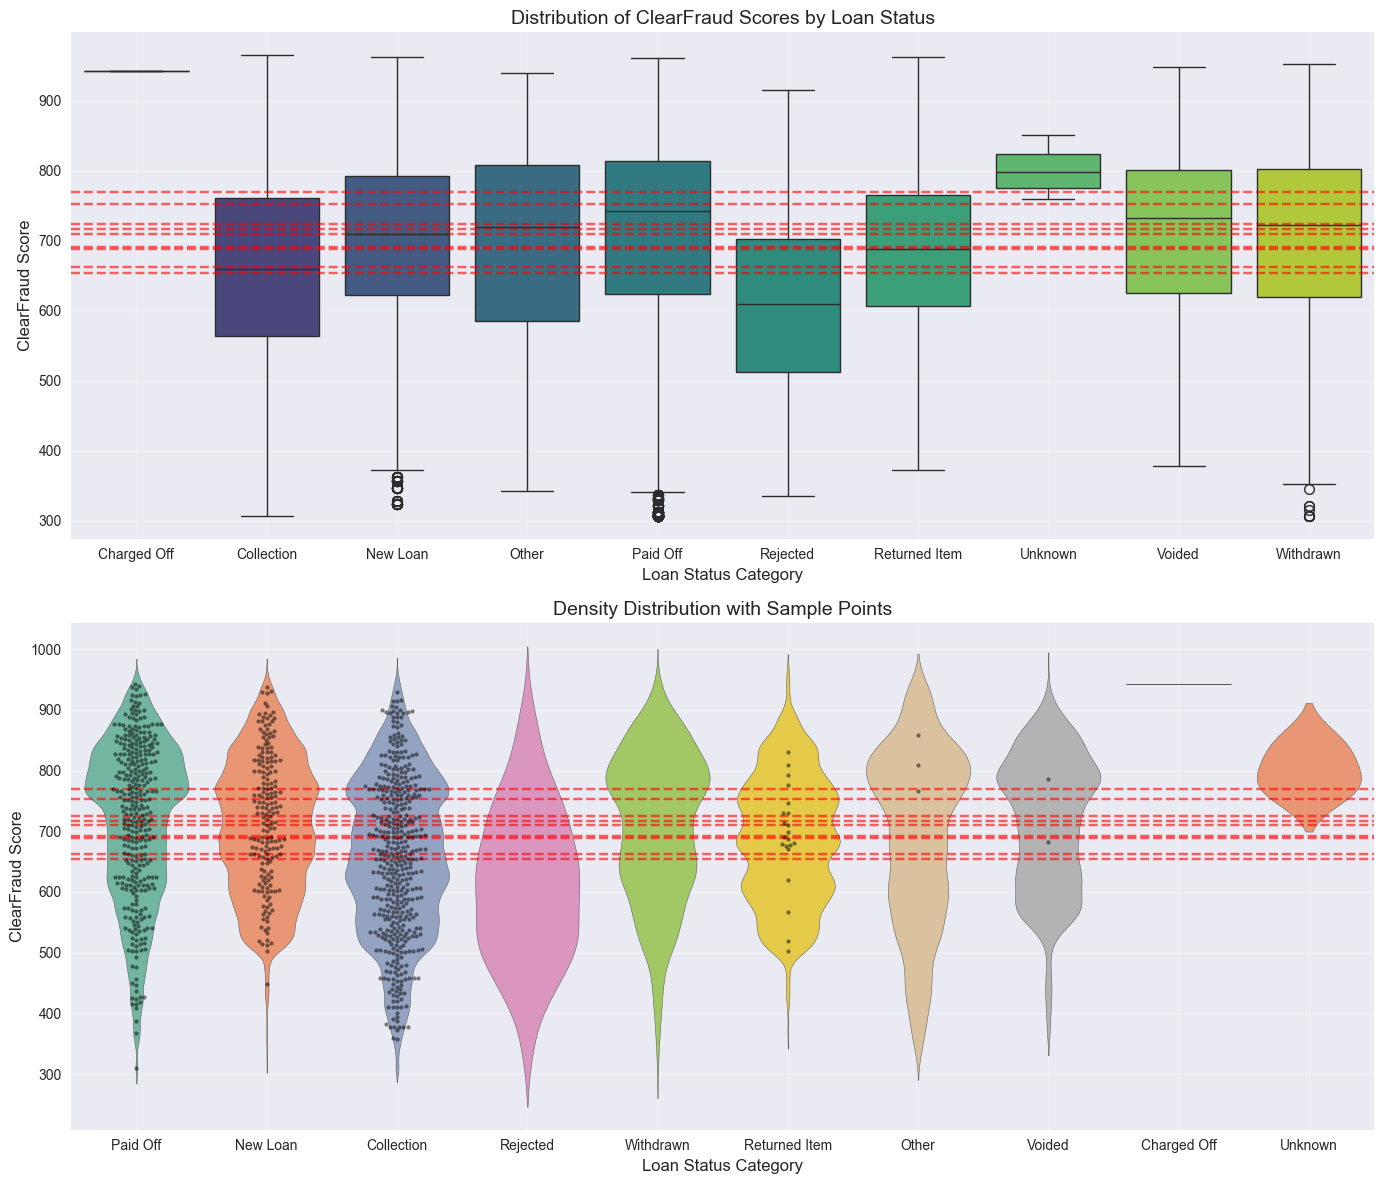

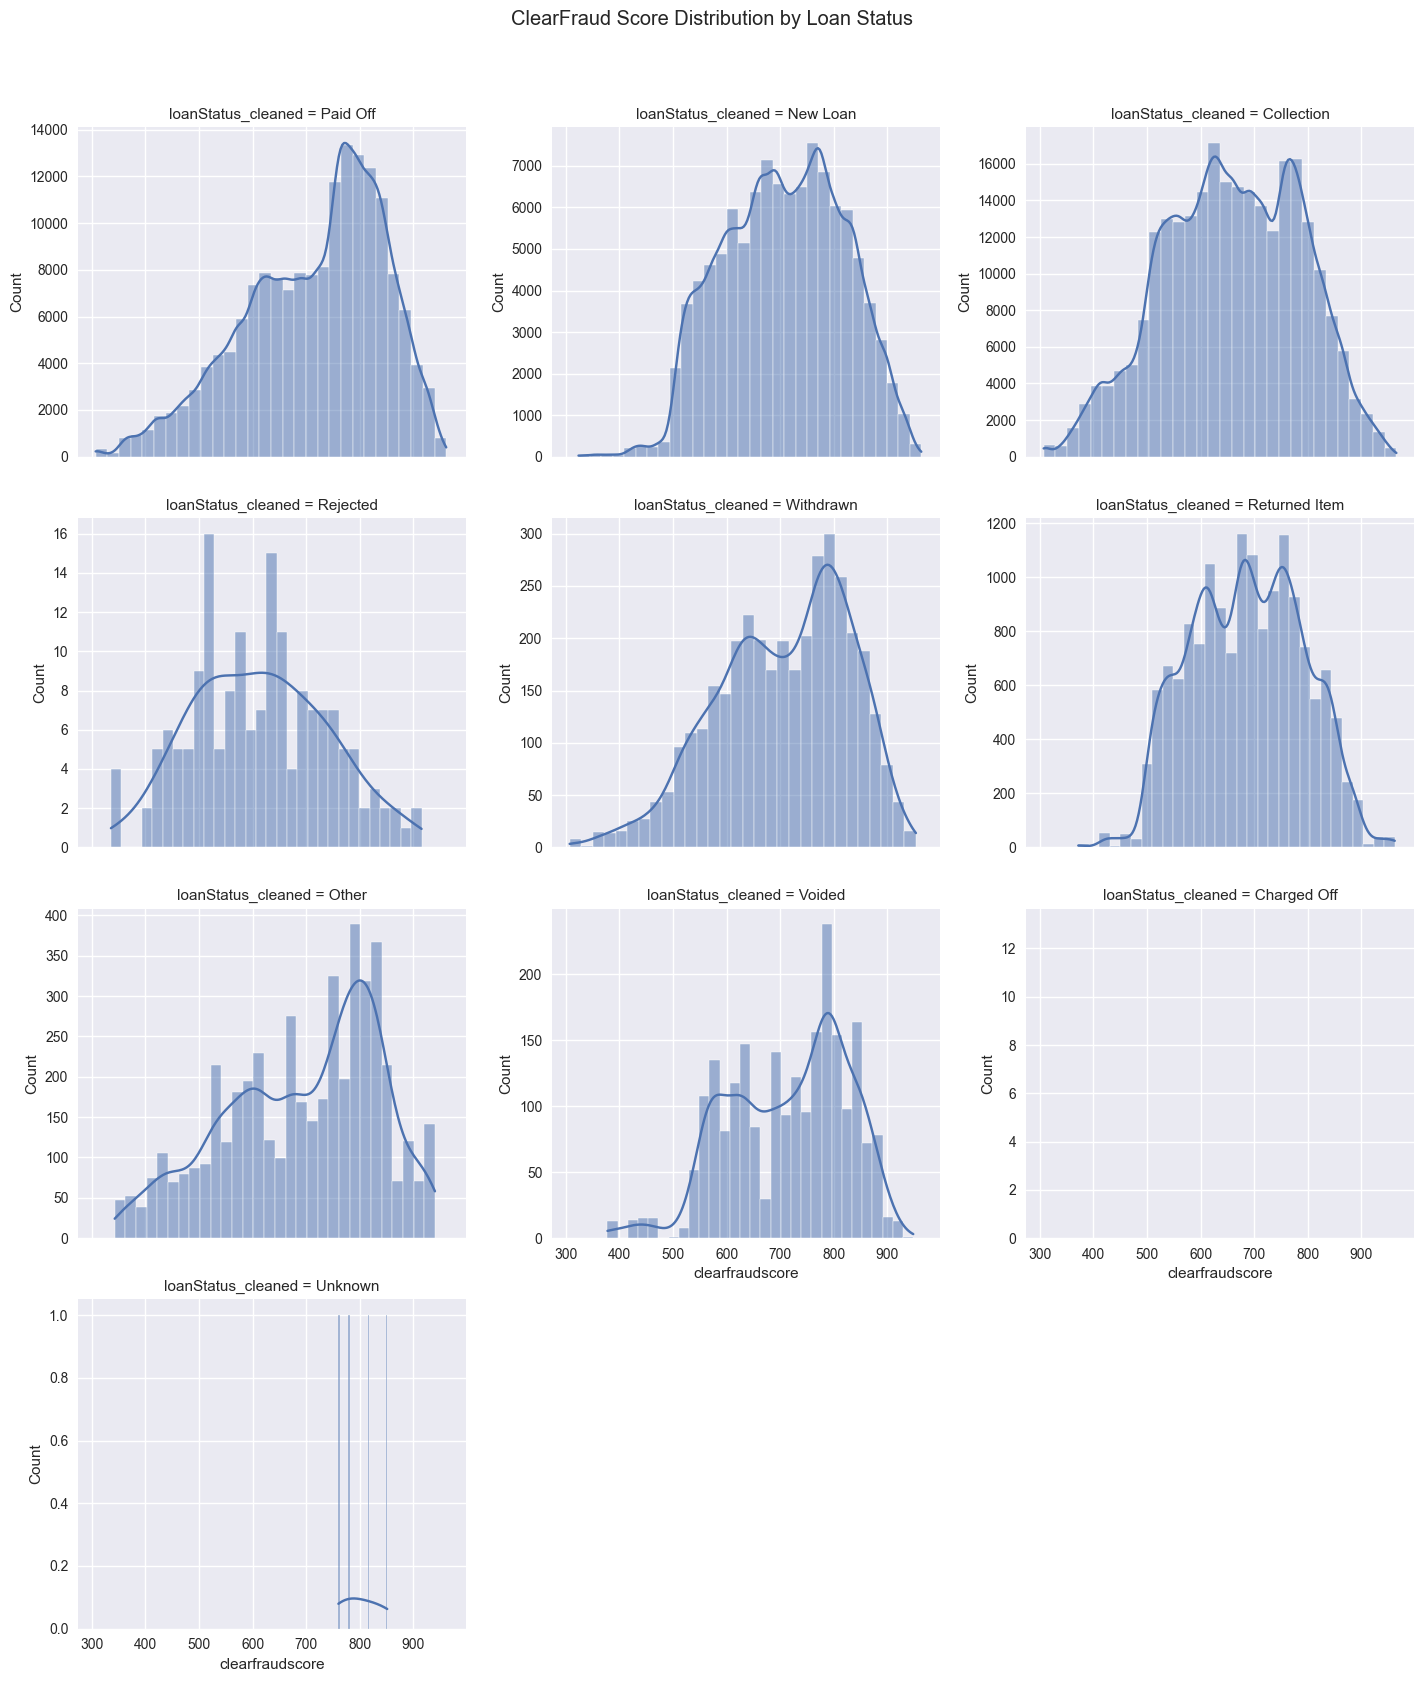


Suggested Fraud Score Decision Boundaries:
Between Status Charged Off and Collection: ≈753.00
Between Status Collection and New Loan: ≈691.50
Between Status New Loan and Other: ≈688.50
Between Status Other and Paid Off: ≈716.50
Between Status Paid Off and Rejected: ≈663.25
Between Status Rejected and Returned Item: ≈654.75
Between Status Returned Item and Unknown: ≈770.38
Between Status Unknown and Voided: ≈724.50
Between Status Voided and Withdrawn: ≈710.12


In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set style (updated to use valid style)
plt.style.use('seaborn-v0_8')  # Modern seaborn style
plt.rcParams['figure.figsize'] = (12, 8)

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# 1. Boxplot - Shows distribution of fraud scores per category
sns.boxplot(
    x='loanStatus_cleaned', 
    y='clearfraudscore', 
    data=loan_full,
    ax=ax1,
    order=sorted(loan_full['loanStatus_cleaned'].unique()),
    palette='viridis'
)
ax1.set_title('Distribution of ClearFraud Scores by Loan Status', fontsize=14)
ax1.set_xlabel('Loan Status Category', fontsize=12)
ax1.set_ylabel('ClearFraud Score', fontsize=12)
ax1.grid(True, alpha=0.3)

# 2. Violin + Swarm plot - Shows density and individual points
sns.violinplot(
    x='loanStatus_cleaned',
    y='clearfraudscore',
    data=loan_full,
    inner=None,
    ax=ax2,
    palette='Set2'
)
sns.swarmplot(
    x='loanStatus_cleaned',
    y='clearfraudscore',
    data=loan_full.sample(1000) if len(loan_full) > 1000 else loan_full,  # Safe sampling
    color='black',
    alpha=0.5,
    size=3,
    ax=ax2
)
ax2.set_title('Density Distribution with Sample Points', fontsize=14)
ax2.set_xlabel('Loan Status Category', fontsize=12)
ax2.set_ylabel('ClearFraud Score', fontsize=12)
ax2.grid(True, alpha=0.3)

# Calculate decision boundaries without importance_df
status_codes = sorted(loan_full['loanStatus_cleaned'].unique())
percentiles = []

for i in range(len(status_codes)-1):
    lower = loan_full[loan_full['loanStatus_cleaned'] == status_codes[i]]['clearfraudscore'].quantile(0.75)
    upper = loan_full[loan_full['loanStatus_cleaned'] == status_codes[i+1]]['clearfraudscore'].quantile(0.25)
    boundary = (lower + upper) / 2
    percentiles.append(boundary)
    
    for ax in [ax1, ax2]:
        ax.axhline(
            y=boundary, 
            color='red', 
            linestyle='--', 
            alpha=0.6,
            label=f'Boundary {i+1}' if ax == ax1 else ''
        )

plt.tight_layout()
plt.legend()
plt.show()

# 3. Histogram Facet Grid - Detailed distribution
g = sns.FacetGrid(
    loan_full, 
    col='loanStatus_cleaned', 
    col_wrap=3, 
    height=4, 
    aspect=1.2,
    sharey=False
)
g.map(sns.histplot, 'clearfraudscore', kde=True, bins=30)
g.fig.suptitle('ClearFraud Score Distribution by Loan Status', y=1.05)
plt.show()

# 4. Print suggested decision boundaries
print("\nSuggested Fraud Score Decision Boundaries:")
for i, boundary in enumerate(percentiles):
    print(f"Between Status {status_codes[i]} and {status_codes[i+1]}: ≈{boundary:.2f}")

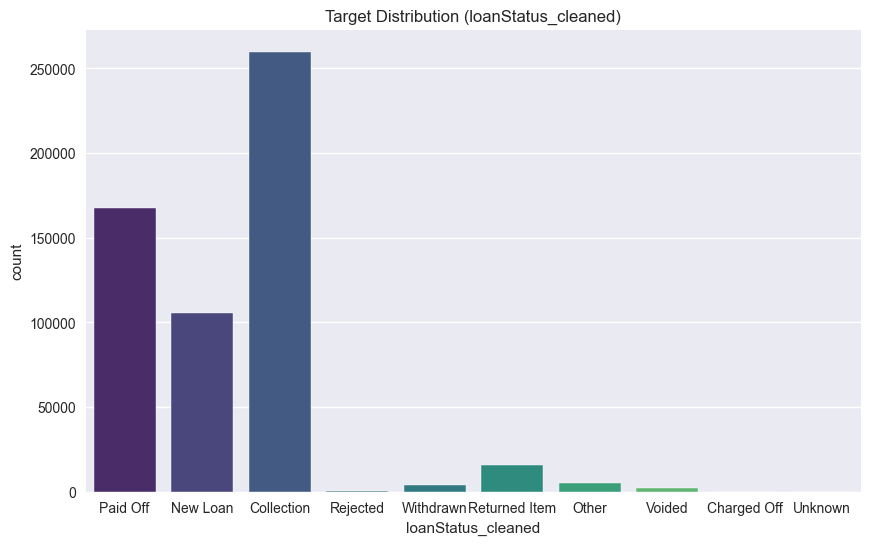

In [100]:
# 3. Target Distribution (Loan Status)
plt.figure(figsize=(10, 6))
sns.countplot(x='loanStatus_cleaned', data=loan_full, palette='viridis')
plt.title('Target Distribution (loanStatus_cleaned)')
plt.show()

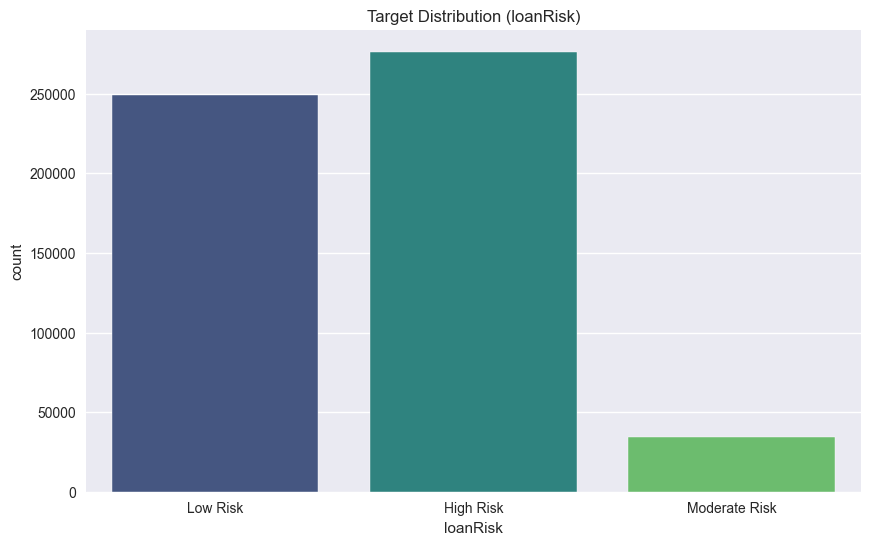

In [101]:
# 4. Target Distribution (Loan Status)
plt.figure(figsize=(10, 6))
sns.countplot(x='loanRisk', data=loan_full, palette='viridis')
plt.title('Target Distribution (loanRisk)')
plt.show()

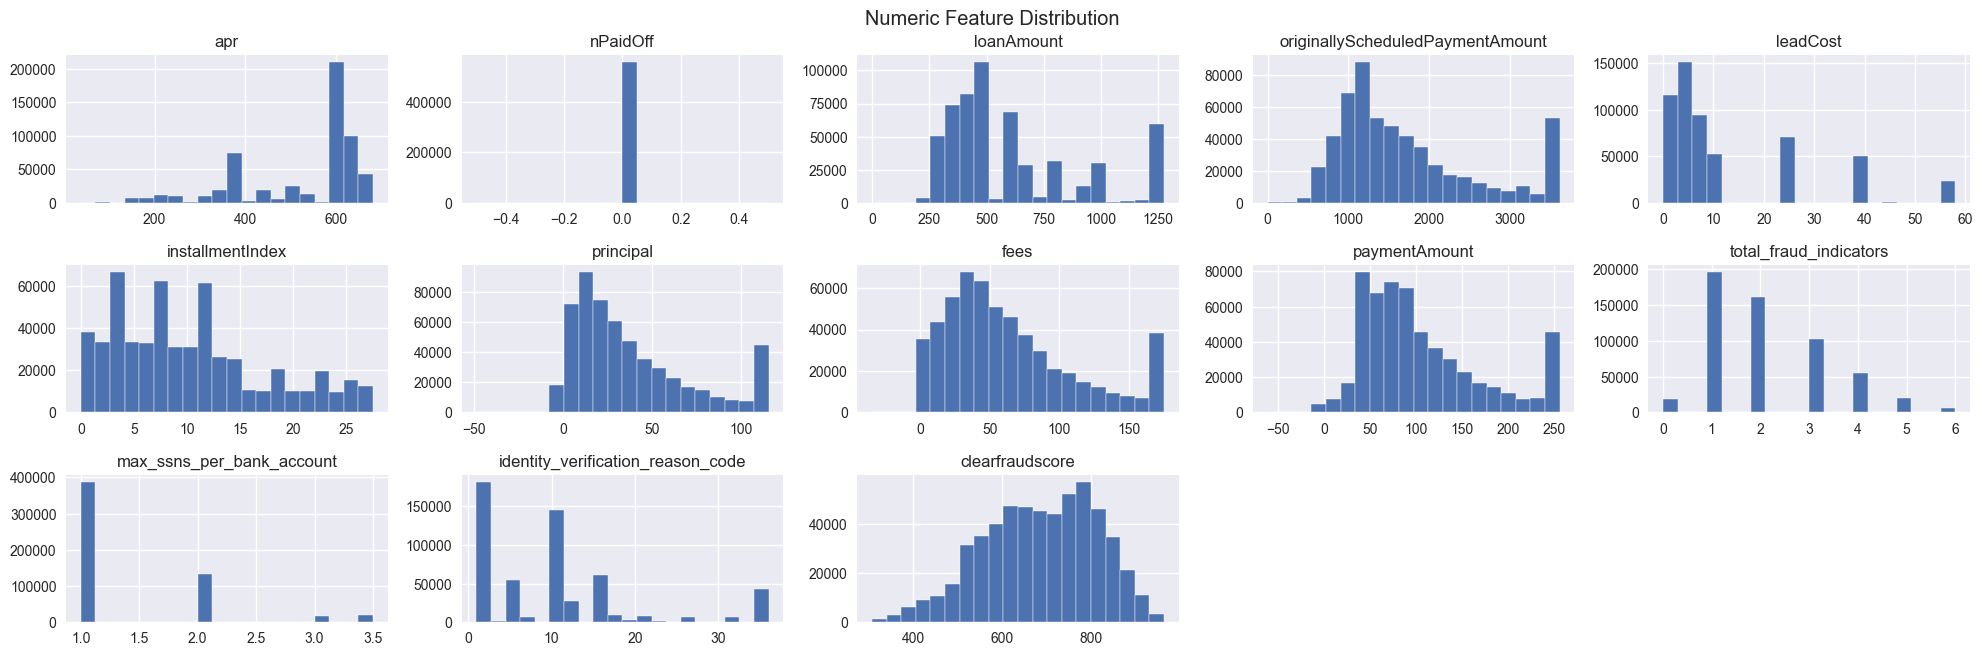

In [102]:
# 5. Numeric Feature Distribution
numeric_columns = loan_full.select_dtypes(include=['int64', 'float64']).columns
loan_full[numeric_columns].hist(bins=20, figsize=(20, 15), layout=(7, 5))
plt.suptitle('Numeric Feature Distribution')
plt.tight_layout()
plt.show()


=== Skipped Columns (Too Many Unique Values) ===
loanId: 36116 unique values
anon_ssn: 30854 unique values
state: 41 unique values
clarityFraudId: 31639 unique values


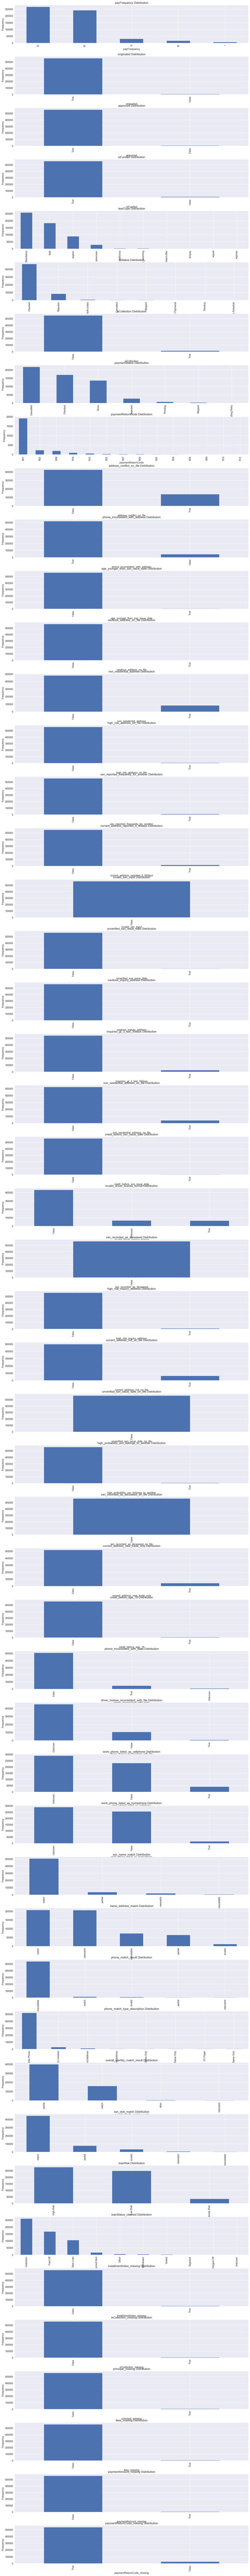

In [103]:
# 6. Categorical Feature Distribution
categorical_columns = loan_full.select_dtypes(include=['object', 'category', 'bool']).columns
valid_columns = []
skipped_columns = []

for col in categorical_columns:
    unique_count = loan_full[col].nunique()
    if unique_count <= 20:
        valid_columns.append(col)
    else:
        skipped_columns.append((col, unique_count))

# Display skipped columns and reasons
if skipped_columns:
    print("\n=== Skipped Columns (Too Many Unique Values) ===")
    for col, count in skipped_columns:
        print(f"{col}: {count} unique values")

# Plotting only valid columns
fig, axes = plt.subplots(len(valid_columns), 1, figsize=(15, len(valid_columns) * 3))
fig.tight_layout(pad=3.0)

for i, col in enumerate(valid_columns):
    loan_full[col].value_counts().head(20).plot(kind='bar', ax=axes[i] if len(valid_columns) > 1 else axes)
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.show()



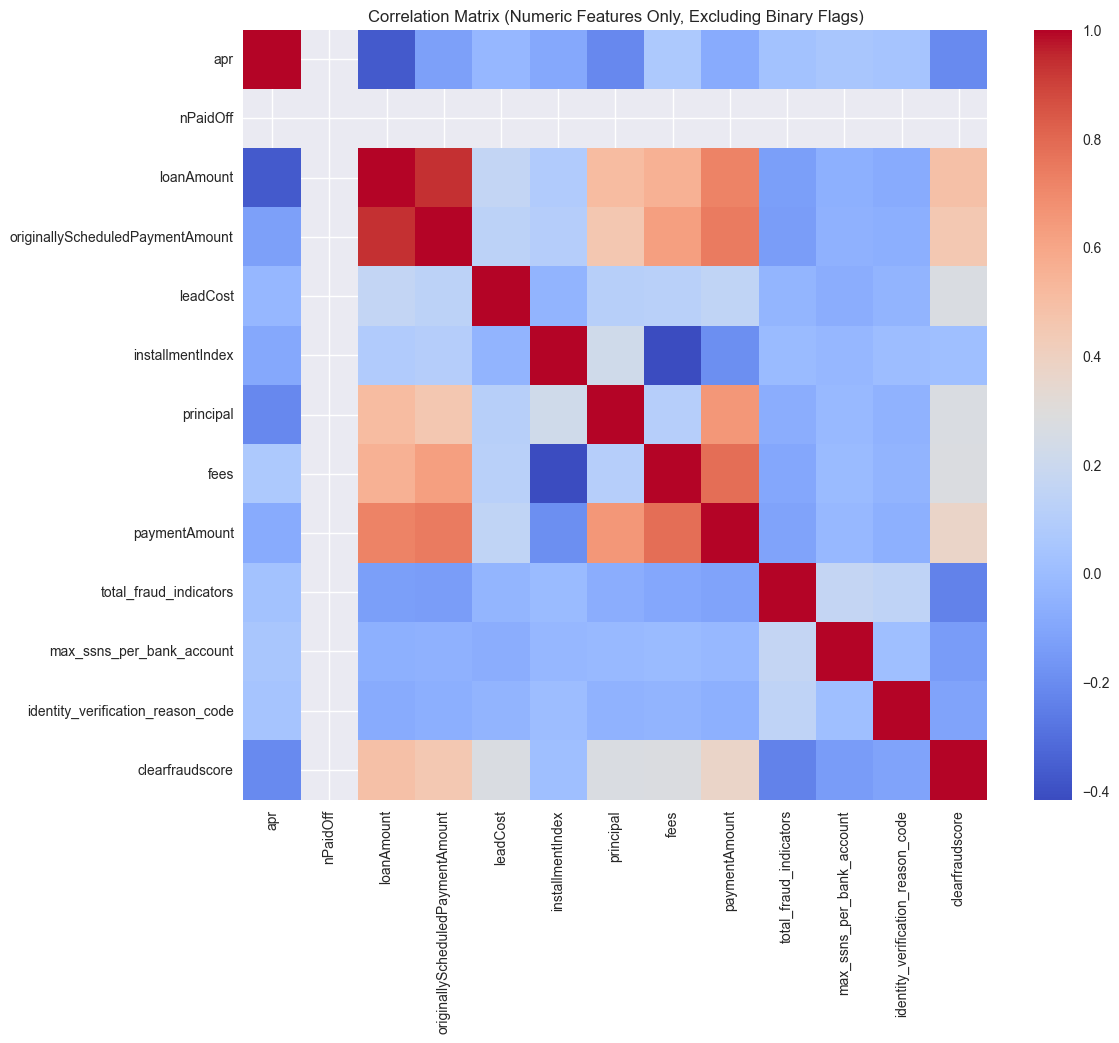

In [104]:
# Identifying binary columns (0/1)
binary_columns = [col for col in loan_full.columns if loan_full[col].nunique() == 2]

# Identifying numeric columns excluding binary
numeric_columns = loan_full.select_dtypes(include=['int64', 'float64']).columns
numeric_columns = [col for col in numeric_columns if col not in binary_columns]

# Correlation Analysis without binary columns
correlation_matrix = loan_full[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix (Numeric Features Only, Excluding Binary Flags)')
plt.show()


In [105]:
loan_full['loanStatus_cleaned'].info()

<class 'pandas.core.series.Series'>
Index: 559592 entries, 1 to 1226818
Series name: loanStatus_cleaned
Non-Null Count   Dtype 
--------------   ----- 
559592 non-null  object
dtypes: object(1)
memory usage: 24.7+ MB


In [106]:
# Convert target column to string (to preserve all categories)
loan_full['loanStatus_cleaned'] = loan_full['loanStatus_cleaned'].astype(str)


In [107]:
# from sklearn.preprocessing import LabelEncoder
# import pandas as pd

# # 1. Checking unique values
# print("Unique values in loanRisk:", loan_full['loanRisk'].unique())

# # 2. Label Encoding (for tree-based models)
# # Initialize LabelEncoder
# le = LabelEncoder()

# # Apply LabelEncoder to the target column
# loan_full['loanRisk'] = le.fit_transform(loan_full['loanRisk'])

# # Display encoded values
# print(dict(zip(le.classes_, le.transform(le.classes_))))




In [108]:
def cap_outliers_iqr(loan_full, columns):
    """
    Caps extreme values using the IQR method.

    Parameters:
        loan_full (pd.DataFrame): The DataFrame containing the numeric columns.
        columns (list): List of column names to cap outliers.

    Returns:
        pd.DataFrame: DataFrame with capped outliers.
    """
    for col in columns:
        Q1 = loan_full[col].quantile(0.25)
        Q3 = loan_full[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_cap = Q1 - 1.5 * IQR
        upper_cap = Q3 + 1.5 * IQR
        
        # Cap values
        loan_full[col] = loan_full[col].apply(lambda x: lower_cap if x < lower_cap else (upper_cap if x > upper_cap else x))
        print(f"{col} - Lower Cap: {lower_cap}, Upper Cap: {upper_cap}")

    return loan_full

# Usage
numeric_columns = loan_full.select_dtypes(include=['int64', 'float64']).columns
loan_full = cap_outliers_iqr(loan_full, numeric_columns)


apr - Lower Cap: 37.5, Upper Cap: 977.5
nPaidOff - Lower Cap: 0.0, Upper Cap: 0.0
loanAmount - Lower Cap: -125.0, Upper Cap: 1275.0
originallyScheduledPaymentAmount - Lower Cap: -423.5049999999999, Upper Cap: 3612.215
leadCost - Lower Cap: -30.0, Upper Cap: 58.0
installmentIndex - Lower Cap: -8.5, Upper Cap: 27.5
principal - Lower Cap: -48.63, Upper Cap: 115.37
fees - Lower Cap: -58.150000000000006, Upper Cap: 174.97
paymentAmount - Lower Cap: -61.690000000000005, Upper Cap: 255.67000000000002
total_fraud_indicators - Lower Cap: -2.0, Upper Cap: 6.0
max_ssns_per_bank_account - Lower Cap: -0.5, Upper Cap: 3.5
identity_verification_reason_code - Lower Cap: -20.0, Upper Cap: 36.0
clearfraudscore - Lower Cap: 307.5, Upper Cap: 1071.5


In [109]:
def outlier_analysis(loan_full, target_column):
    # Step 1: Separate binary (0/1) features from numerical
    numeric_columns = loan_full.select_dtypes(include=['int64', 'float64']).columns
    binary_mask = np.array([set(loan_full[col].dropna().unique()).issubset({0, 1}) for col in numeric_columns])  # Convert to NumPy array
    binary_features = numeric_columns[binary_mask].tolist()  # Features to reclassify as categorical
    true_numeric = numeric_columns[~binary_mask]             # Now works!

    # Step 2: Update categorical columns (include binary features)
    categorical_columns = loan_full.select_dtypes(include=['object', 'bool', 'category']).columns.union(binary_features)
    
    # --- Numerical Outlier Analysis (Excludes Binary 0/1) ---
    print("\n[INFO] Numerical Features Outlier Analysis")
    for col in true_numeric:
        plt.figure(figsize=(10, 5))
        sns.boxplot(x=target_column, y=col, data=loan_full)
        plt.title(f"{col} vs {target_column}")
        plt.tight_layout()
        plt.show()
    
    # --- Categorical Analysis (Includes Binary 0/1) ---
    print("\n[INFO] Categorical Features Analysis (Including Binary 0/1)")
    for col in categorical_columns:
        if loan_full[col].nunique() > 10:
            print(f"{col} has {loan_full[col].nunique()} unique values. Displaying Top 10.")
            top_10 = loan_full[col].value_counts().nlargest(10).index
            temp_df = loan_full[loan_full[col].isin(top_10)]
        else:
            temp_df = loan_full
        
        plt.figure(figsize=(10, 5))
        sns.countplot(x=col, data=temp_df, order=temp_df[col].value_counts().index, hue=target_column)
        plt.title(f"{col} vs {target_column}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


[INFO] Numerical Features Outlier Analysis


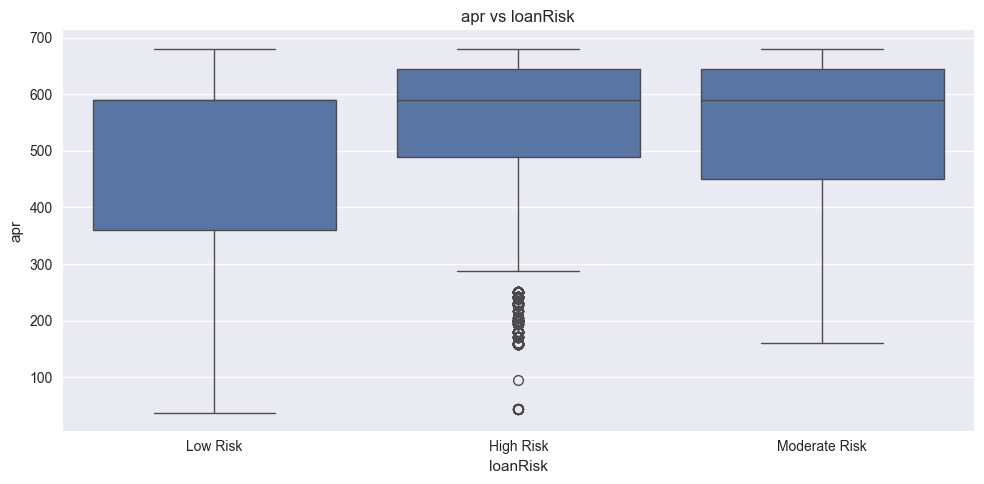

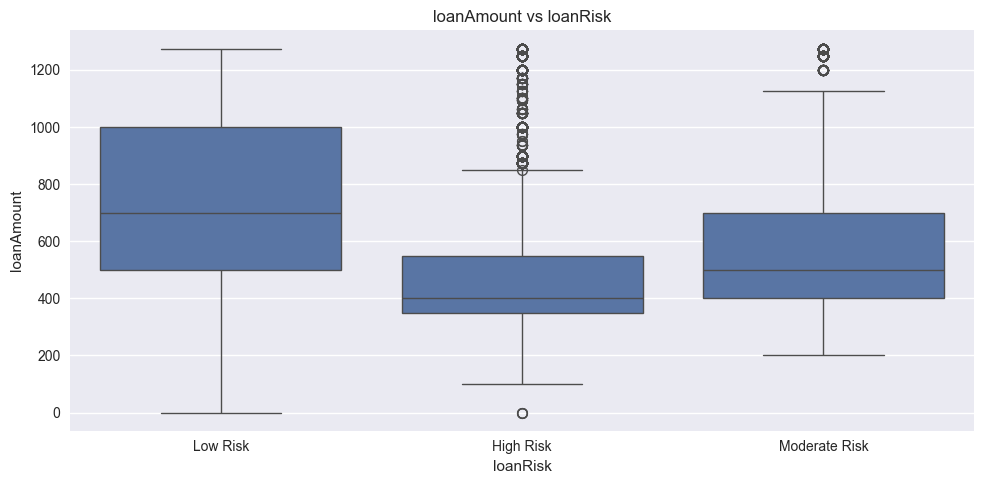

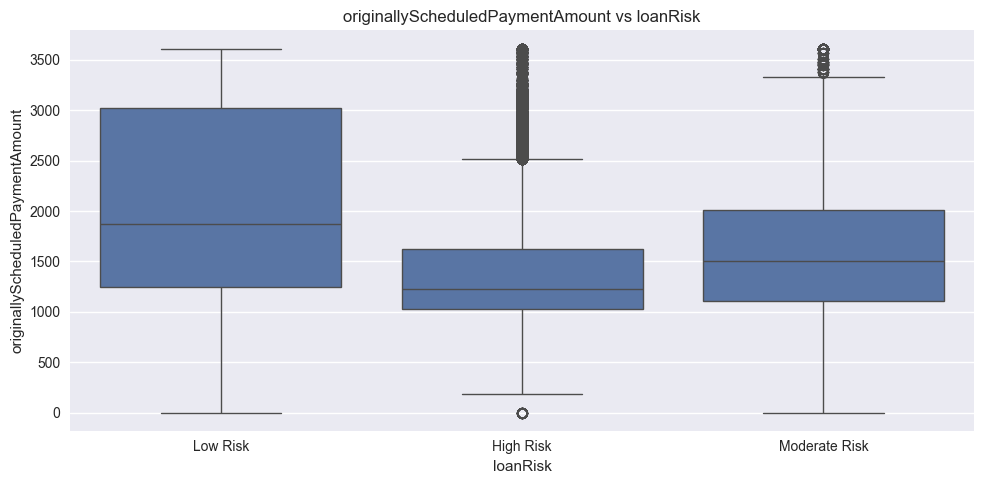

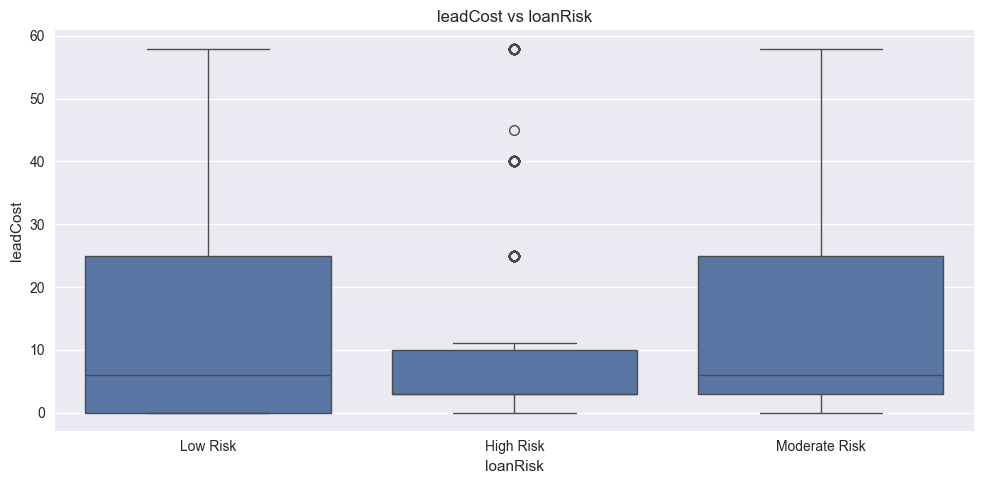

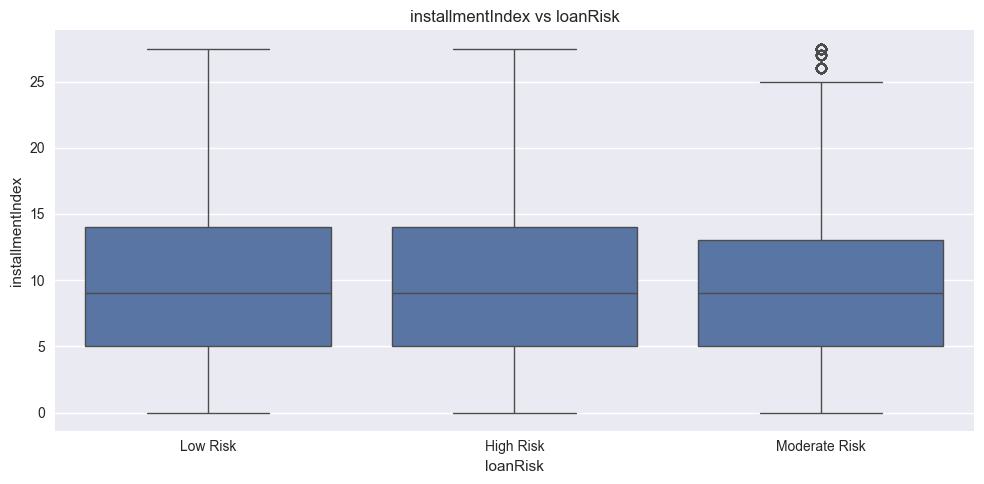

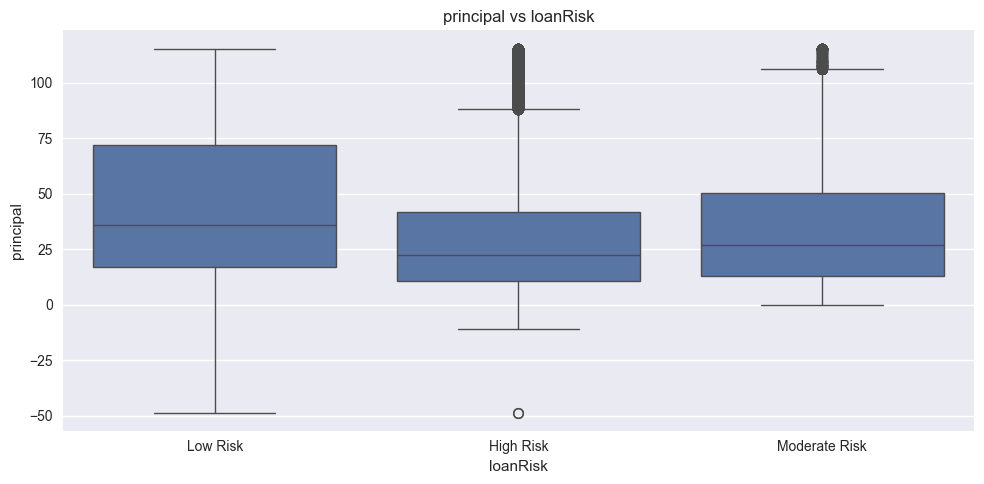

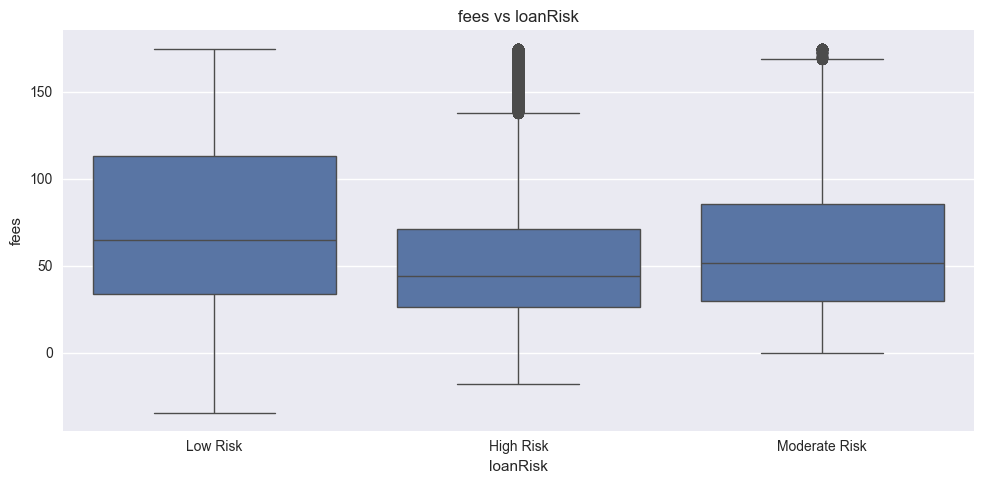

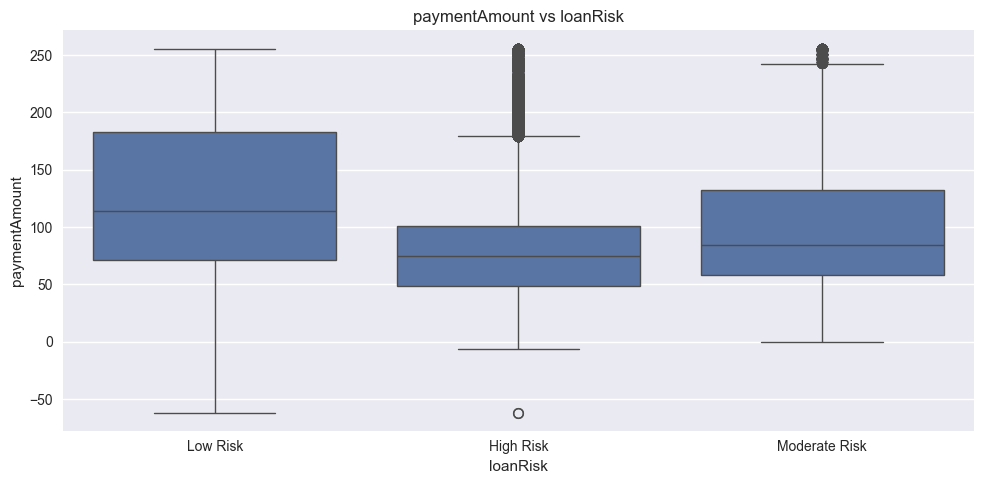

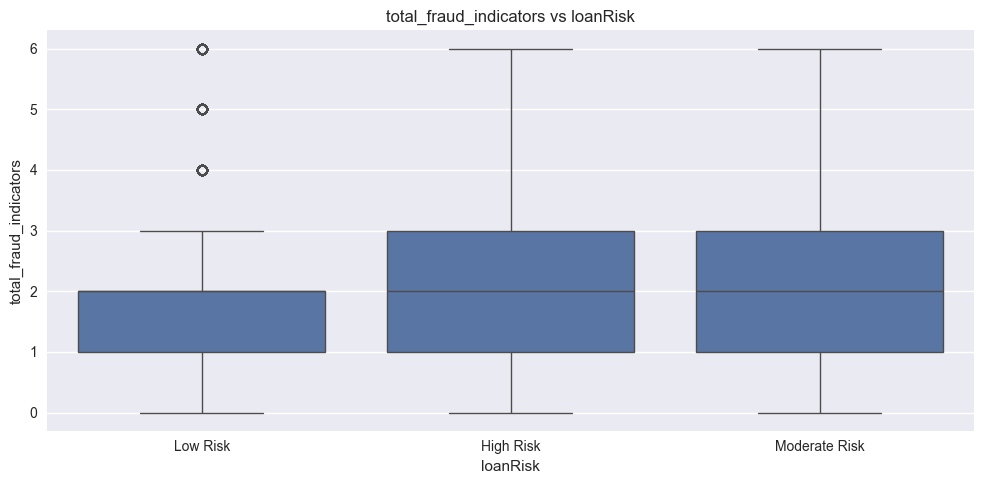

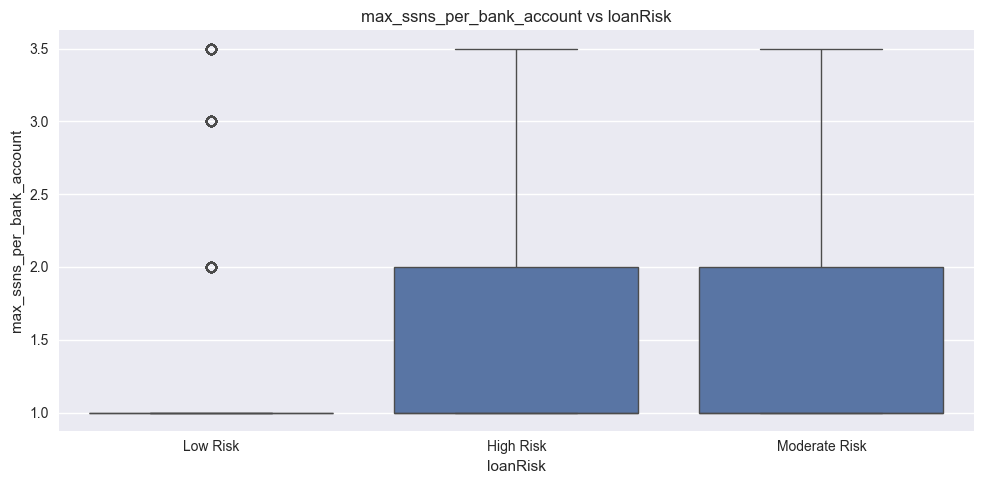

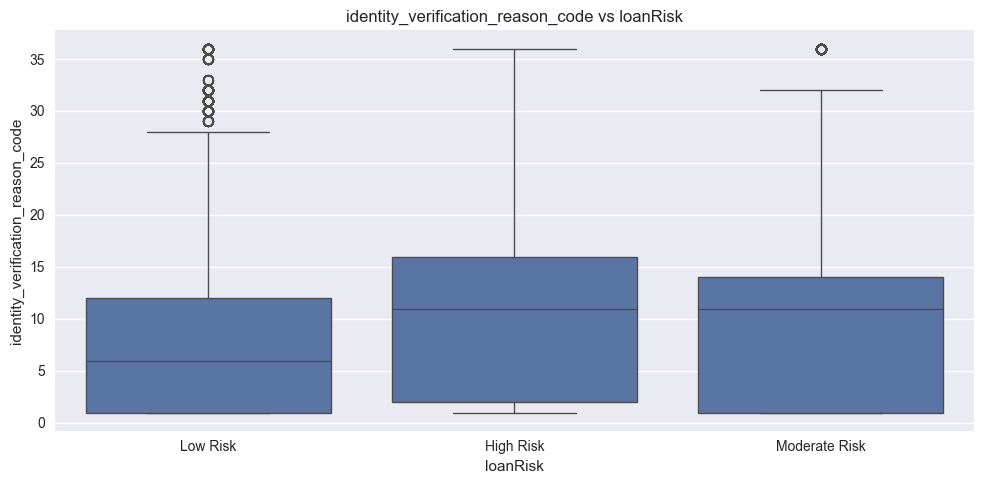

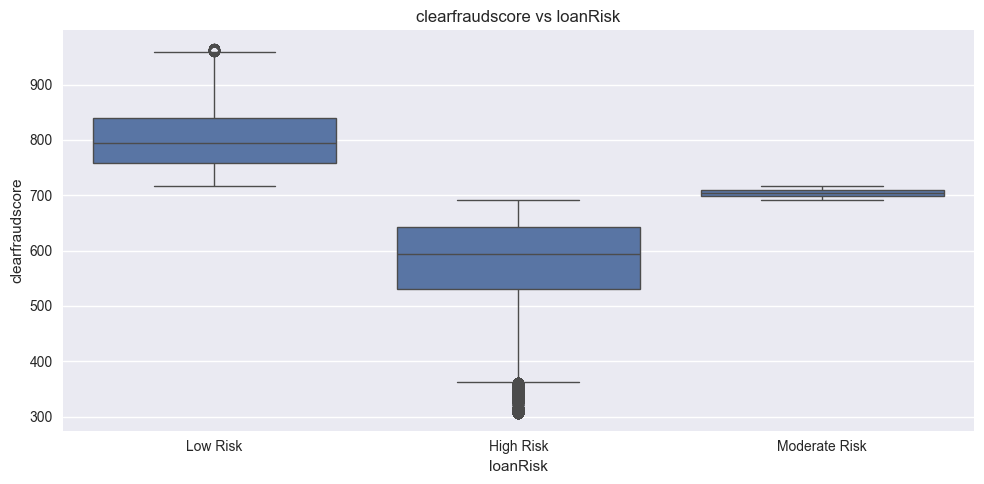


[INFO] Categorical Features Analysis (Including Binary 0/1)


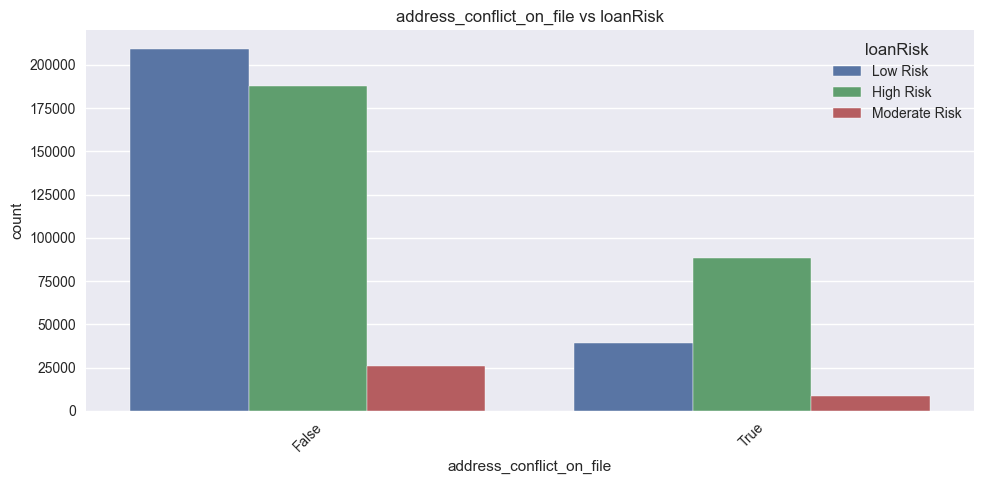

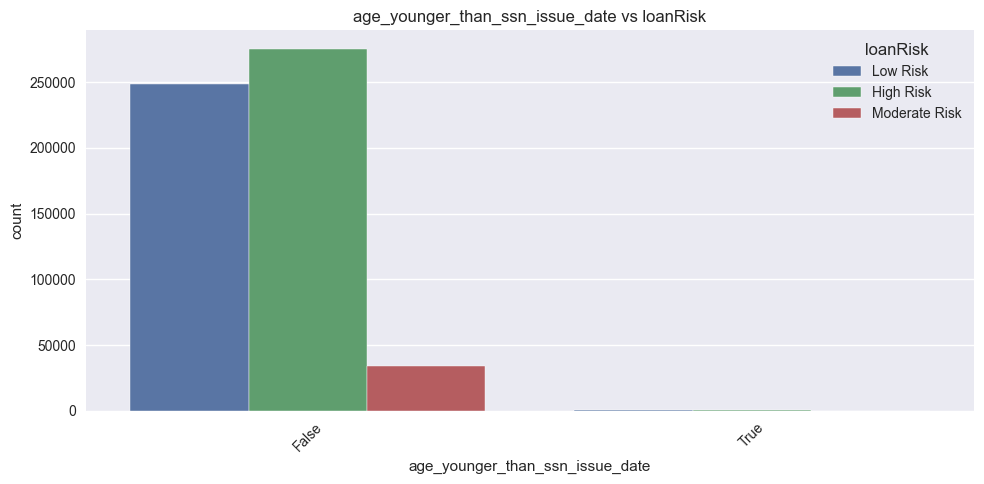

anon_ssn has 30854 unique values. Displaying Top 10.


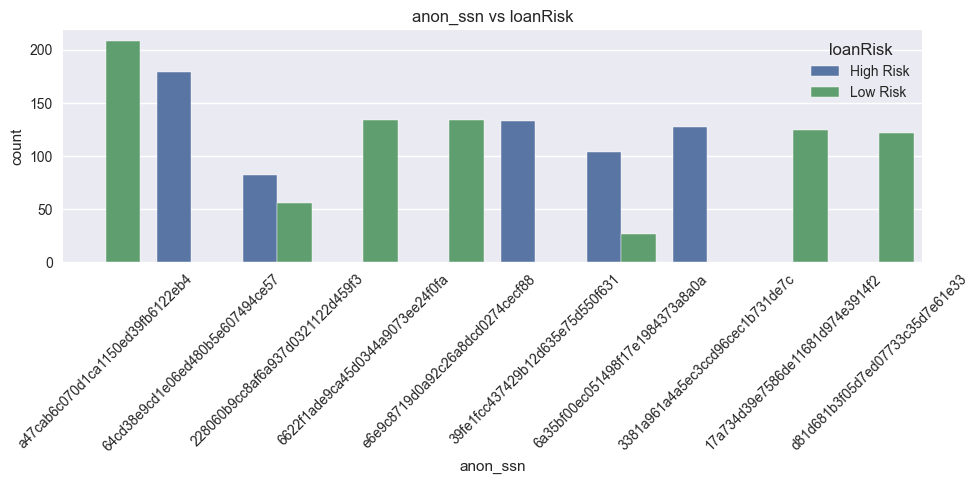

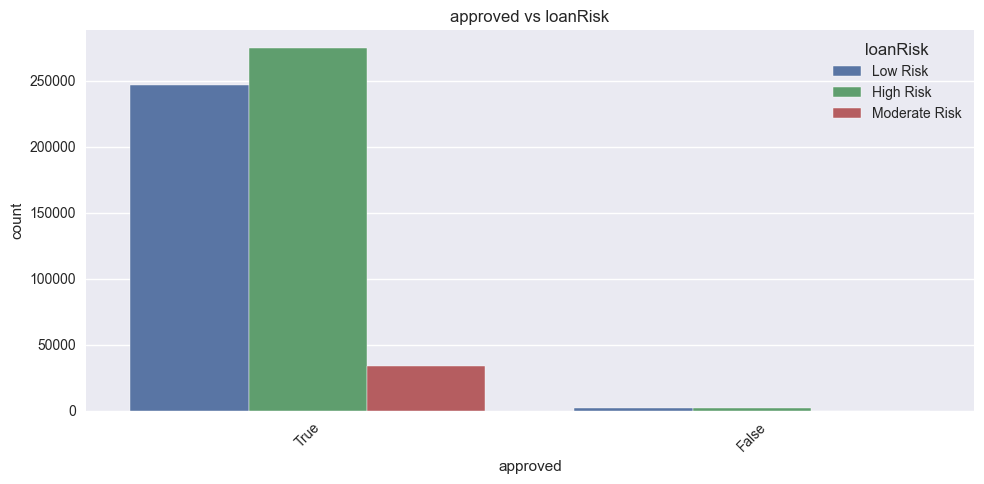

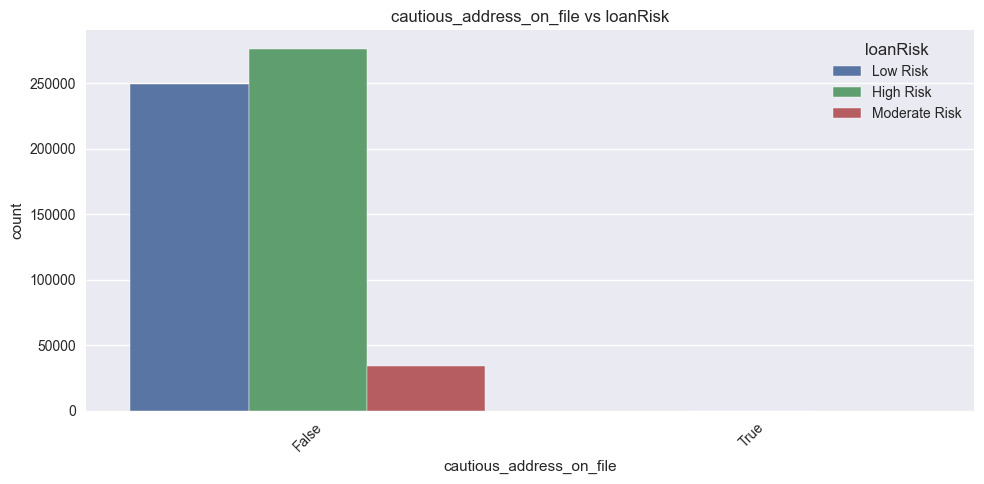

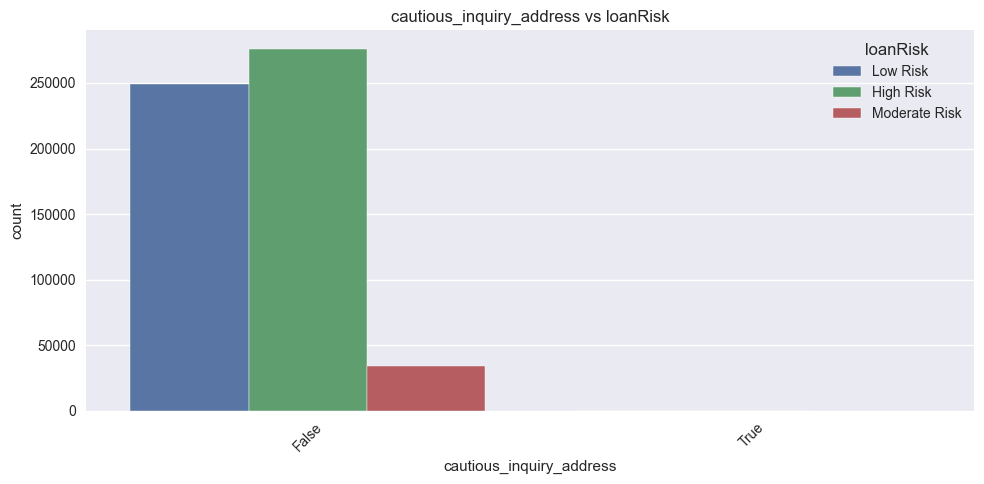

clarityFraudId has 31639 unique values. Displaying Top 10.


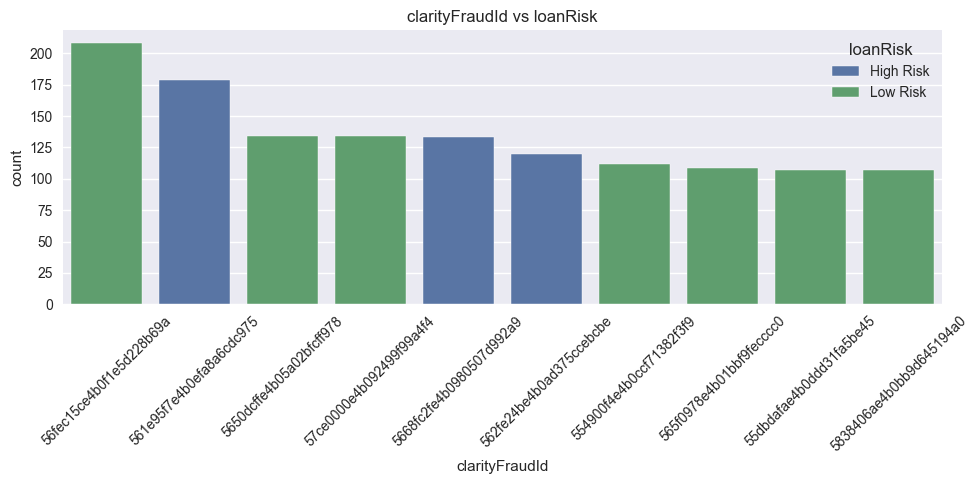

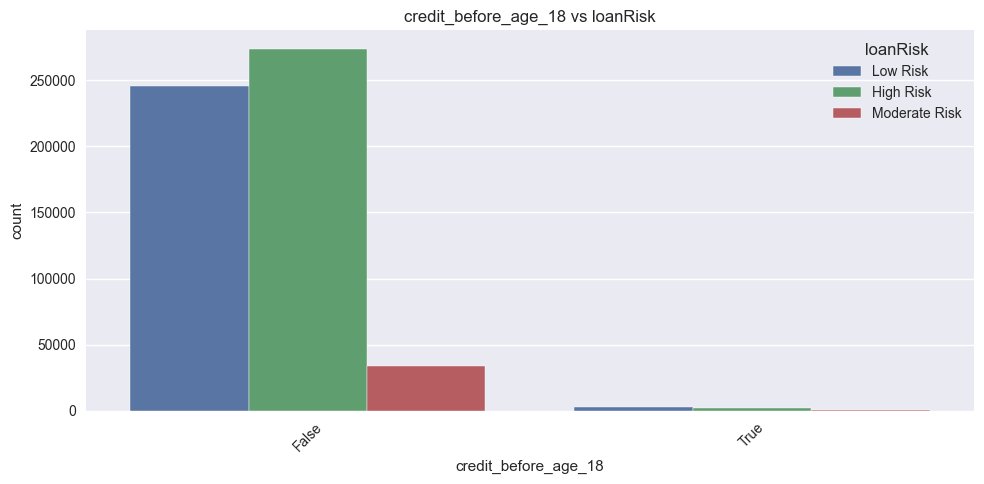

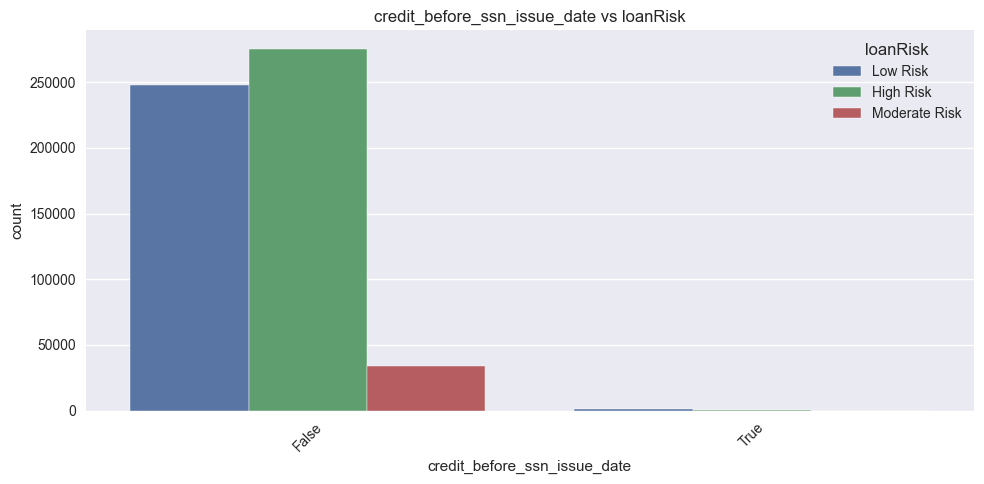

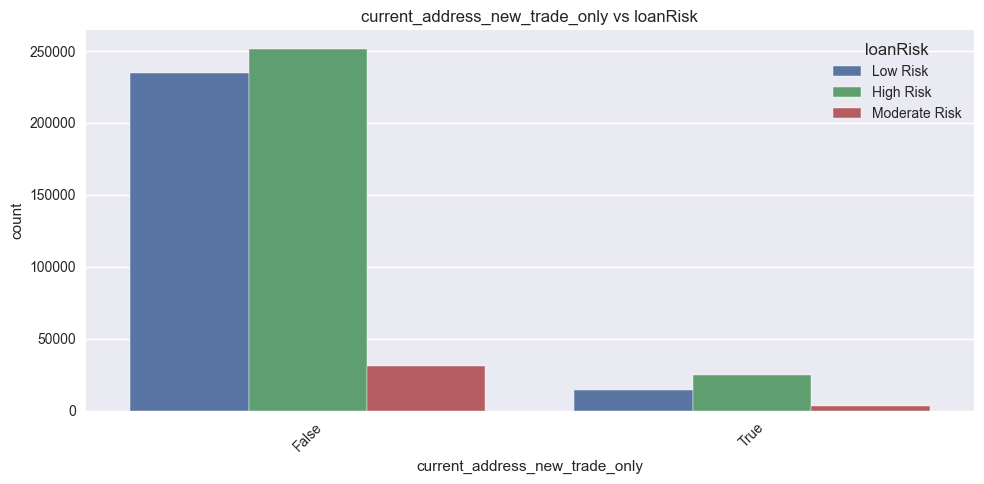

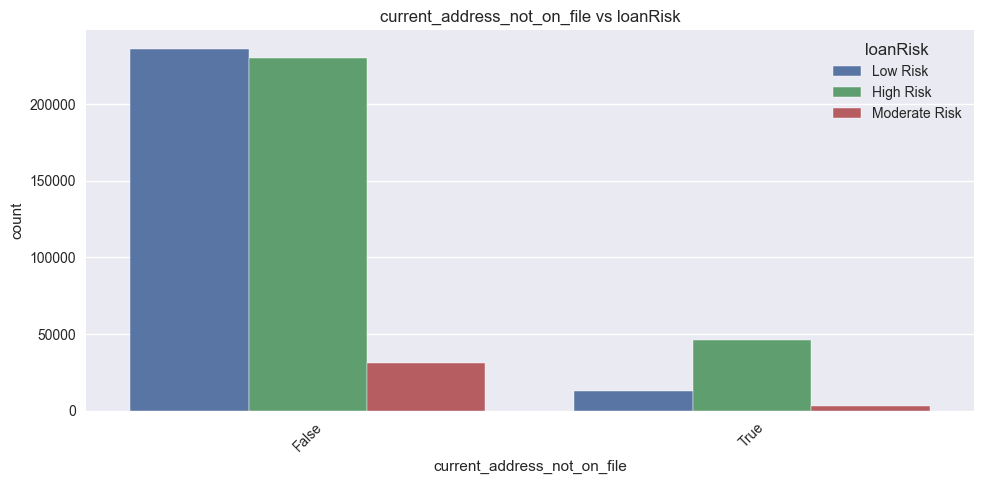

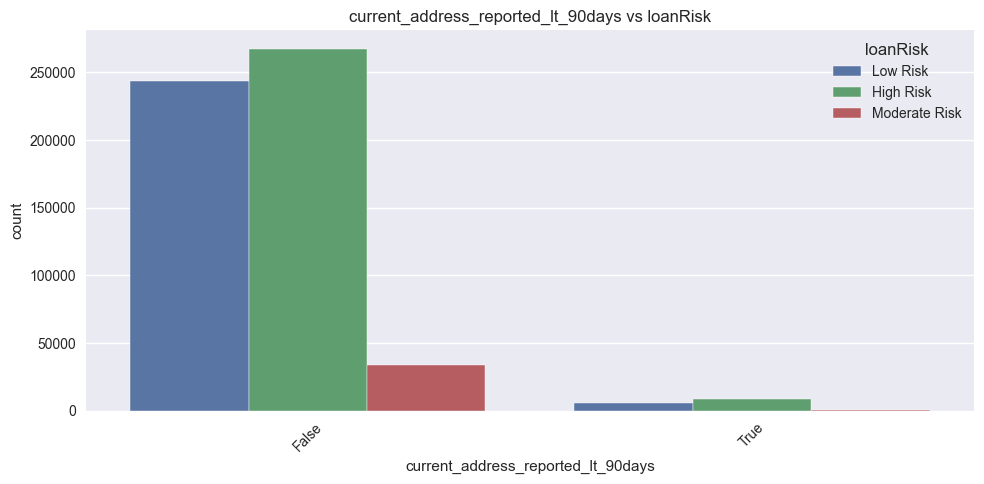

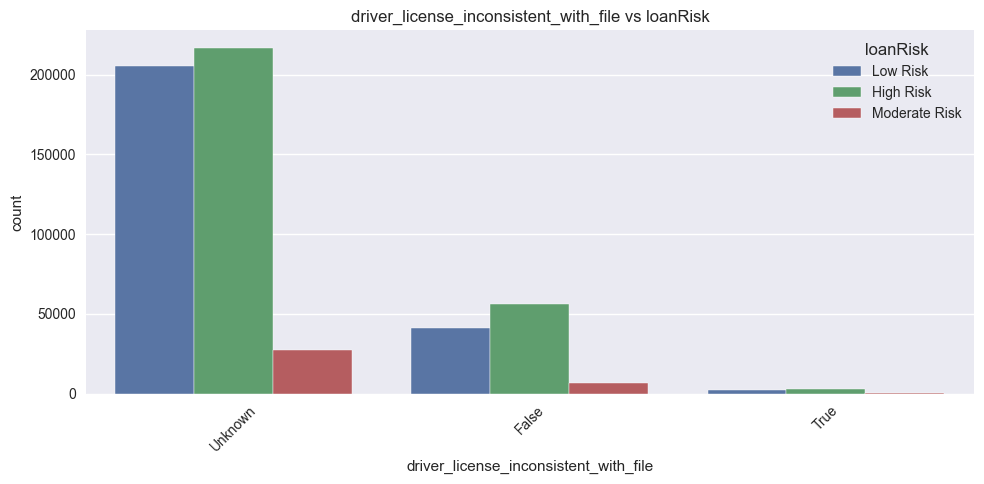

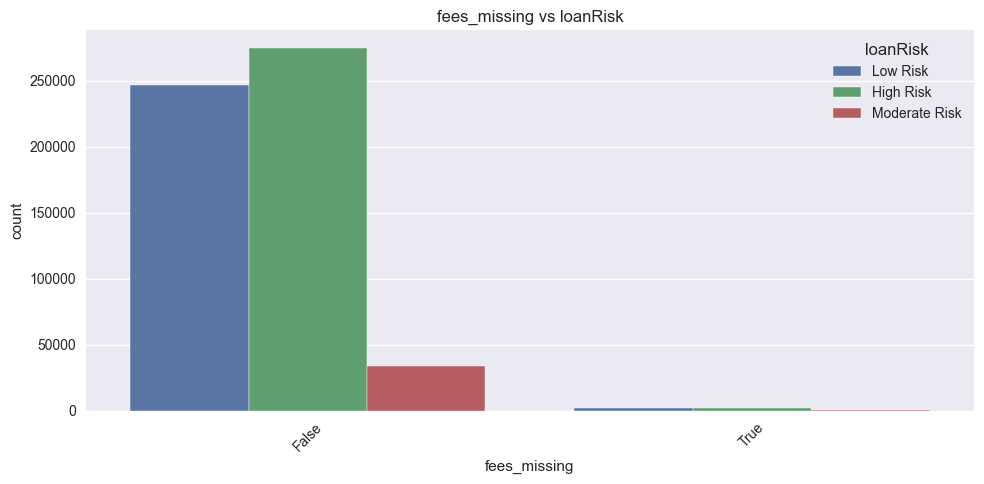

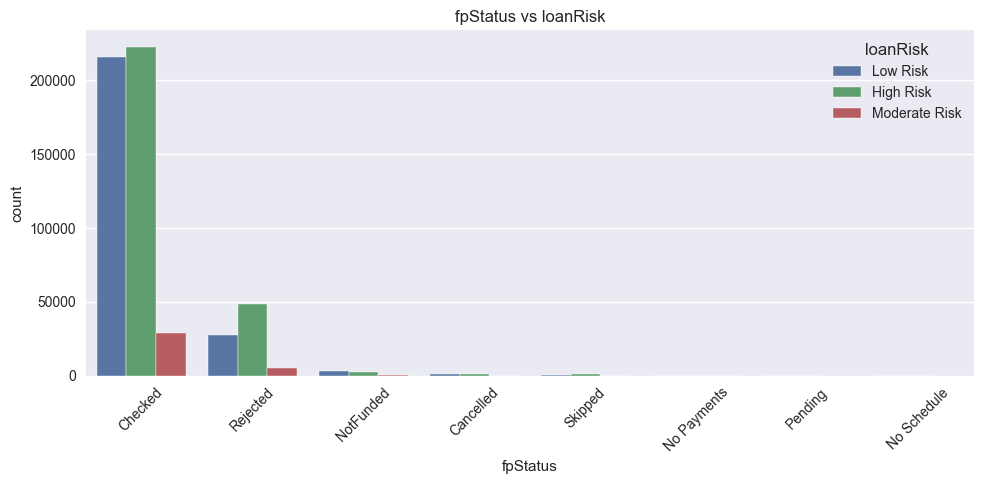

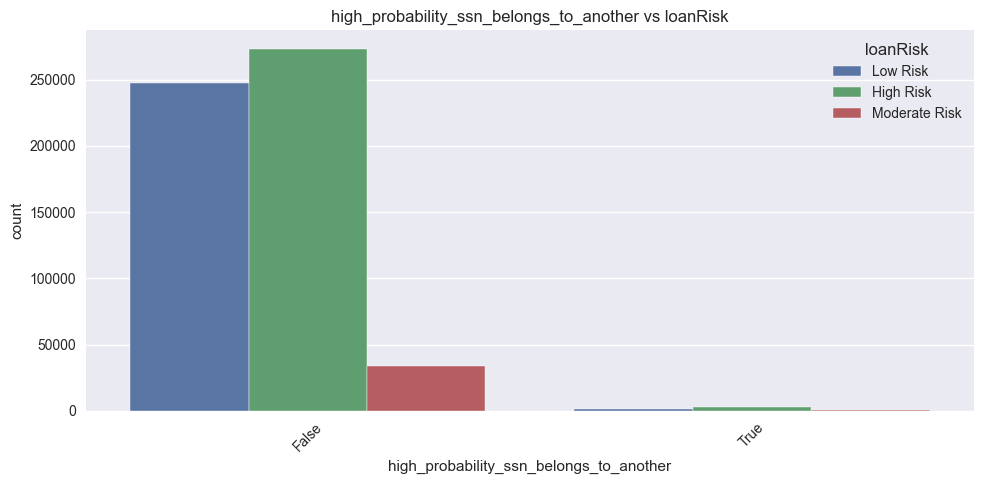

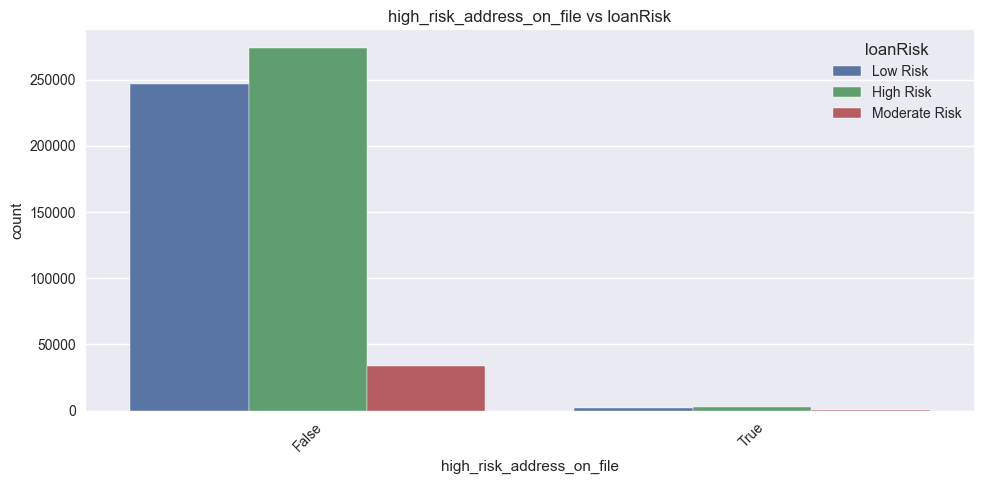

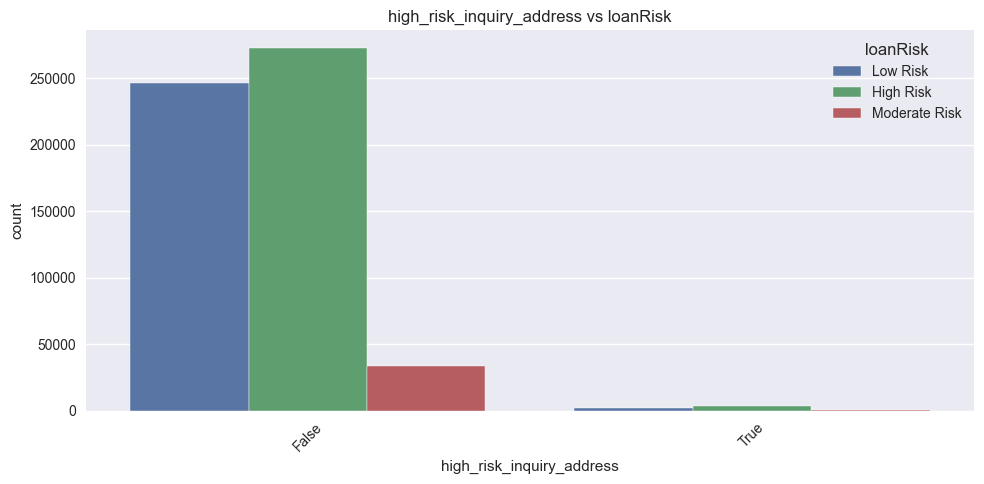

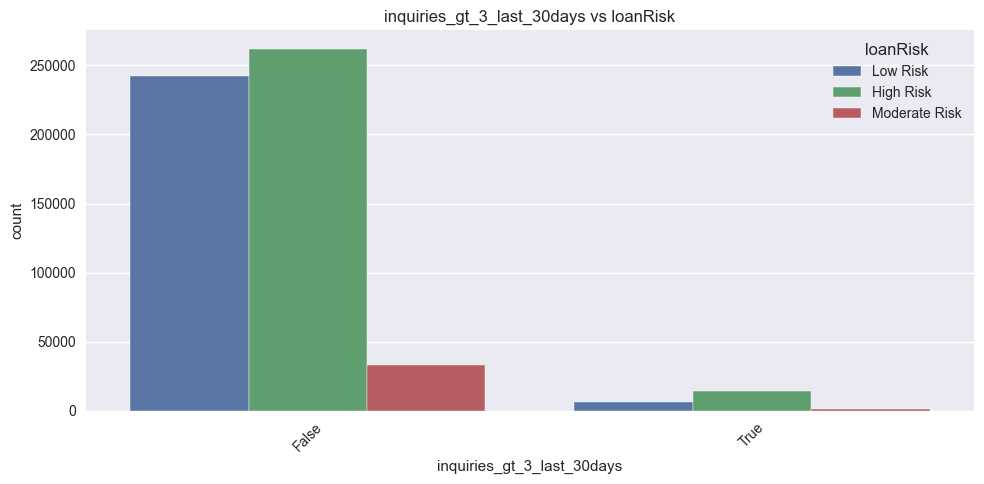

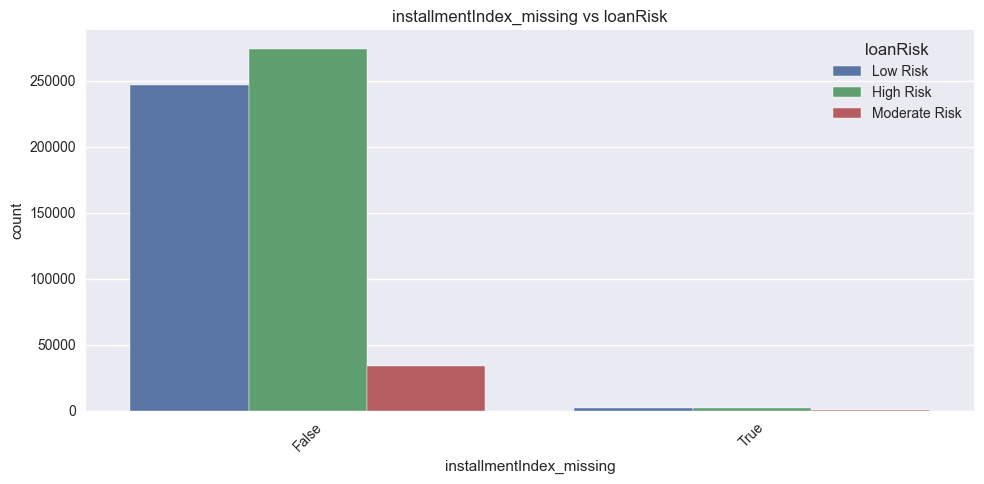

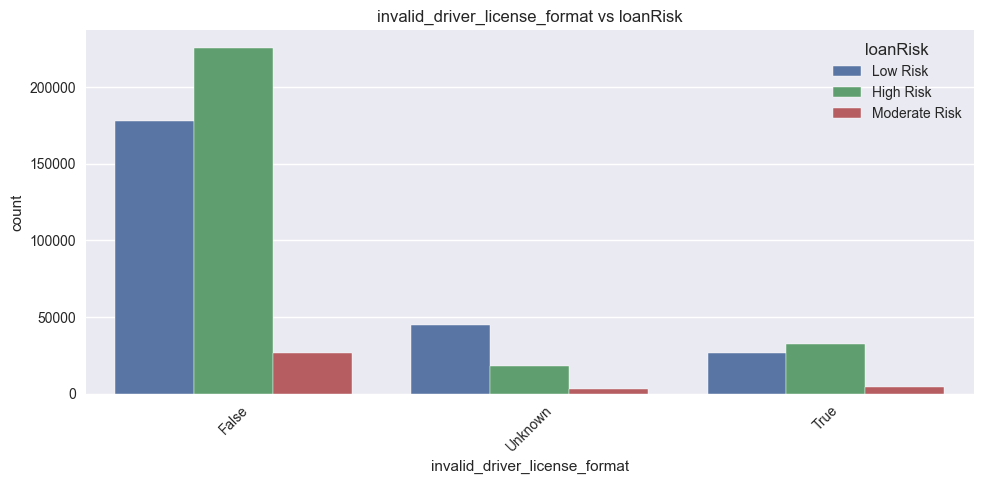

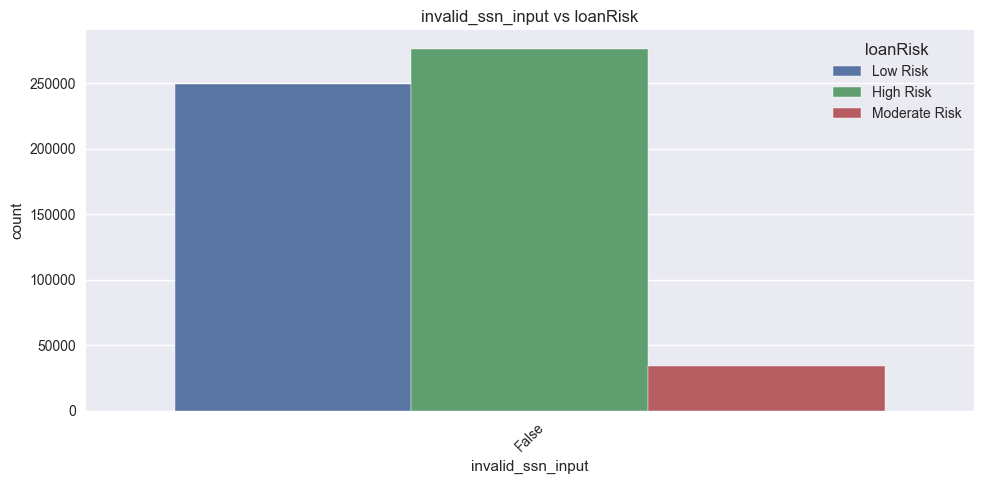

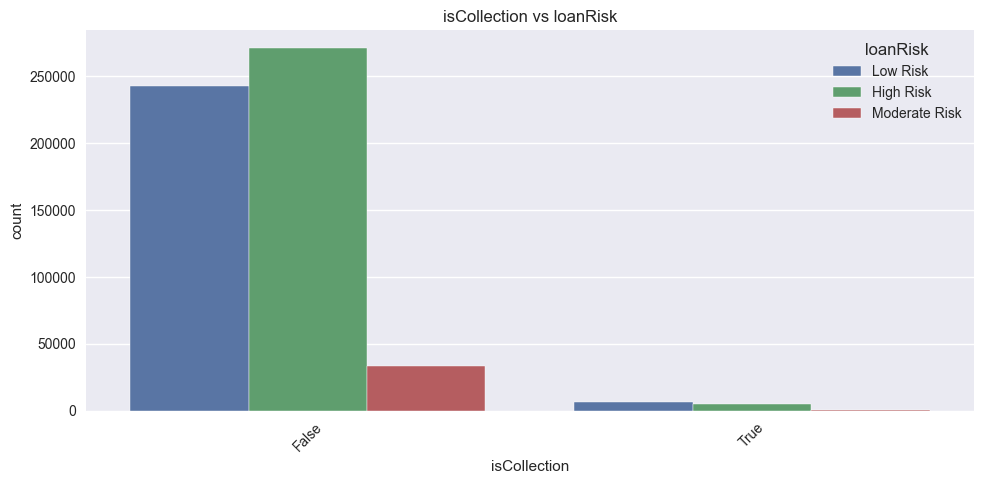

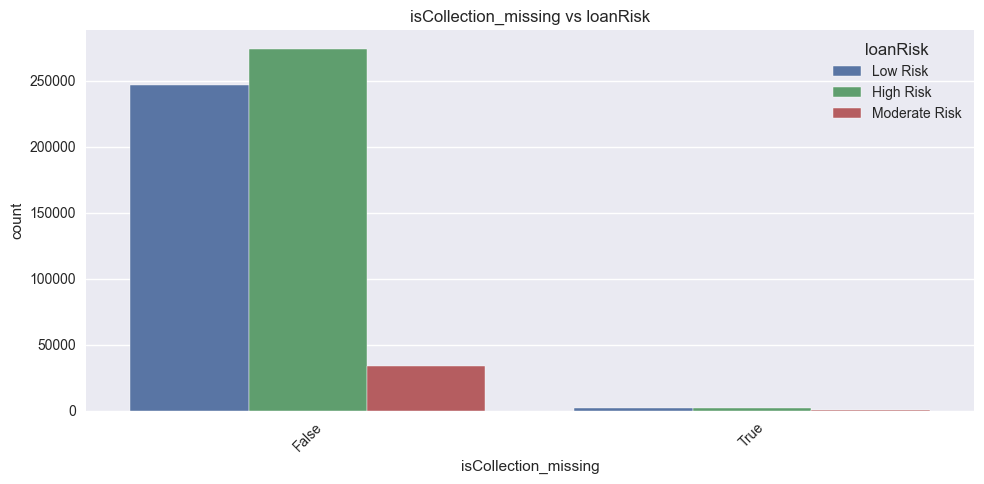

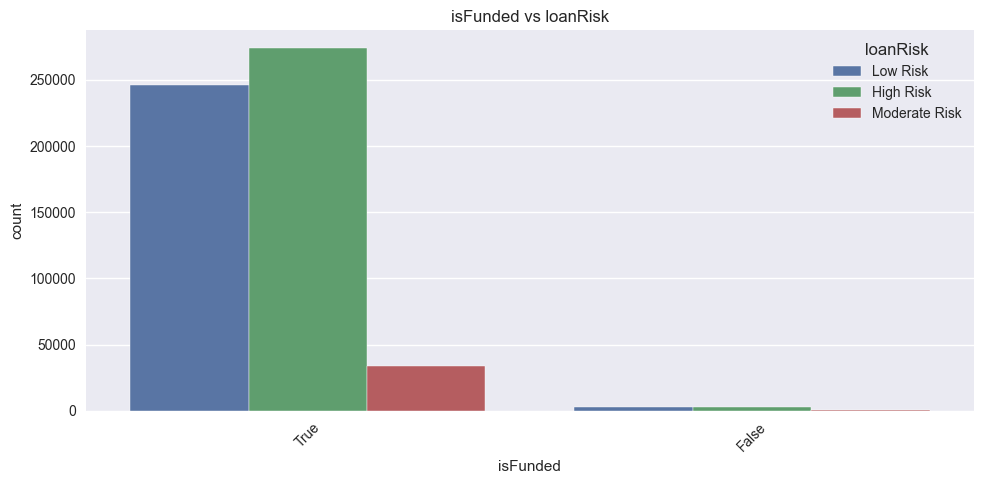

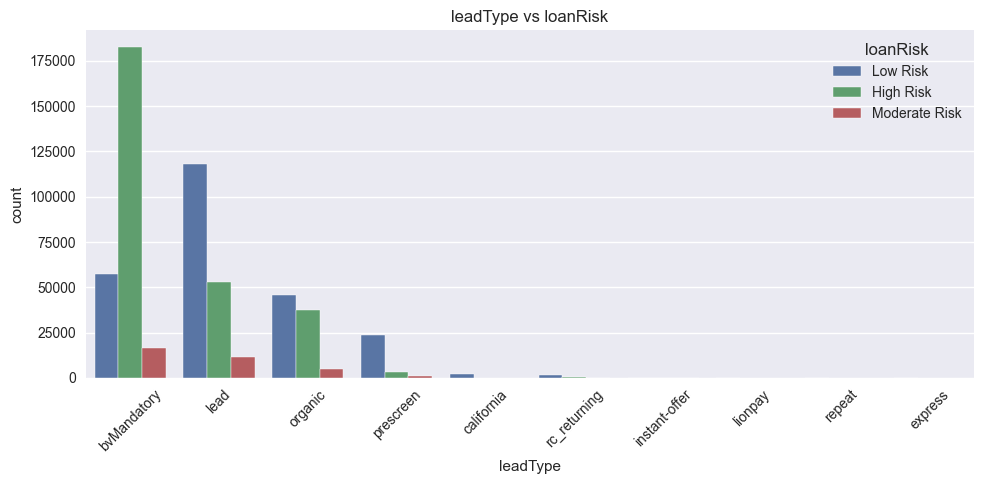

loanId has 36116 unique values. Displaying Top 10.


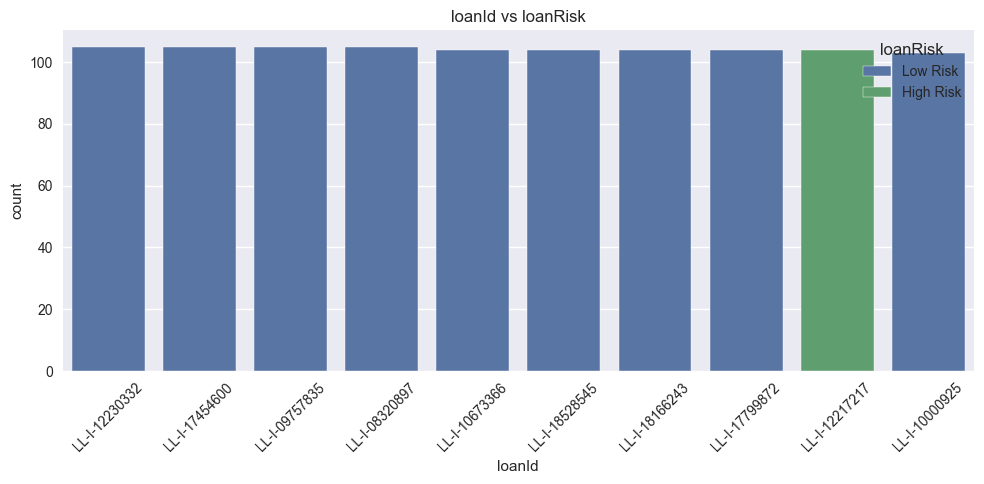

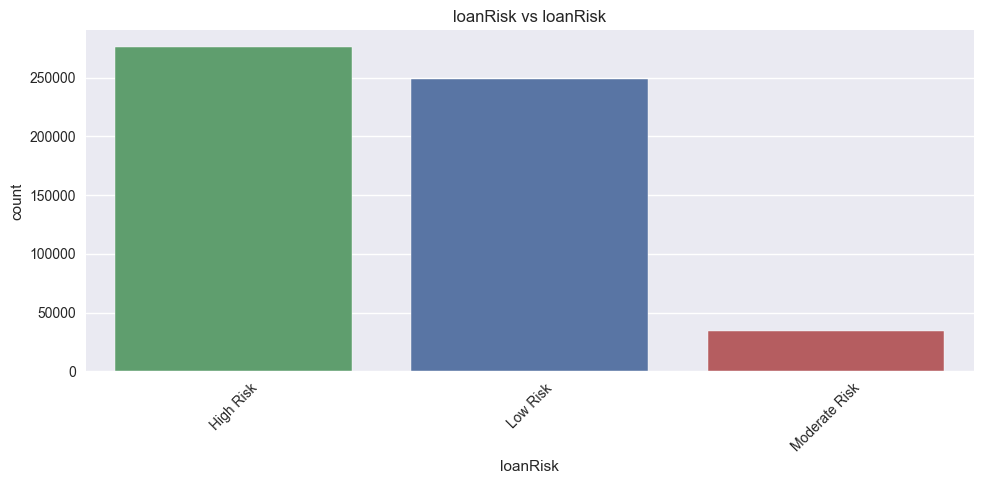

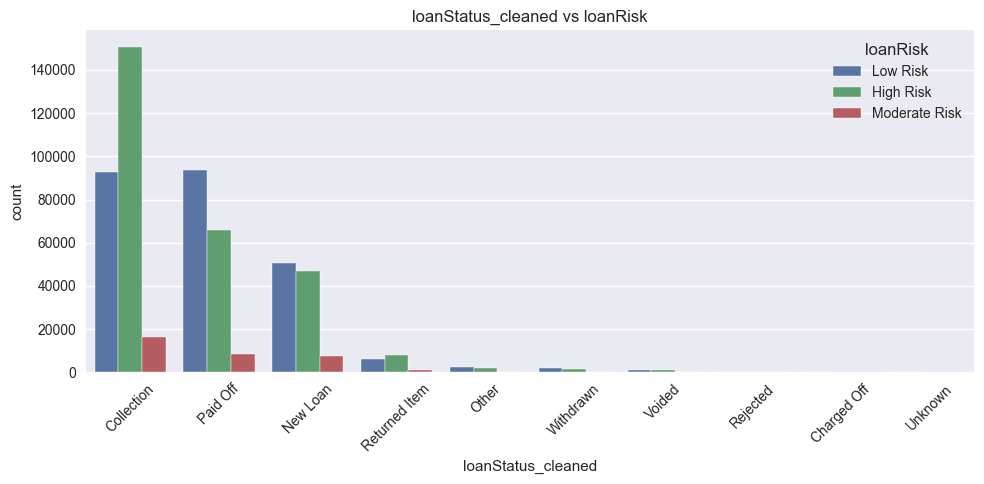

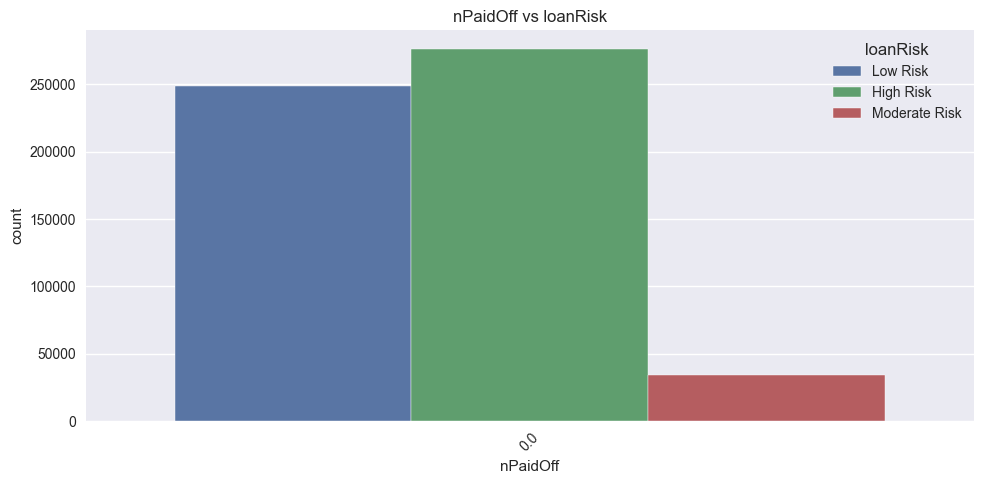

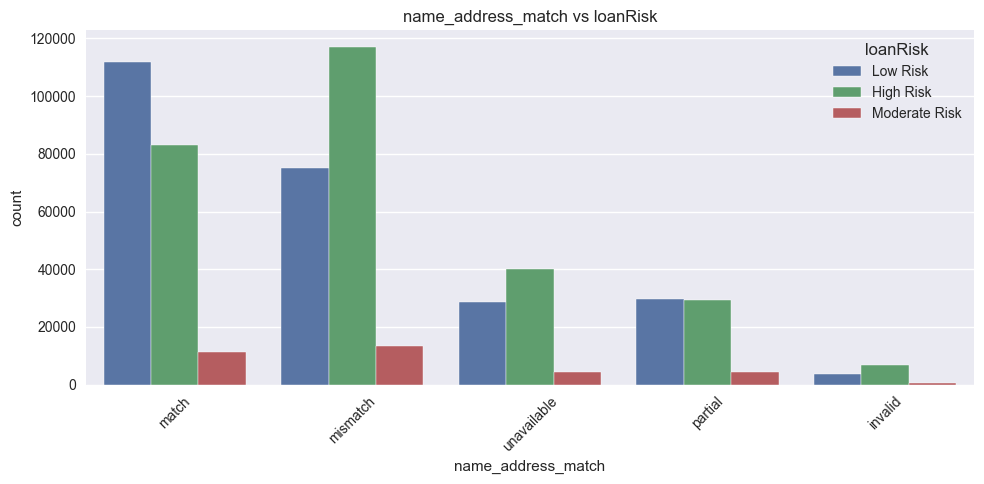

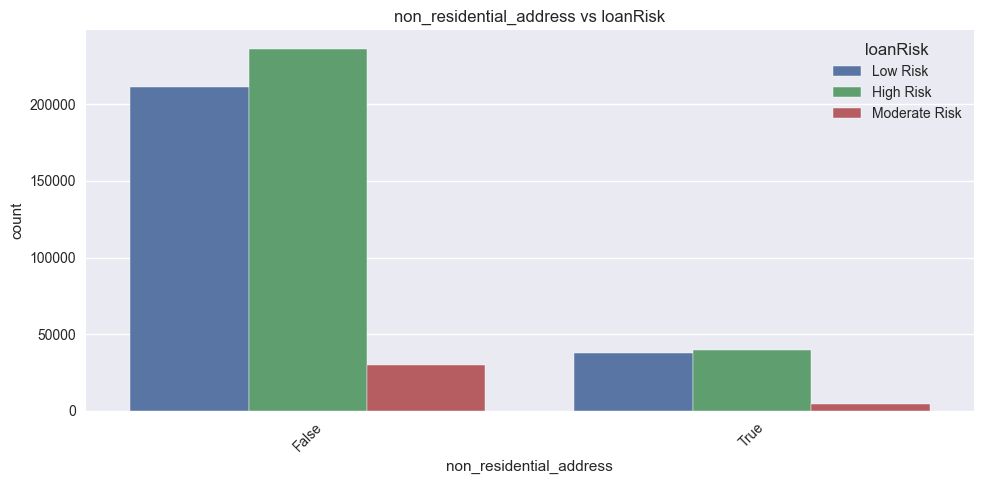

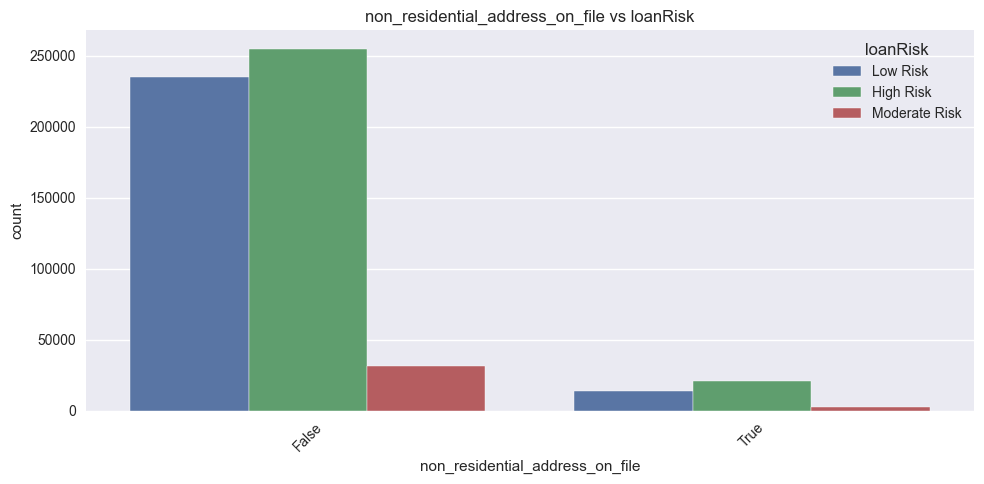

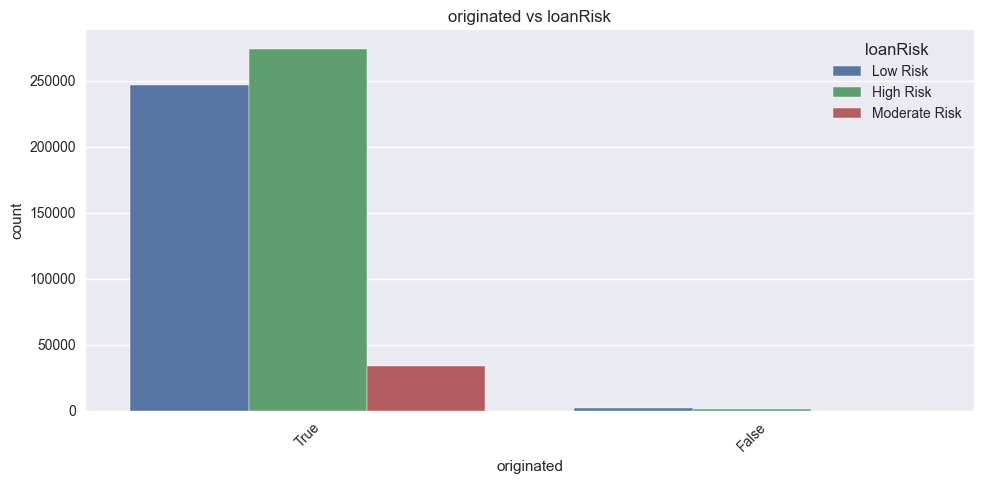

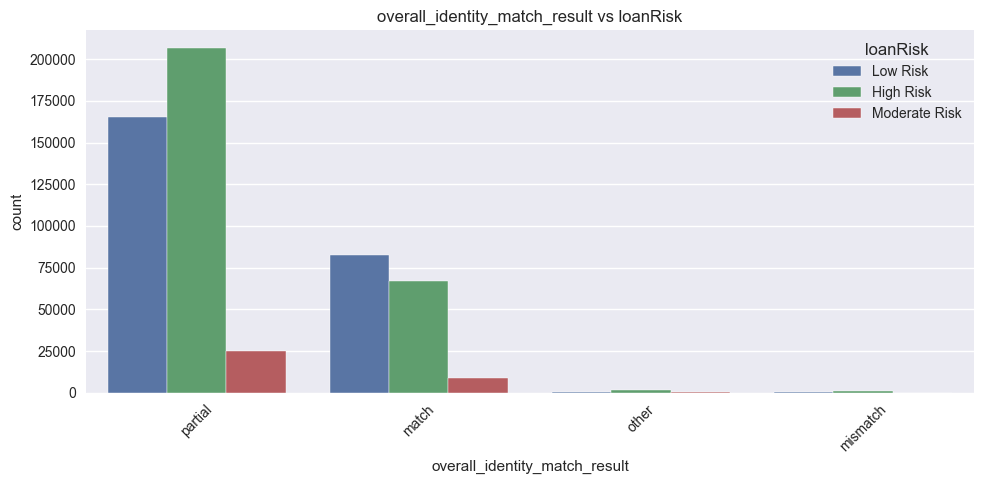

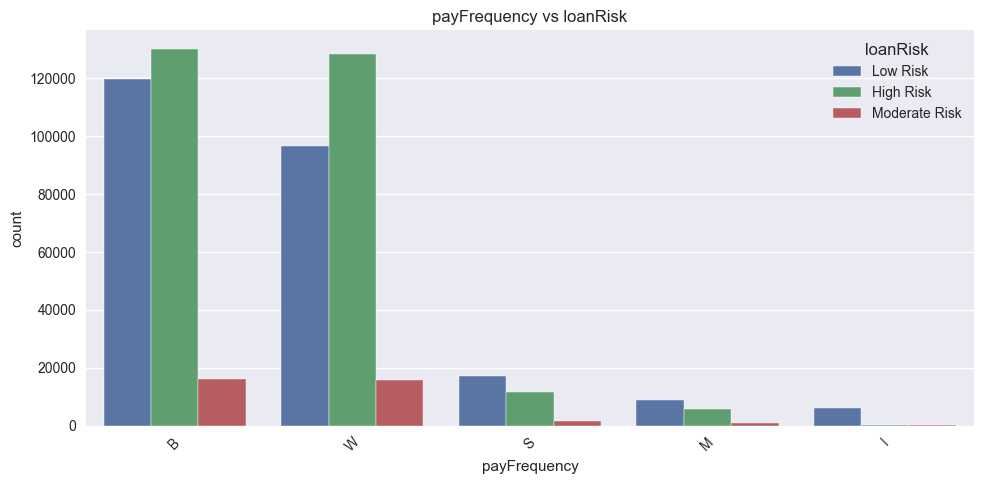

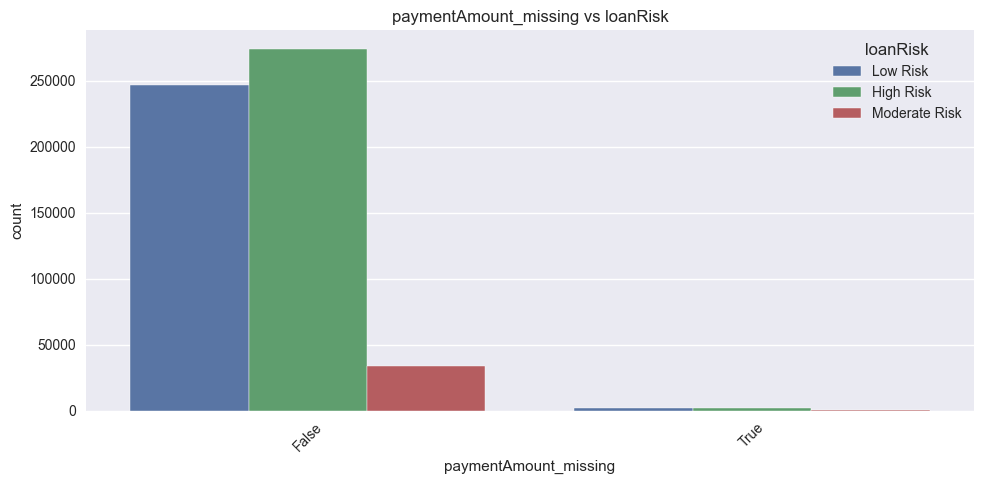

paymentReturnCode has 14 unique values. Displaying Top 10.


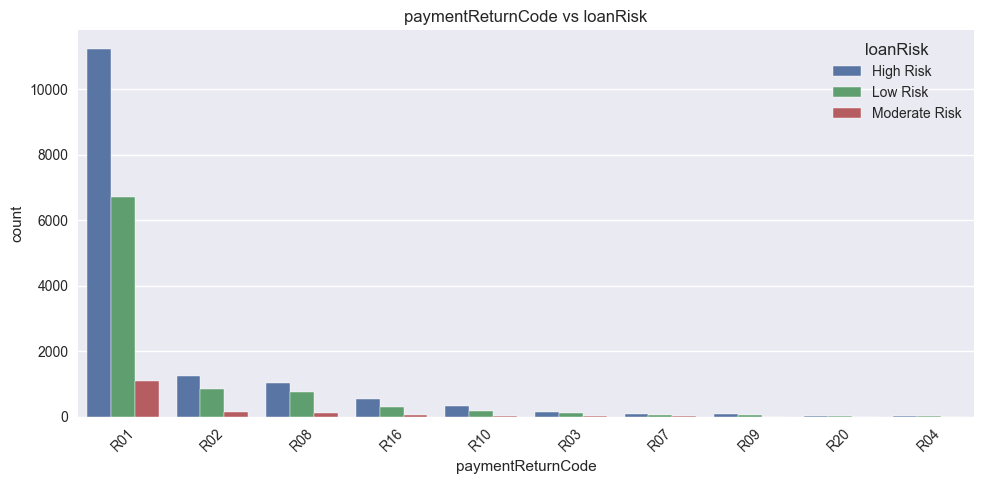

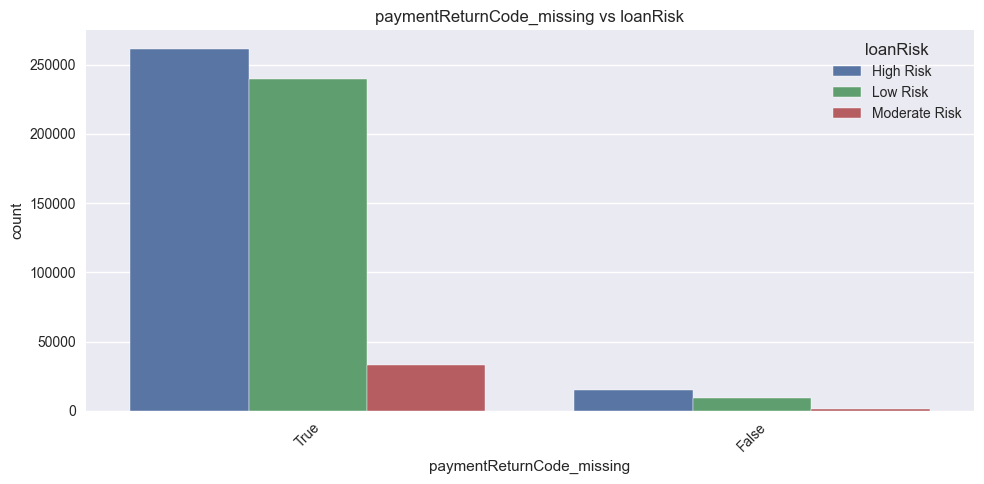

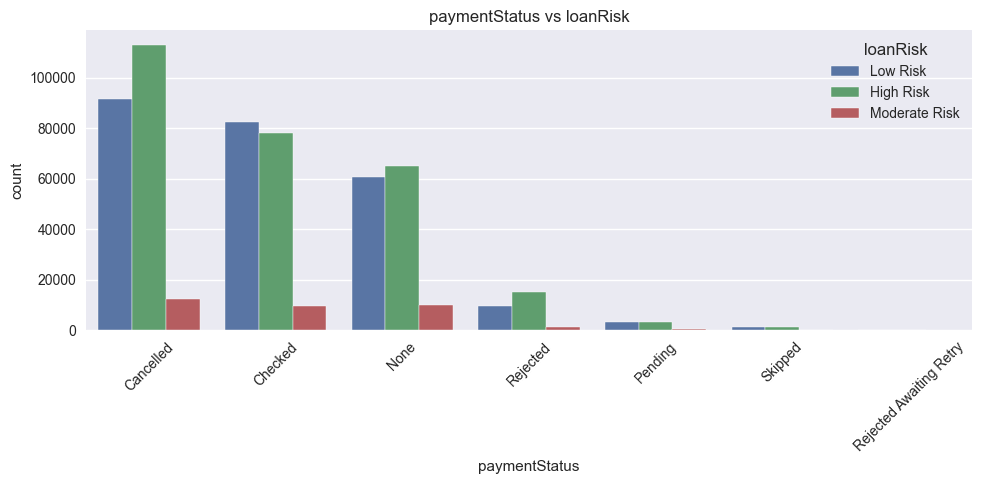

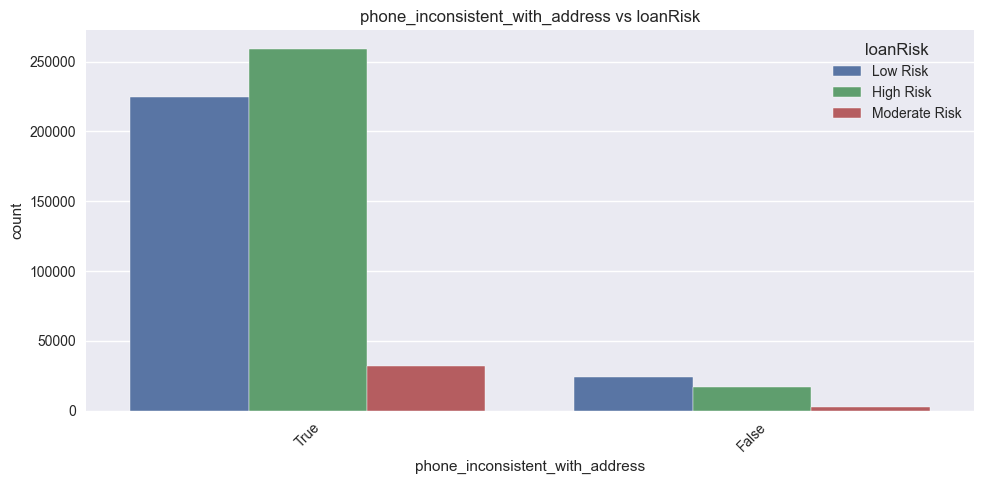

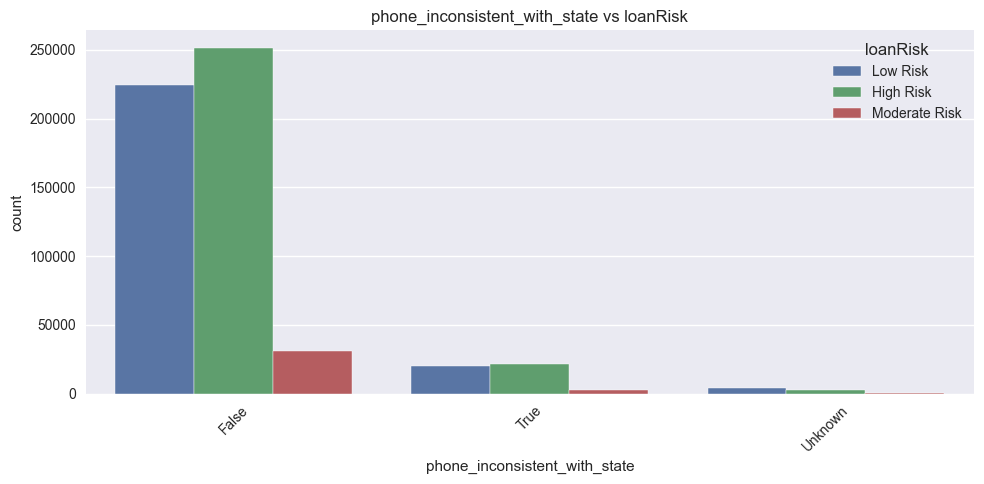

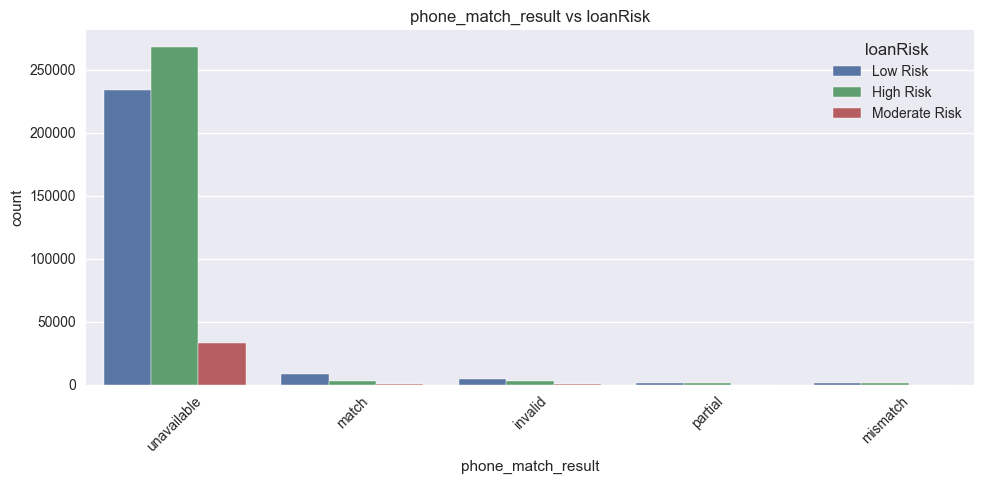

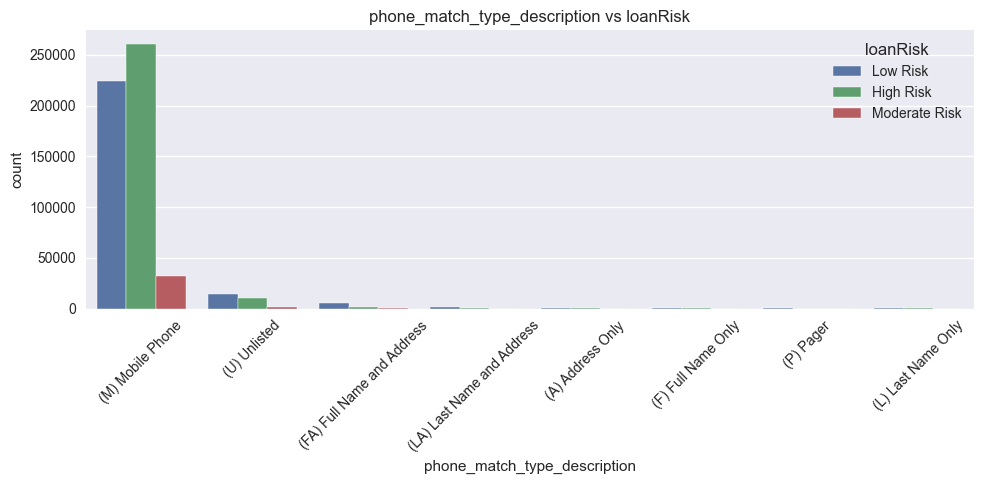

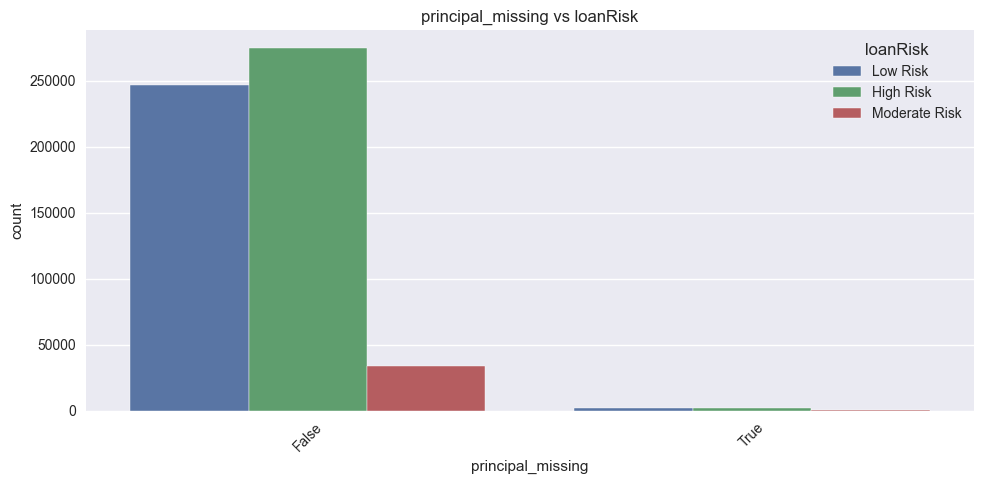

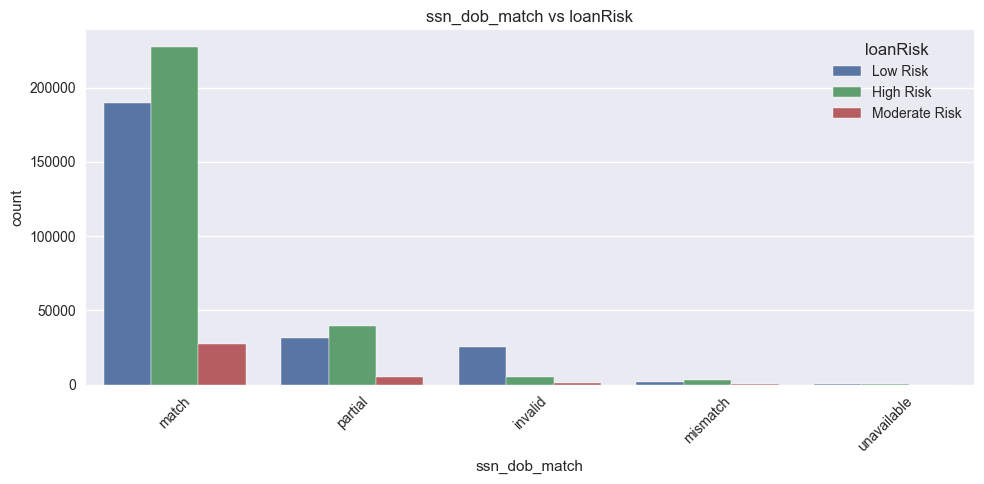

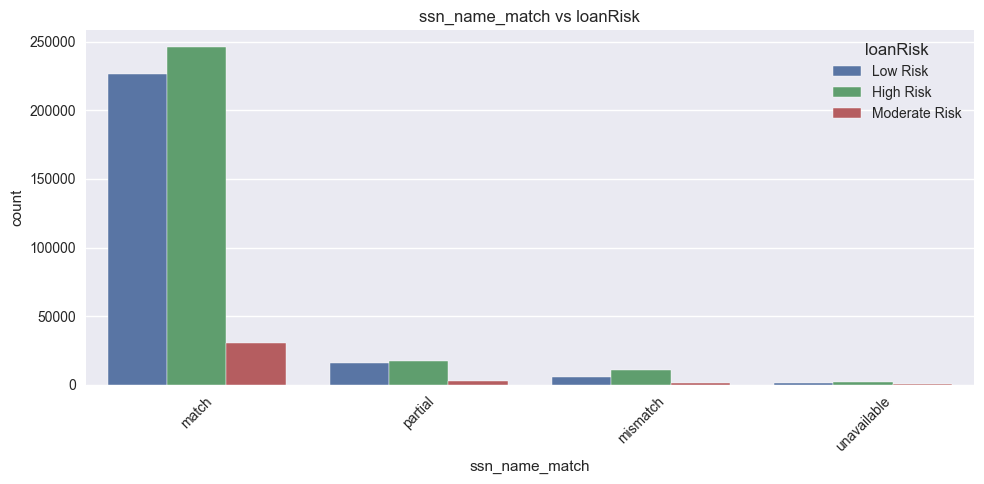

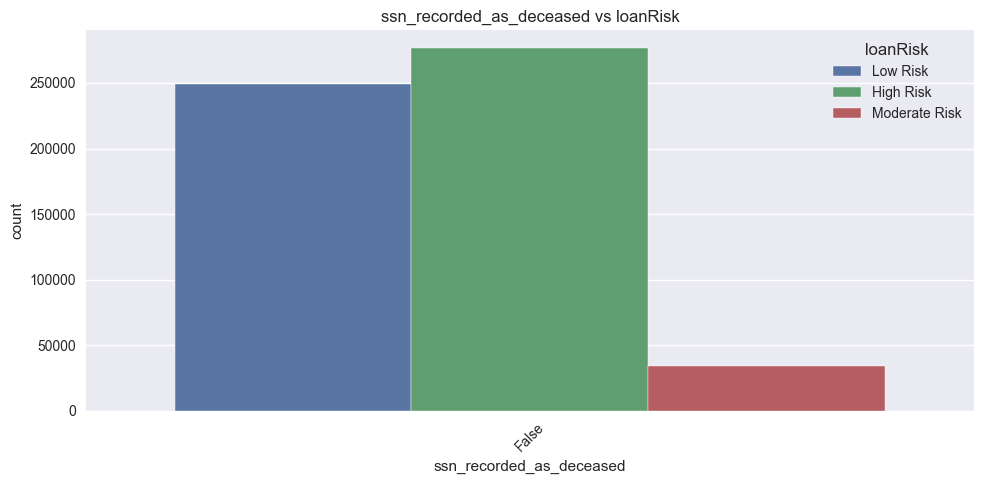

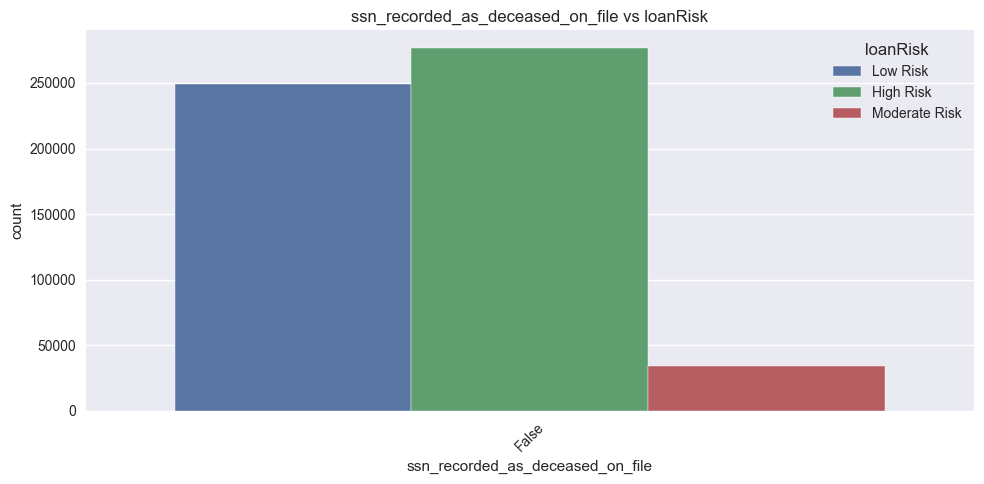

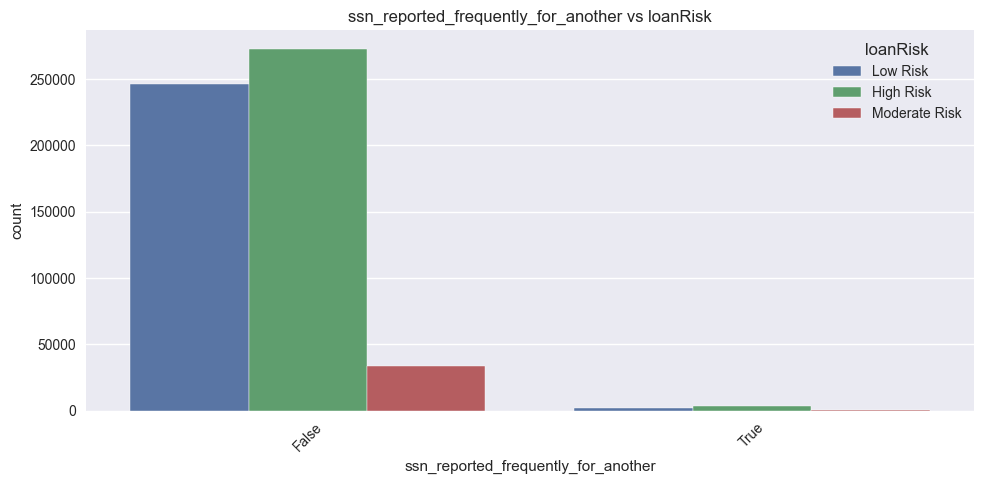

state has 41 unique values. Displaying Top 10.


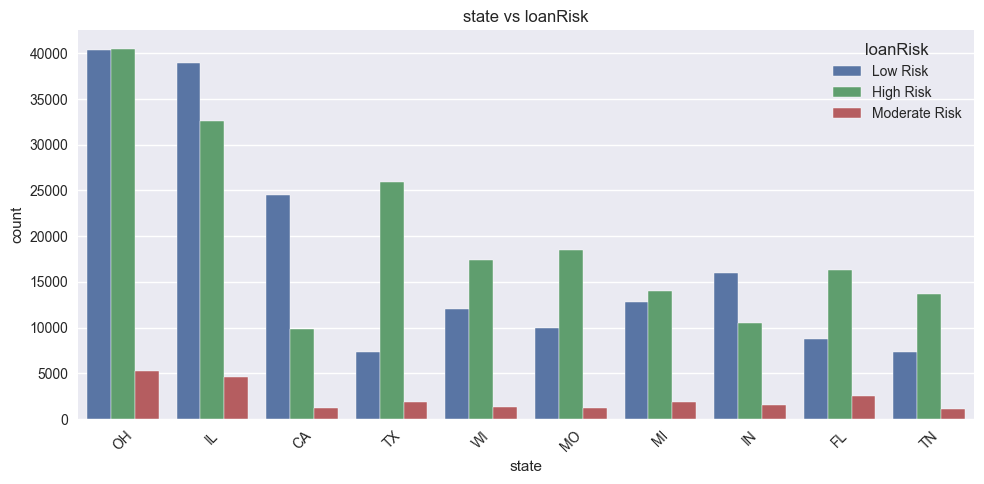

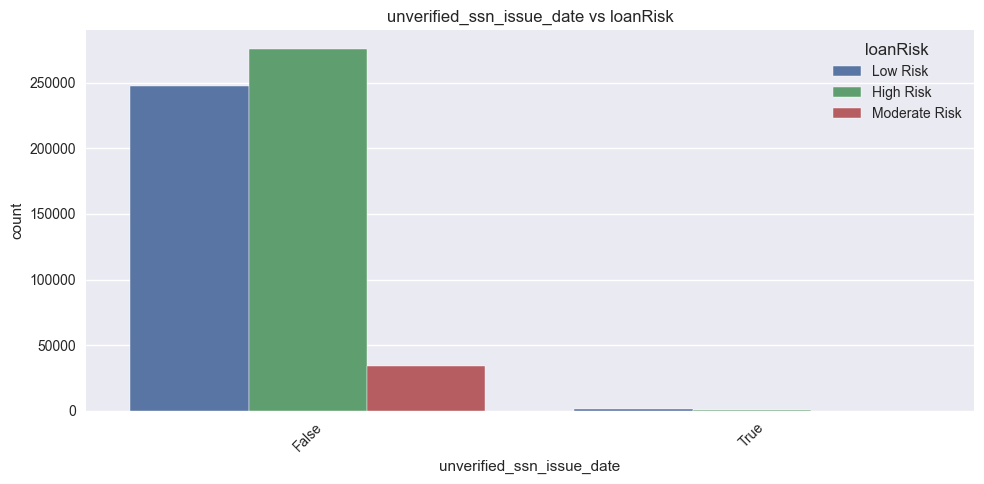

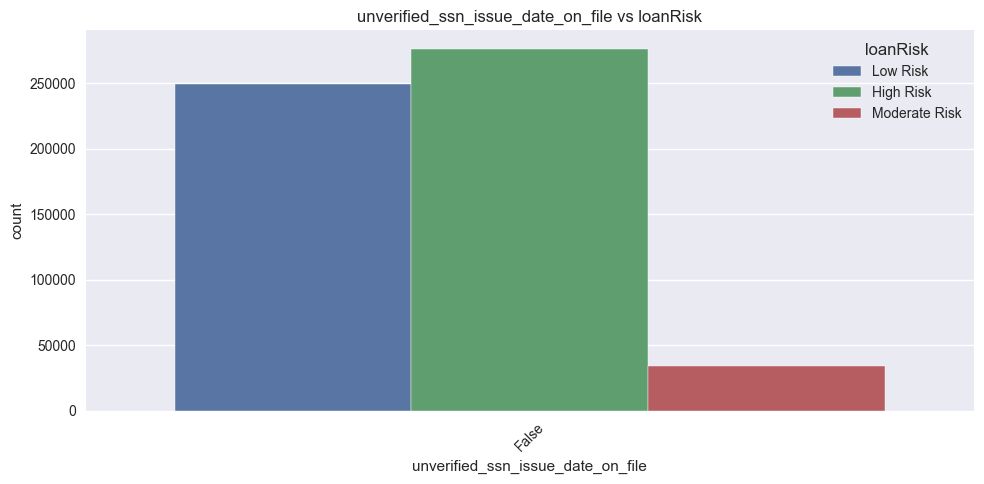

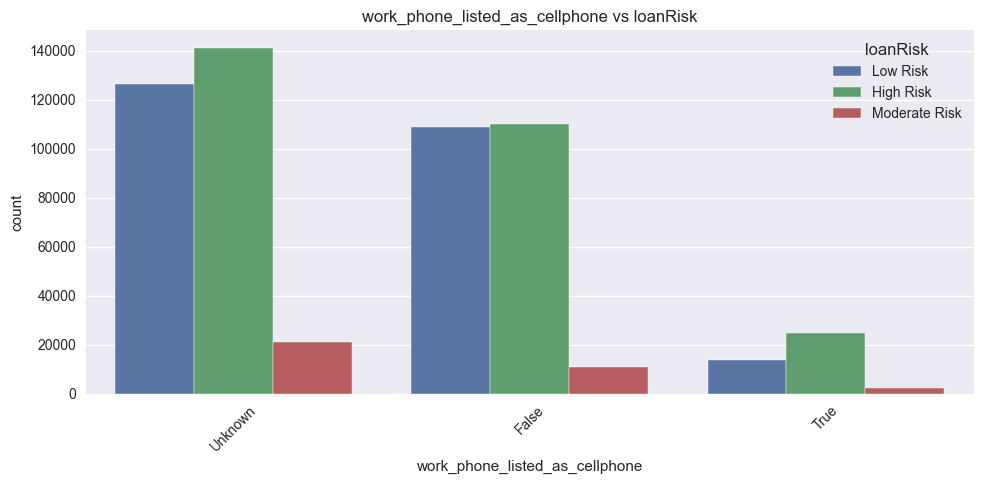

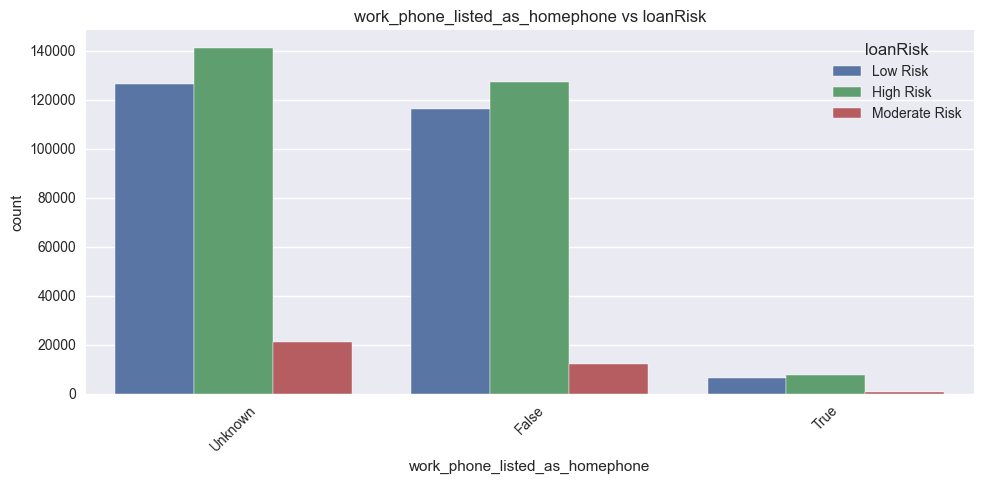

In [110]:
# Usage Example
outlier_analysis(loan_full, 'loanRisk')

# =====================================
# Part 6: Feature Selection
* ### Important features are selected based on their correlation with the target variable or other criteria.

* ### Categorical features are encoded using Label Encoding or One-Hot Encoding based on the model requirements.

## Why This Step is Important

* ### Feature selection enhances model performance by removing irrelevant or redundant variables.

* ### Encoding categorical variables is essential for LightGBM to process them correctly.
# =====================================

In [111]:
loan_data = loan_full.drop(columns=['loanId', 'anon_ssn', 'clarityFraudId'])

In [112]:
from sklearn.preprocessing import LabelEncoder

# 1. Checking unique values
print("Unique values in loanRisk:", loan_data['loanRisk'].unique())

# 2. Label Encoding (for tree-based models)
# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to the target column
loan_data['loanRisk'] = le.fit_transform(loan_data['loanRisk'])

# Display encoded values
print(dict(zip(le.classes_, le.transform(le.classes_))))

Unique values in loanRisk: ['Low Risk' 'High Risk' 'Moderate Risk']
{'High Risk': np.int64(0), 'Low Risk': np.int64(1), 'Moderate Risk': np.int64(2)}


In [113]:
# Convert target column to int (to preserve all categories)
loan_data['loanRisk'] = loan_data['loanRisk'].astype(int)


In [114]:
print(loan_data['loanRisk'].dtypes)

int64


In [115]:
# Display value counts of loanStatus
loan_data['loanRisk'].value_counts(normalize=True) * 100

#0 = High Risk
#1 = Low Risk
#2 = Moderate Risk



loanRisk
0    49.383301
1    44.478120
2     6.138580
Name: proportion, dtype: float64

In [116]:
print("Number of NaN in target (y):", loan_data['loanRisk'].isna().sum())


Number of NaN in target (y): 0



=== Label Encoded Categorical Columns ===
['payFrequency', 'originated', 'approved', 'isFunded', 'state', 'leadType', 'fpStatus', 'isCollection', 'paymentStatus', 'paymentReturnCode', 'address_conflict_on_file', 'phone_inconsistent_with_address', 'age_younger_than_ssn_issue_date', 'cautious_address_on_file', 'non_residential_address', 'high_risk_address_on_file', 'ssn_reported_frequently_for_another', 'current_address_reported_lt_90days', 'invalid_ssn_input', 'unverified_ssn_issue_date', 'cautious_inquiry_address', 'inquiries_gt_3_last_30days', 'non_residential_address_on_file', 'credit_before_ssn_issue_date', 'invalid_driver_license_format', 'ssn_recorded_as_deceased', 'high_risk_inquiry_address', 'current_address_not_on_file', 'unverified_ssn_issue_date_on_file', 'high_probability_ssn_belongs_to_another', 'ssn_recorded_as_deceased_on_file', 'current_address_new_trade_only', 'credit_before_age_18', 'phone_inconsistent_with_state', 'driver_license_inconsistent_with_file', 'work_phone_

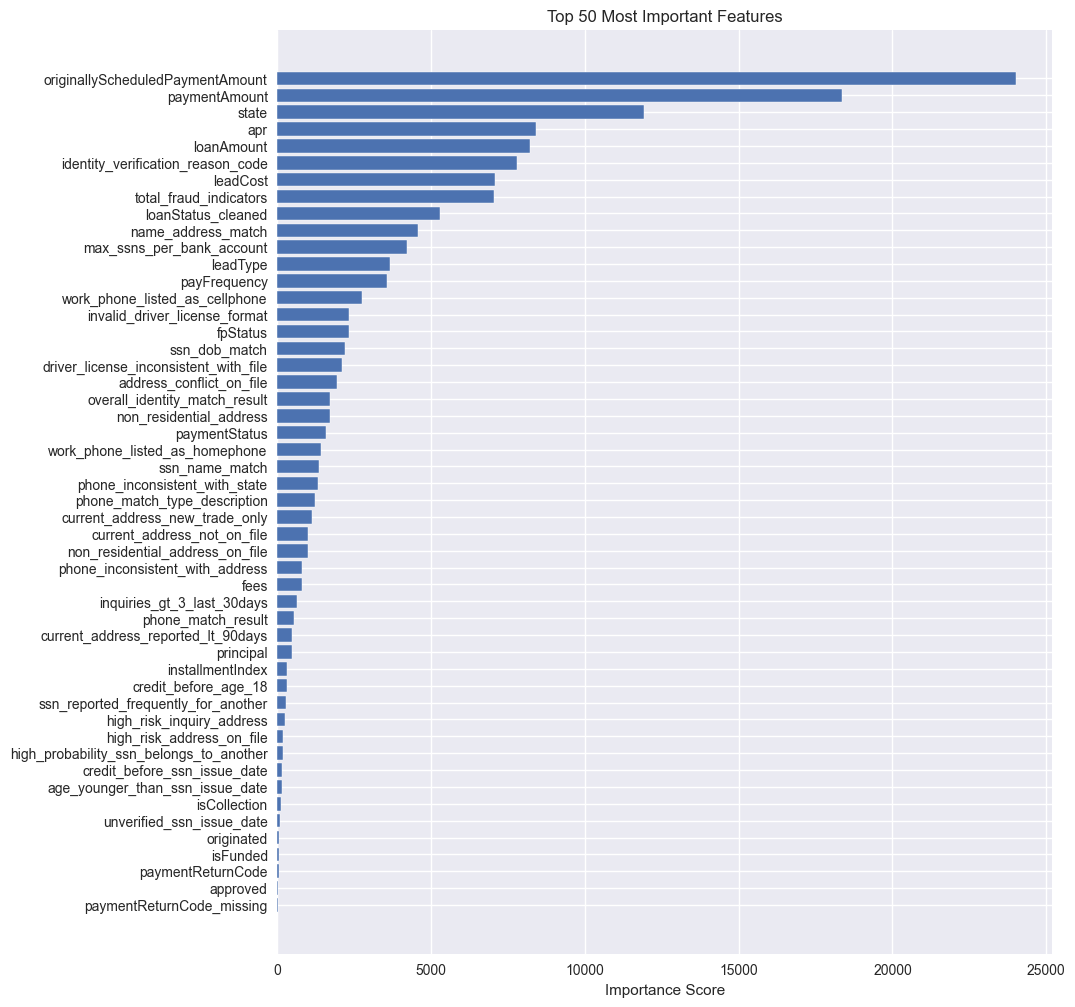

In [117]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Data Preparation ---
X = loan_data.drop(['loanRisk','clearfraudscore'], axis=1) 
y = loan_data['loanRisk']

# --- Handle Missing Values & Preprocessing ---
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
X[numeric_columns] = X[numeric_columns].fillna(X[numeric_columns].median())

categorical_columns = X.select_dtypes(include=['object', 'bool', 'category']).columns
encoded_columns = []  # Track which columns are label encoded

for col in categorical_columns:
    if pd.api.types.is_categorical_dtype(X[col]):
        X[col] = X[col].cat.add_categories(['Unknown']).fillna('Unknown')
    else:
        X[col] = X[col].fillna('Unknown')
    
    # Only apply Label Encoding if column has a reasonable number of categories
    if X[col].nunique() < 50:  # You can adjust this threshold
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        encoded_columns.append(col)
    else:
        print(f"Skipped Label Encoding for {col} due to too many categories.")

# Display which columns are label encoded
print("\n=== Label Encoded Categorical Columns ===")
print(encoded_columns)

# --- Scale Numeric Features ---
scaler = StandardScaler()
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- LightGBM Training ---
params = {
    'objective': 'multiclass',
    'metric': ['multi_logloss', 'multi_error'],
    'num_class': len(np.unique(y)),
    'boosting_type': 'gbdt',
    'learning_rate': 0.08,
    'num_leaves': 50,
    'min_data_in_leaf': 100,
    'feature_fraction': 0.7,
    'is_unbalance': True,
    'verbose': -1
}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_test],
    callbacks=[
        lgb.early_stopping(stopping_rounds=10),
        lgb.log_evaluation(period=10)
    ]
)

# --- Model Evaluation ---
y_pred_proba = model.predict(X_test)
y_pred_class = np.argmax(y_pred_proba, axis=1)

# Evaluation metrics
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_class))
print("\n=== Model Performance ===")
print(classification_report(y_test, y_pred_class))

# ROC-AUC handling
try:
    print("ROC-AUC Score (Multiclass - OvR):", 
          roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))
except ValueError as e:
    print(f"Could not calculate ROC-AUC: {e}")

# --- Feature Importance ---
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importance(importance_type='split')
}).sort_values('Importance', ascending=False)

print("\n=== COMPLETE Feature Importance ===")
print(importance_df.to_string(index=False))

# Visual representation (horizontal bar chart)
plt.figure(figsize=(10, 12))
plt.barh(importance_df['Feature'][:50], importance_df['Importance'][:50])
plt.xlabel('Importance Score')
plt.title('Top 50 Most Important Features')
plt.gca().invert_yaxis()
plt.show()


=== COMPLETE FEATURE IMPORTANCE ===
                                Feature  Importance
       originallyScheduledPaymentAmount       24003
                          paymentAmount       18350
                                  state       11935
                                    apr        8412
                             loanAmount        8222
      identity_verification_reason_code        7782
                               leadCost        7090
                 total_fraud_indicators        7026
                     loanStatus_cleaned        5275
                     name_address_match        4564
              max_ssns_per_bank_account        4226
                               leadType        3649
                           payFrequency        3564
         work_phone_listed_as_cellphone        2762
          invalid_driver_license_format        2336
                               fpStatus        2322
                          ssn_dob_match        2204
  driver_license_inconsisten

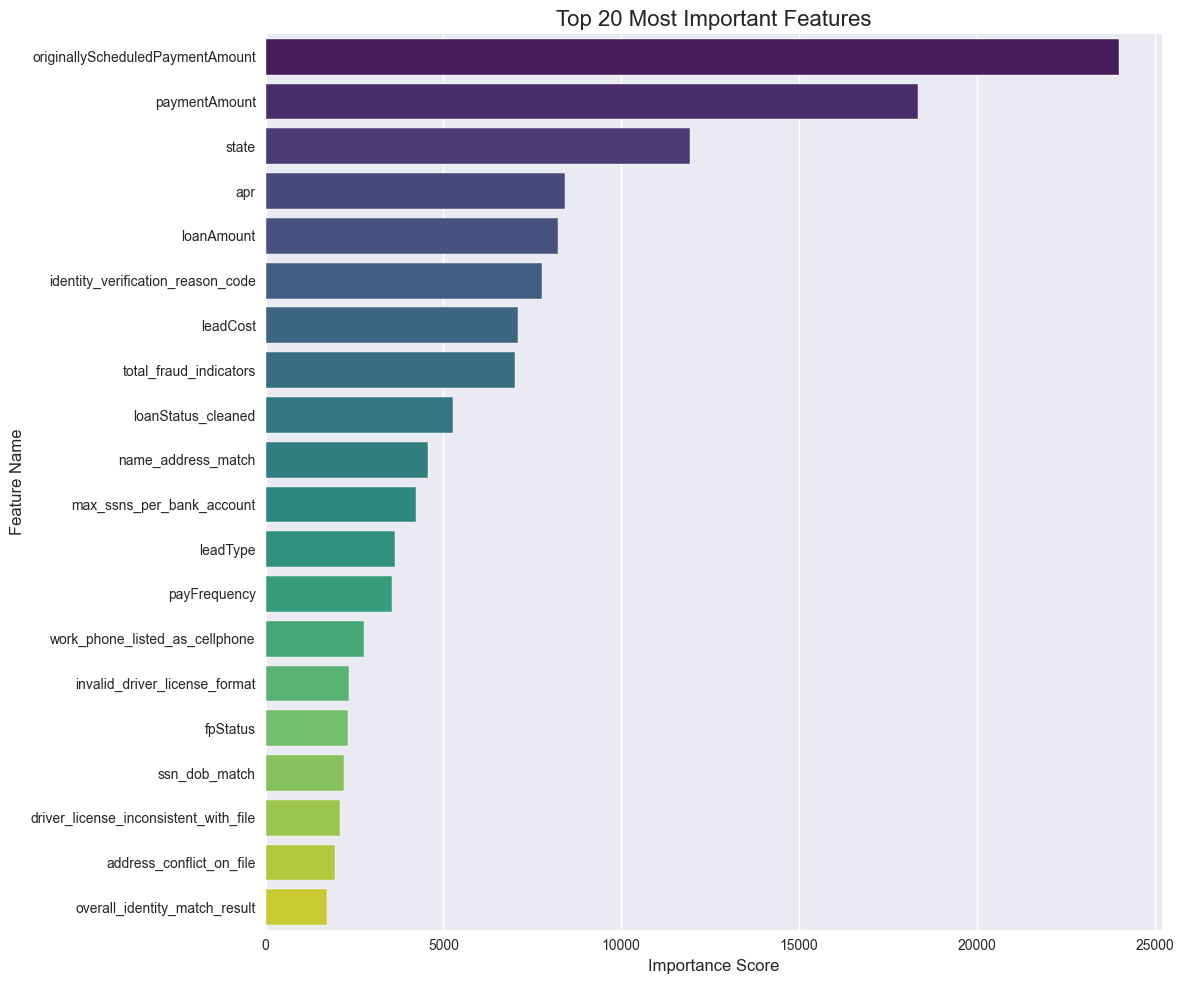

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming importance_df is already created from your LightGBM model
# If not, recreate it with:
# importance_df = pd.DataFrame({
#     'Feature': X.columns,
#     'Importance': model.feature_importance(importance_type='split')
# }).sort_values('Importance', ascending=False)

# 1. Display complete feature importance without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)
print("=== COMPLETE FEATURE IMPORTANCE ===")
print(importance_df.to_string(index=False))

# 2. Identify zero-importance features
zero_importance = importance_df[importance_df['Importance'] == 0]['Feature']
print(f"\nIdentified {len(zero_importance)} zero-importance features:")
print(zero_importance.to_string(index=False))

# 3. Visualize top 20 features
plt.figure(figsize=(12, 10))
top_n = 20
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df.head(top_n),
    palette='viridis'
)
plt.title(f'Top {top_n} Most Important Features', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.tight_layout()
plt.show()


In [119]:
# --- Identifying Low-Importance Features ---
print("\nIdentifying low-importance features...")
low_importance = importance_df[importance_df['Importance'] < 10]['Feature'].tolist()
print(f"Low-importance features identified (<5): {len(low_importance)}")

# --- Dropping Low-Importance Features ---
print("\nRemoving low-importance features from loan_data...")
loan_data.drop(columns=low_importance, errors='ignore', inplace=True)
print(f"Removed {len(low_importance)} low-importance features from loan_data.")

# --- Saving Finalized Dataset ---
loan_data.to_csv('../data/final_loan_data.csv', index=False)
print("\nSaved full dataset (without low-importance features) to CSV.")


Identifying low-importance features...
Low-importance features identified (<5): 13

Removing low-importance features from loan_data...
Removed 13 low-importance features from loan_data.

Saved full dataset (without low-importance features) to CSV.


# =====================================
# Part 7: Model Development
* ### The LightGBM model is chosen for its speed and efficiency in handling large datasets.

* ### Model parameters are configured, and the model is trained on the training dataset.

## Why LightGBM?

* ### LightGBM is fast, efficient, and suitable for large datasets.

* ### It automatically handles missing values and supports categorical features natively.

## Model Evaluation

* ### The model's performance is evaluated using metrics such as AUC, accuracy, precision, recall, and F1-score.

* ### A confusion matrix is generated to provide a visual understanding of the model's performance.

## Why This Step is Important

* ### Evaluation metrics provide insights into the model’s performance on unseen data.

* ### The confusion matrix helps in identifying the types of errors the model makes.
# =====================================

Original training set class distribution:
 loanRisk
0    221076
1    199116
2     27481
Name: count, dtype: int64

After SMOTE training set class distribution:
 loanRisk
1    221076
0    221076
2    221076
Name: count, dtype: int64

=== Training LightGBM Model ===
Training until validation scores don't improve for 10 rounds
[10]	valid_0's multi_logloss: 0.826868	valid_0's multi_error: 0.253424
[20]	valid_0's multi_logloss: 0.719295	valid_0's multi_error: 0.248305
[30]	valid_0's multi_logloss: 0.665531	valid_0's multi_error: 0.242434
[40]	valid_0's multi_logloss: 0.631057	valid_0's multi_error: 0.235635
[50]	valid_0's multi_logloss: 0.606419	valid_0's multi_error: 0.229845
[60]	valid_0's multi_logloss: 0.588974	valid_0's multi_error: 0.225904
[70]	valid_0's multi_logloss: 0.574409	valid_0's multi_error: 0.221759
[80]	valid_0's multi_logloss: 0.561746	valid_0's multi_error: 0.217872
[90]	valid_0's multi_logloss: 0.550276	valid_0's multi_error: 0.214539
[100]	valid_0's multi_logloss: 0.54

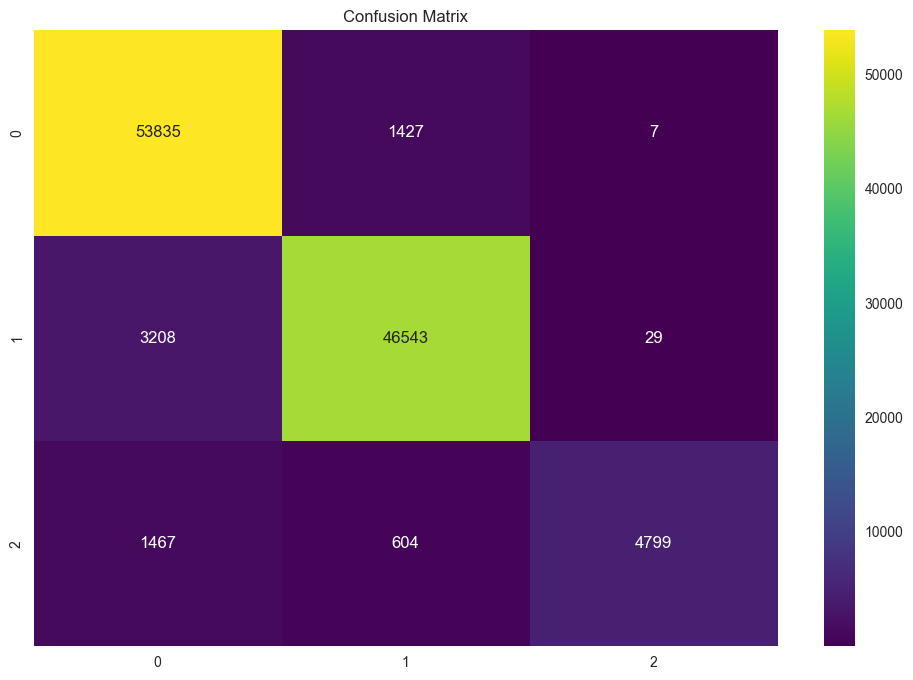


=== Model Saved Successfully at: c:\Users\Horng Woei\Desktop\MoneyLion\models\lightgbm_model.pkl ===


In [120]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# --- Load Data ---
data_file = 'final_loan_data.csv'
loan_data = pd.read_csv(data_file)

# --- Data Preparation ---
X = loan_data.drop(['loanRisk','clearfraudscore'], axis=1) 
y = loan_data['loanRisk']

# === Encode Categorical Features (if any) ===
label_encoders = {}
for col in X.select_dtypes(include=['object', 'bool', 'category']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Apply SMOTE to the training set ---
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Original training set class distribution:\n", pd.Series(y_train).value_counts())
print("\nAfter SMOTE training set class distribution:\n", pd.Series(y_train_smote).value_counts())

# --- LightGBM Model Training ---
params = {
    'objective': 'multiclass',
    'metric': ['multi_logloss', 'multi_error'],
    'num_class': len(np.unique(y)),
    'boosting_type': 'gbdt',
    'learning_rate': 0.08,
    'num_leaves': 50,
    'min_data_in_leaf': 100,
    'feature_fraction': 0.7,
    'is_unbalance': True,
    'verbose': -1
}

print("\n=== Training LightGBM Model ===")
model = lgb.train(
    params,
    lgb.Dataset(X_train_smote, y_train_smote),
    num_boost_round=1000,
    valid_sets=[lgb.Dataset(X_test, y_test)],
    callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)]
)

# --- Model Evaluation ---
y_pred_proba = model.predict(X_test)
y_pred_class = np.argmax(y_pred_proba, axis=1)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_class))

print("\n=== Confusion Matrix ===")
sns.heatmap(confusion_matrix(y_test, y_pred_class), annot=True, cmap='viridis', fmt='d')
plt.title('Confusion Matrix')
plt.show()

# --- Save Model ---
# Get the directory where your notebook is located
NOTEBOOK_DIR = os.path.dirname(os.path.abspath('__file__'))  # Gets notebook directory
BASE_DIR = os.path.dirname(NOTEBOOK_DIR)  # Gets parent directory of notebook
MODELS_DIR = os.path.join(BASE_DIR, 'models')  # notebook/../models subdirectory

# Create directory if it doesn't exist
os.makedirs(MODELS_DIR, exist_ok=True)  # Won't raise error if directory exists

# Define full model path
model_path = os.path.join(MODELS_DIR, 'lightgbm_model.pkl')

# Save the model
joblib.dump(model, model_path)
print(f"\n=== Model Saved Successfully at: {model_path} ===")